# On semantic segmentation: training of a simplified PSPNet model and comparative evaluation of pretrained models

[Marcos Escudero-Viñolo](http://www-vpu.eps.uam.es/webvpu/gti/user/18/), [Video Processing and Understanding Lab.](http://www-vpu.eps.uam.es/webvpu/es/)

Some parts of this lab have been adapted from the work of [Diego Ortego](https://sites.google.com/view/diegoortego/), [Insight Centre for Data Analytics](https://www.insight-centre.org/) [Dublin City University](https://www.dcu.ie/)

---

This lab is divided into two parts.

The first part illustrates how to specify and train a fully-convolutional neural network for semantic segmentation. We rely on a [PSPNet](https://arxiv.org/abs/1612.01105) architecture that consists of a backbone network (e.g. ResNet or VGG) with dilated convolutions in some layers, followed by a Pyramid Pooling Module--to further capture more context information, and of the final convolutional classifier. Here, to ease and accelerate training, we use a simplified version of the PSPNet architecture: using ResNet-18 and a single Pooling module (no pyramid). Furthermore, the model is trained on a version of the [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) dataset of reduced image resolution. We will also explore here the potential benefits of using a weighted loss for training.

The second part is focused on evaluating qualitatively (an in terms of inference time) the four pretrained semantic segmentation models available at pytorch. You will be given some functions and will be asked to change the input image and the parameters to compare these four models.




# Instructions

Anywhere you see a **???** in the code below, fill in in with the correct code.

In [13]:
import sys
print(sys.version)

3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]


# Preliminaries

## Import packages
Find the PyTorch docs at https://pytorch.org/docs/stable/index.html

Tutorials: https://pytorch.org/tutorials/

In [14]:
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torchvision.datasets.utils import download_file_from_google_drive

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import sys
import argparse
import os
import time
from os.path import join
import csv

print('PyTorch version:', torch.__version__)

# install wget for data sharing
# !pip install wget
import wget

PyTorch version: 2.0.1


## Hyperparameters + Enable GPU acceleration

In [15]:
class configuration:
  def __init__(self):
    self.experiment_name = "PR-3"

    # Paramters for the first part
    self.pre_load    = "True" ## Load dataset in memory
    self.pre_trained = "True"
    self.num_classes = 21 
    self.ignore_label = 255

    self.lr    = 0.001  # 0.001 if pretrained. 0.1 if scratch
    self.epoch = 45     # Play with this if training takes too long
    self.M = []         # If training from scratch, reduce learning rate at some point

    self.batch_size = 16  # Training batch size
    self.test_batch_size = 4  # Test batch size

    self.train_root = "./VOC"
    self.download   = False

    self.seed = 271828

## Create arguments object
args = configuration()

# Make sure to enable GPU acceleration!
device = 'cuda'

# Set random seed for reproducibility
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)

# Part 1: Training a PSPNet-like Semantic Segmentation Network

## Prepare training and validation data


### Download dataset
It is a large one, it may take a while...

In [16]:
"""
def bar_custom(current, total, width=80):
    print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))

url = 'http://www-vpu.eps.uam.es/misc/DL4IP/VOC.tar'
print('Downloading...')
filename = wget.download(url, out='./VOC.tar', bar=bar_custom)
print('Extracting...')
!tar xf VOC.tar
print('Deleting...')
!rm VOC.tar
print('Done!')
"""

'\ndef bar_custom(current, total, width=80):\n    print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))\n\nurl = \'http://www-vpu.eps.uam.es/misc/DL4IP/VOC.tar\'\nprint(\'Downloading...\')\nfilename = wget.download(url, out=\'./VOC.tar\', bar=bar_custom)\nprint(\'Extracting...\')\n!tar xf VOC.tar\nprint(\'Deleting...\')\n!rm VOC.tar\nprint(\'Done!\')\n'

### Dataset loading
Training will be driven by the [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) dataset, with over 8K/0.7K images for training/validation.

Here, we use images with 224x224 resolution including the following classes:

0=background, 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle, 6=bus, 7=car, 8=cat, 9=chair, 10=cow, 11=diningtable,
12=dog, 13=horse, 14=motorbike, 15=person, 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor

The following method preloads images of the dataset.

In [17]:
def load_dataset(args, mode):
    assert mode in ['train', 'val', 'test']
    items = []
    if mode == 'train':
        img_path = os.path.join(args.train_root, 'benchmark_RELEASE', 'dataset', 'img')
        mask_path = os.path.join(args.train_root, 'benchmark_RELEASE', 'dataset', 'cls')
        data_list = [l.strip('\n') for l in open(os.path.join(
            args.train_root, 'benchmark_RELEASE', 'dataset', 'train.txt')).readlines()]
        for it in data_list:
            item = (os.path.join(img_path, it + '.jpg'), os.path.join(mask_path, it + '.mat'))
            items.append(item)
    elif mode == 'val':
        img_path = os.path.join(args.train_root, 'VOCdevkit', 'VOC2012', 'JPEGImages')
        mask_path = os.path.join(args.train_root, 'VOCdevkit', 'VOC2012', 'SegmentationClass')
        data_list = [l.strip('\n') for l in open(os.path.join(
            args.train_root, 'VOCdevkit', 'VOC2012', 'ImageSets', 'Segmentation', 'seg11valid.txt')).readlines()]
        for it in data_list:
            item = (os.path.join(img_path, it + '.jpg'), os.path.join(mask_path, it + '.png'))
            items.append(item)
    else:
        img_path = os.path.join(args.train_root, 'VOCdevkit (test)', 'VOC2012', 'JPEGImages')
        data_list = [l.strip('\n') for l in open(os.path.join(
            args.train_root, 'VOCdevkit (test)', 'VOC2012', 'ImageSets', 'Segmentation', 'test.txt')).readlines()]
        for it in data_list:
            items.append((img_path, it))
    return items

### Define class to encapsulate the dataset
This class is used to upload, transform and arrange the data.

The mode parameter differentiates between train and test operations.

This code performs transformations by default inside this class. The decision for doing this is to easily handle that transformations have to be applied similarly to the image and the ground-truth (GT) segmentation mask. For example, if a crop is done to the image in a certain location, it has to be done in the same location in its associated GT mask.

In [18]:
class VOC(data.Dataset):
    def __init__(self, args, mode, transform_input=None, transform_mask=None):
        self.args = args
        self.imgs = load_dataset(self.args, mode)
        if len(self.imgs) == 0:
            raise RuntimeError('Found 0 images, please check the data set')
        self.mode = mode

        self.transform_input = transform_input
        self.transform_mask = transform_mask

    # Default trasnformations on train data
    def transform(self, image, mask):
        # TO FILL:
        # 1st Resize image and mask to 400x400 using nearest neighbor interpolation.
        res_size = (400,400)
        resize = transforms.Resize(res_size, interpolation=transforms.InterpolationMode.NEAREST)
        image  = resize(image)
        mask   = resize(mask)
        # TO FILL:
        # 2nd Random crop:
        # a) get random parameters for obtaining a 224x224 version of the image by cropping (to be used later)
        # This is to ensure that crop parameters are the same for image and mask. If not, the ground-truth mask would not be aligned with its image content.
        
        crop_size = (224,224)
        random_crop = transforms.RandomCrop(crop_size)
        params = random_crop.get_params(image, output_size=crop_size)
        i, j, h, w = params
        # i, j, h, w = random.randint(0,int((400-224)/2)), random.randint(0,int((400-224)/2)), 224, 224
        # b) Crop according to these parameters
        image = TF.crop(image, i, j, h, w)
        mask  = TF.crop(mask, i, j, h, w)
        # TO FILL:
        # 3rd random horizontal flipping
        if random.random() > 0.5:
            image = transforms.RandomHorizontalFlip(p=1)(image)
            mask  = transforms.RandomHorizontalFlip(p=1)(mask)

        return image, mask

    # Default trasnformations on test data
    def test_transform(self, image, mask):
        # TO FILL:
        # 1st Resize image and mask to 400x400 using nearest neighbor interpolation.
        res_size = (400,400)
        resize = transforms.Resize(res_size, interpolation=transforms.InterpolationMode.NEAREST)
        image  = resize(image)
        mask   = resize(mask)

        # TO FILL:
        # 2nd a 224x224 center crop:
        image = transforms.CenterCrop(224)(image)
        mask  = transforms.CenterCrop(224)(mask)

        return image, mask

    def __getitem__(self, index):
        if self.mode == 'test':
            img_path, img_name = self.imgs[index]
            img = Image.open(os.path.join(img_path, img_name + '.jpg')).convert('RGB')
            if self.transform is not None:
                img = self.transform(img)
            return img_name, img

        img_path, mask_path = self.imgs[index]
        img = Image.open(img_path).convert('RGB')
        if self.mode == 'train':
            mask = sio.loadmat(mask_path)['GTcls']['Segmentation'][0][0]
            mask = Image.fromarray(mask.astype(np.uint8))
            
            """
            # For training w/o background
            mapping_function = lambda pixel: 255 if pixel == 0 else pixel
            # Apply the mapping function using the point method
            mask = mask.point(mapping_function)
            """
            
        else:
            mask = Image.open(mask_path)
            
            """
            # For training w/o background
            mapping_function = lambda pixel: 255 if pixel == 0 else pixel
            # Apply the mapping function using the point method
            mask = mask.point(mapping_function)
            """

        ##Transform using default transformations
        if self.mode=="train":
            # TO FILL:trasnform training data
            img, mask = self.transform(img, mask)
        else:
            # TO FILL:trasnform test data
            img, mask = self.test_transform(img, mask)

        ##Further transform using additional transformations specified via parameters.
        if self.transform_input is not None:
            img = self.transform_input(img)
        if self.transform_mask is not None:
            mask = 255*self.transform_mask(mask)

        return img, mask.long()

    def __len__(self):
        return len(self.imgs)

### Addditional image transformations
Here only normalization and to tensor transformations are included.

In [19]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_input = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_mask = transforms.ToTensor()

## Define the CNN architecture and its training and validation protocols

### CNN architecture
We are using a modified PSPnet with a ResNet-18 backbone (that can be load with weights pretrained on ImageNet or with random weights).

Note that there are no fully-connected layers in the networks, i.e. it is fully-convolutional.


In [20]:
class PSPNetLite(nn.Module):
    def __init__(self, args, num_classes, pretrained=True, use_aux=True):
        super(PSPNetLite, self).__init__()
        self.use_aux = use_aux

        #TO FILL: define pytorch default resnet-18 architecture (pretrained and not)
        if pretrained=="True":
            resnet = torchvision.models.resnet18(weights='IMAGENET1K_V1')
        else:
            resnet = torchvision.models.resnet18()

        #TO FILL: define layer 0 as the sequentialization of
        # the first convolutional module in the resnet, followed by
        # the first batchnormalization module in the resnet, followed by
        # a resnet relu layer, followed by
        # a resnet max pooling layer.
        self.layer0 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool
        )
        #TO FILL: define  the next four layers as the resnet18 four layers (each one composed of 2 basic blocks).
        self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4

        # TO FILL: add dilated/atrous convolutions to the second convolutional module of the 3 and 4 resnet18 layers
        # To this aim we will change the module parameters:
        # conv2 @ layer 3
        ## dilation = (2,2)
        ## padding  = (2,2)
        ## stride   = (1,1)
        for n, m in self.layer3.named_modules():
            if 'conv2' in n:
                m.dilation = (2,2)
                m.padding = (2,2)
                m.stride = (1,1)
        # conv2 @ layer 4
        ## dilation = (4,4)
        ## padding  = (4,4)
        ## stride   = (1,1)
        for n, m in self.layer4.named_modules():
            if 'conv2' in n:
                m.dilation = (4,4)
                m.padding = (4,4)
                m.stride = (1,1)

        ##Pooling module: simplification of Pyramid Pooling Module of PSPnet
        # TO FILL: we will use the following structure via sequentialization:
        # an average pooling layer with kernel 3x3, followed by
        # a two dimensional convolutional layer with 512 input channels and
        # ...256 output channels and 1x1 kernels without bias (for the rest
        # ...use default parameters), followed by
        # a batch normalization layer addapted to the previous convolutional
        # ...one with a momentum of 0.95, followed by
        # a ReLu layer with inplace operation.
        self.pm = nn.Sequential(
            nn.AvgPool2d(3),
            nn.Conv2d(512, 256, 1, bias=None),
            nn.BatchNorm2d(256, momentum=0.95),
            nn.ReLU(inplace=True)
        )

        ## Final classifier to get per-pixel predictions
        # TO FILL: we will use the following structure via sequentialization:
        # a two dimensional convolutional layer with 768 input channels and
        # ...512 output channels and 3x3 kernels with 1 zero padding points
        # ...in each dimension and without bias (for the rest use default
        # ...parameters, followed by
        # a batch normalization layer addapted to the previous convolutional
        # ...one with a momentum of 0.95, followed by
        # a ReLu layer with inplace operation, followed by
        # a Dropout layer with a 0.1 probability of an element to be zeroed, followed by
        # a two dimensional convolutional layer with input channels adapted
        # ...to the previous modules and output channels equal to the number of classes
        # ...using 1x1 kernels (for the rest use default parameters).
        self.final = nn.Sequential(
            nn.Conv2d(768, 512, kernel_size=3, padding=1, bias=None, padding_mode='zeros'),
            nn.BatchNorm2d(512, momentum=0.95),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(512, num_classes, 1),
        )

    #### TO FILL: write the forward pass function:
    #### layer0 --> layer1 --> layer2 --> layer3 --> layer4--> pm --> final
    def forward(self, x):
        # TO FILL: Get size of input data
        x_size = x.size()

        # TO FILL: layer0 --> layer1 --> layer2 --> layer3
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # TO FILL:
        # x1: x after layer4
        x1 = self.layer4(x)
        # x2: x1 after the pooling module
        x2 = self.pm(x1)

        # TO FILL:
        # upsample x2 to x1 size (hint meaningful information is from second position to last of the size vector [2:]) using bilinear interpolation
        x2up = nn.UpsamplingBilinear2d(size=x1.size()[2:])(x2)
        # Concatenate layer4 features with upsampled Pooling Module features columnwise (dim=1)
        x  = torch.cat((x1, x2up), dim=1)
        # x --> to final classifier
        x = self.final(x)
        # upsample x to input data size (hint meaningful information is from second position to last of the size vector [2:]) using bilinear interpolation
        pred = nn.UpsamplingBilinear2d(size=x_size[2:])(x)
        ##return prediction after bilinear upsampling to original size
        return pred

### PSPnet (lite) training epoch
Per-pixel cross-entropy loss is to be computed.

pixels labeled with 255 in the GT should be ignored.

To accelerate training we won't extract training accuracy.


In [21]:
def train_SemanticSeg(args, model, device, train_loader, optimizer, epoch):
    # switch to train mode
    model.train()

    train_loss = []
    counter = 1

    #### To fill: define a cross-entropy loss criterion.
    # Use a function that directly computes the log_softmax.
    # ignore 255-labeled pixels, i.e. object contours labeled with 255 in the
    # training GT
    criterion = nn.CrossEntropyLoss(ignore_index=args.ignore_label)

    gts_all, predictions_all = [], []

    for batch_idx, (images, mask) in enumerate(train_loader):

        images, mask = images.to(device), mask.to(device)

        #### To fill: Forward pass
        outputs = model(images)

        #Aggregated per-pixel loss
        loss = criterion(outputs, mask.squeeze(1))
        train_loss.append(loss.item())

        #### To fill: reset gradients
        optimizer.zero_grad()

        #### To fill: perform backpropagation
        loss.backward()

        #### To fill: perform a gradient descend step
        optimizer.step()

        if counter % 15 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Learning rate: {:.6f}'.format(
                epoch, int(counter * len(images)), len(train_loader.dataset),
                100. * counter / len(train_loader), loss.item(),
                optimizer.param_groups[0]['lr']))
        counter = counter + 1

    return sum(train_loss) / len(train_loss) # per batch averaged loss for the current epoch.

### PSPnet (lite) validation epoch
Per-pixel cross-entropy loss is to be computed.

pixels labeled with 255 in the GT should be ignored.

We compute prediction accuracy using mIoU.
To this iam, we rely on a function to extract the histogram of the predicted classes: _fast_hist


In [22]:
def _fast_hist(label_pred, label_true, num_classes):
    mask = (label_true >= 0) & (label_true < num_classes)
    hist = np.bincount(
        num_classes * label_true[mask].astype(int) +
        label_pred[mask], minlength=num_classes ** 2).reshape(num_classes, num_classes)
    return hist

def testing(args, model, device, test_loader):

    #### To fill: switch to test mode
    model.eval()

    loss_per_batch = []
    test_loss = 0


    #### To fill: define a cross-entropy loss criterion.
    # Use a function that directly computes the log_softmax.
    # ignore 255-labeled pixels, i.e. object contours labeled with 255 in the
    # validation GT
    criterion = nn.CrossEntropyLoss(ignore_index=args.ignore_label)

    gts_all, predictions_all = [], []
    with torch.no_grad():
        for batch_idx, (images, mask) in enumerate(test_loader):

            images, mask = images.to(device), mask.to(device)

            #### To fill: Forward pass
            outputs = model(images)

            #### To fill: Aggregated per-pixel loss
            loss = criterion(outputs, mask.squeeze(1))
            loss_per_batch.append(loss.item())

            # Adapt output size for histogram calculation.
            preds = outputs.data.max(1)[1].squeeze(1).squeeze(0).cpu().numpy()
            gts_all.append(mask.data.squeeze(0).cpu().numpy())
            predictions_all.append(preds)

    #test_loss /= len(test_loader.dataset)
    loss_per_epoch = [np.average(loss_per_batch)]

    ##Compute Mean Intersection over Union (mIoU)
    ##mIoU: Mean (of all classes) of intersection over union between prediction
    ##and ground-truth
    hist = np.zeros((args.num_classes, args.num_classes))
    for lp, lt in zip(predictions_all, gts_all):
        hist += _fast_hist(lp.flatten(), lt.flatten(), args.num_classes)

    iou = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))

    plt.figure()
    plt.bar(np.arange(args.num_classes), iou)
    plt.title('Class Accuracy in the validation set ')
    plt.show()

    mean_iou = np.nanmean(iou)

    print('\nTest set ({:.0f}): Average loss: {:.4f}, mIoU: {:.4f}\n'.format(
        len(test_loader.dataset), loss_per_epoch[-1], mean_iou))

    return (loss_per_epoch, mean_iou)

## Training a semantic segmentation CNN

### Create the dataloaders for the training and the validation (test) stages
We first define the dataloaders by arranging datasets. Observe how the  transformation applied to the train and validation data are different

In [23]:
trainset = VOC(args, 'train', transform_input=transform_input, transform_mask=transform_mask)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=8, pin_memory=True)

testset = VOC(args, 'val', transform_input=transform_input, transform_mask=transform_mask)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args.test_batch_size, shuffle=False, num_workers=8, pin_memory=True)

print('-------> Data loaded')

-------> Data loaded


### Define the model architecture
By default use pretrained weights, you may change this for experimentation

In [24]:
model = PSPNetLite(args, num_classes=args.num_classes, pretrained=args.pre_trained).to(device)
# print(model) # if you want, you can visually inspect the defined architecture

### Define the optimizer and the scheduler
Ypu can always play with these parameters for experimentation

In [25]:
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=args.M, gamma=0.1)

### Training loop for semantic segmentation

PSPnetLite training, epoch 1
Train Epoch: 1 [240/8498 (3%)]	Loss: 1.808480, Learning rate: 0.001000
Train Epoch: 1 [480/8498 (6%)]	Loss: 1.588989, Learning rate: 0.001000
Train Epoch: 1 [720/8498 (8%)]	Loss: 1.331398, Learning rate: 0.001000
Train Epoch: 1 [960/8498 (11%)]	Loss: 1.312342, Learning rate: 0.001000
Train Epoch: 1 [1200/8498 (14%)]	Loss: 1.195189, Learning rate: 0.001000
Train Epoch: 1 [1440/8498 (17%)]	Loss: 1.246286, Learning rate: 0.001000
Train Epoch: 1 [1680/8498 (20%)]	Loss: 1.362085, Learning rate: 0.001000
Train Epoch: 1 [1920/8498 (23%)]	Loss: 0.879591, Learning rate: 0.001000
Train Epoch: 1 [2160/8498 (25%)]	Loss: 1.122333, Learning rate: 0.001000
Train Epoch: 1 [2400/8498 (28%)]	Loss: 1.038995, Learning rate: 0.001000
Train Epoch: 1 [2640/8498 (31%)]	Loss: 1.128558, Learning rate: 0.001000
Train Epoch: 1 [2880/8498 (34%)]	Loss: 0.854134, Learning rate: 0.001000
Train Epoch: 1 [3120/8498 (37%)]	Loss: 0.754530, Learning rate: 0.001000
Train Epoch: 1 [3360/8498 (39

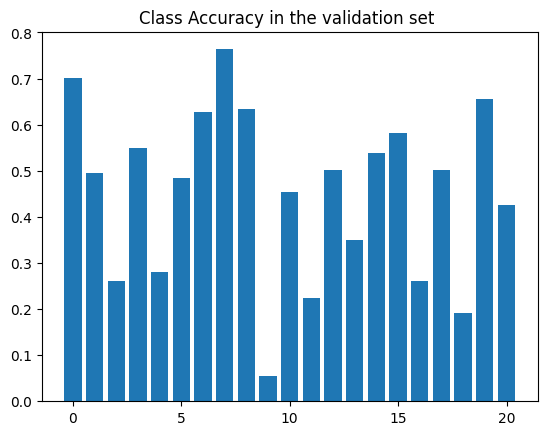


Test set (736): Average loss: 0.7925, mIoU: 0.4541

PSPnetLite training, epoch 2
Train Epoch: 2 [240/8498 (3%)]	Loss: 0.497175, Learning rate: 0.001000
Train Epoch: 2 [480/8498 (6%)]	Loss: 0.996837, Learning rate: 0.001000
Train Epoch: 2 [720/8498 (8%)]	Loss: 0.801542, Learning rate: 0.001000
Train Epoch: 2 [960/8498 (11%)]	Loss: 0.557240, Learning rate: 0.001000
Train Epoch: 2 [1200/8498 (14%)]	Loss: 0.574233, Learning rate: 0.001000
Train Epoch: 2 [1440/8498 (17%)]	Loss: 1.044631, Learning rate: 0.001000
Train Epoch: 2 [1680/8498 (20%)]	Loss: 0.784114, Learning rate: 0.001000
Train Epoch: 2 [1920/8498 (23%)]	Loss: 0.547003, Learning rate: 0.001000
Train Epoch: 2 [2160/8498 (25%)]	Loss: 0.836906, Learning rate: 0.001000
Train Epoch: 2 [2400/8498 (28%)]	Loss: 0.642784, Learning rate: 0.001000
Train Epoch: 2 [2640/8498 (31%)]	Loss: 0.639997, Learning rate: 0.001000
Train Epoch: 2 [2880/8498 (34%)]	Loss: 0.792337, Learning rate: 0.001000
Train Epoch: 2 [3120/8498 (37%)]	Loss: 0.781647, 

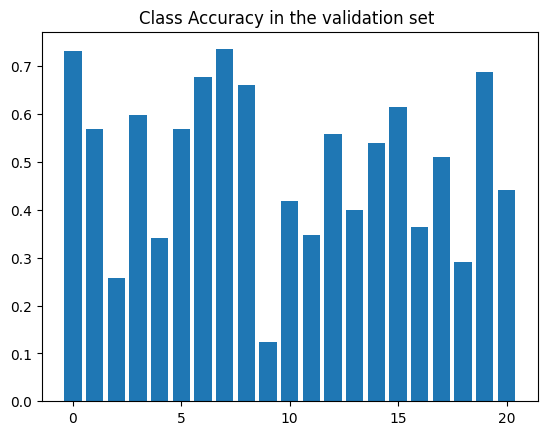


Test set (736): Average loss: 0.7506, mIoU: 0.4970

PSPnetLite training, epoch 3
Train Epoch: 3 [240/8498 (3%)]	Loss: 0.605900, Learning rate: 0.001000
Train Epoch: 3 [480/8498 (6%)]	Loss: 0.672059, Learning rate: 0.001000
Train Epoch: 3 [720/8498 (8%)]	Loss: 0.914777, Learning rate: 0.001000
Train Epoch: 3 [960/8498 (11%)]	Loss: 0.505858, Learning rate: 0.001000
Train Epoch: 3 [1200/8498 (14%)]	Loss: 0.540734, Learning rate: 0.001000
Train Epoch: 3 [1440/8498 (17%)]	Loss: 0.494416, Learning rate: 0.001000
Train Epoch: 3 [1680/8498 (20%)]	Loss: 0.627653, Learning rate: 0.001000
Train Epoch: 3 [1920/8498 (23%)]	Loss: 0.557789, Learning rate: 0.001000
Train Epoch: 3 [2160/8498 (25%)]	Loss: 0.559244, Learning rate: 0.001000
Train Epoch: 3 [2400/8498 (28%)]	Loss: 0.528037, Learning rate: 0.001000
Train Epoch: 3 [2640/8498 (31%)]	Loss: 0.438162, Learning rate: 0.001000
Train Epoch: 3 [2880/8498 (34%)]	Loss: 0.457497, Learning rate: 0.001000
Train Epoch: 3 [3120/8498 (37%)]	Loss: 0.671157, 

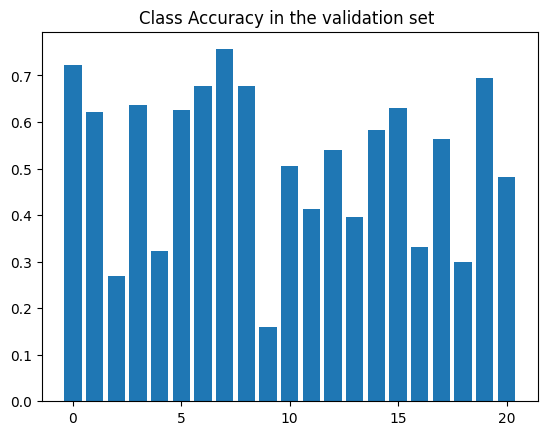


Test set (736): Average loss: 0.7226, mIoU: 0.5193

PSPnetLite training, epoch 4
Train Epoch: 4 [240/8498 (3%)]	Loss: 0.577323, Learning rate: 0.001000
Train Epoch: 4 [480/8498 (6%)]	Loss: 1.256836, Learning rate: 0.001000
Train Epoch: 4 [720/8498 (8%)]	Loss: 0.580744, Learning rate: 0.001000
Train Epoch: 4 [960/8498 (11%)]	Loss: 0.777224, Learning rate: 0.001000
Train Epoch: 4 [1200/8498 (14%)]	Loss: 0.688571, Learning rate: 0.001000
Train Epoch: 4 [1440/8498 (17%)]	Loss: 0.481777, Learning rate: 0.001000
Train Epoch: 4 [1680/8498 (20%)]	Loss: 0.630510, Learning rate: 0.001000
Train Epoch: 4 [1920/8498 (23%)]	Loss: 0.731274, Learning rate: 0.001000
Train Epoch: 4 [2160/8498 (25%)]	Loss: 0.603421, Learning rate: 0.001000
Train Epoch: 4 [2400/8498 (28%)]	Loss: 0.586423, Learning rate: 0.001000
Train Epoch: 4 [2640/8498 (31%)]	Loss: 0.513972, Learning rate: 0.001000
Train Epoch: 4 [2880/8498 (34%)]	Loss: 0.507812, Learning rate: 0.001000
Train Epoch: 4 [3120/8498 (37%)]	Loss: 0.509283, 

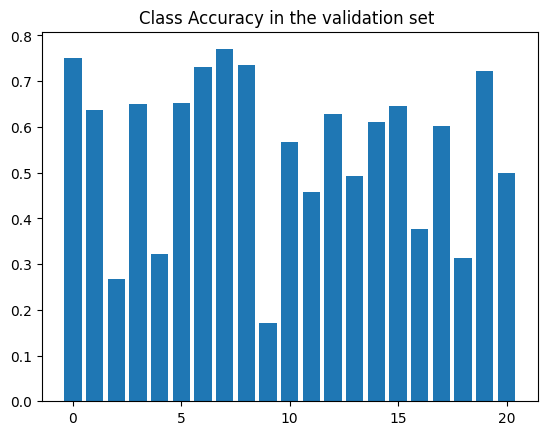


Test set (736): Average loss: 0.6809, mIoU: 0.5525

PSPnetLite training, epoch 5
Train Epoch: 5 [240/8498 (3%)]	Loss: 0.464554, Learning rate: 0.001000
Train Epoch: 5 [480/8498 (6%)]	Loss: 0.472612, Learning rate: 0.001000
Train Epoch: 5 [720/8498 (8%)]	Loss: 0.931492, Learning rate: 0.001000
Train Epoch: 5 [960/8498 (11%)]	Loss: 0.897862, Learning rate: 0.001000
Train Epoch: 5 [1200/8498 (14%)]	Loss: 0.726698, Learning rate: 0.001000
Train Epoch: 5 [1440/8498 (17%)]	Loss: 0.623618, Learning rate: 0.001000
Train Epoch: 5 [1680/8498 (20%)]	Loss: 0.472944, Learning rate: 0.001000
Train Epoch: 5 [1920/8498 (23%)]	Loss: 0.829821, Learning rate: 0.001000
Train Epoch: 5 [2160/8498 (25%)]	Loss: 0.546800, Learning rate: 0.001000
Train Epoch: 5 [2400/8498 (28%)]	Loss: 0.698673, Learning rate: 0.001000
Train Epoch: 5 [2640/8498 (31%)]	Loss: 0.605461, Learning rate: 0.001000
Train Epoch: 5 [2880/8498 (34%)]	Loss: 0.739100, Learning rate: 0.001000
Train Epoch: 5 [3120/8498 (37%)]	Loss: 0.609991, 

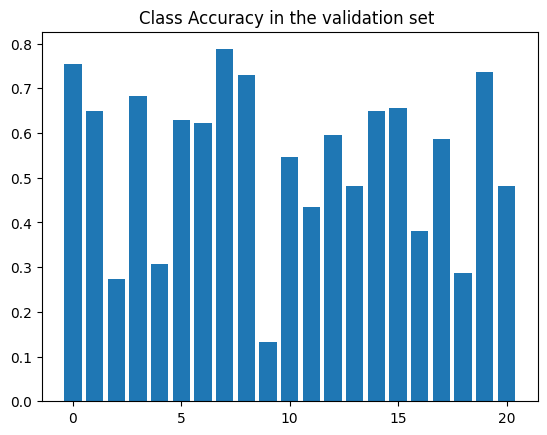


Test set (736): Average loss: 0.6897, mIoU: 0.5431

PSPnetLite training, epoch 6
Train Epoch: 6 [240/8498 (3%)]	Loss: 0.459780, Learning rate: 0.001000
Train Epoch: 6 [480/8498 (6%)]	Loss: 0.640922, Learning rate: 0.001000
Train Epoch: 6 [720/8498 (8%)]	Loss: 0.489716, Learning rate: 0.001000
Train Epoch: 6 [960/8498 (11%)]	Loss: 0.737806, Learning rate: 0.001000
Train Epoch: 6 [1200/8498 (14%)]	Loss: 0.503393, Learning rate: 0.001000
Train Epoch: 6 [1440/8498 (17%)]	Loss: 0.490373, Learning rate: 0.001000
Train Epoch: 6 [1680/8498 (20%)]	Loss: 0.460861, Learning rate: 0.001000
Train Epoch: 6 [1920/8498 (23%)]	Loss: 0.593300, Learning rate: 0.001000
Train Epoch: 6 [2160/8498 (25%)]	Loss: 0.538540, Learning rate: 0.001000
Train Epoch: 6 [2400/8498 (28%)]	Loss: 0.520421, Learning rate: 0.001000
Train Epoch: 6 [2640/8498 (31%)]	Loss: 0.688791, Learning rate: 0.001000
Train Epoch: 6 [2880/8498 (34%)]	Loss: 0.640848, Learning rate: 0.001000
Train Epoch: 6 [3120/8498 (37%)]	Loss: 0.415494, 

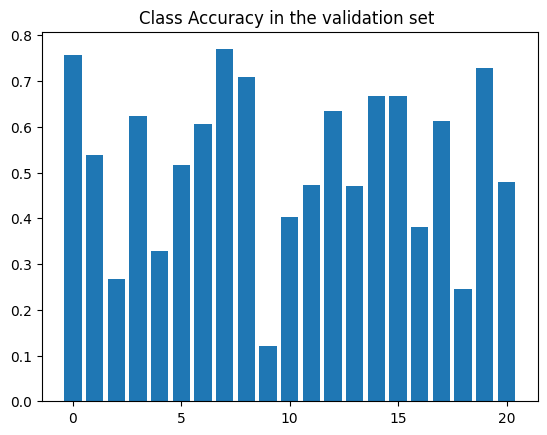


Test set (736): Average loss: 0.6965, mIoU: 0.5239

PSPnetLite training, epoch 7
Train Epoch: 7 [240/8498 (3%)]	Loss: 0.445240, Learning rate: 0.001000
Train Epoch: 7 [480/8498 (6%)]	Loss: 0.509792, Learning rate: 0.001000
Train Epoch: 7 [720/8498 (8%)]	Loss: 0.420463, Learning rate: 0.001000
Train Epoch: 7 [960/8498 (11%)]	Loss: 0.380331, Learning rate: 0.001000
Train Epoch: 7 [1200/8498 (14%)]	Loss: 0.576115, Learning rate: 0.001000
Train Epoch: 7 [1440/8498 (17%)]	Loss: 0.464493, Learning rate: 0.001000
Train Epoch: 7 [1680/8498 (20%)]	Loss: 0.520112, Learning rate: 0.001000
Train Epoch: 7 [1920/8498 (23%)]	Loss: 0.562688, Learning rate: 0.001000
Train Epoch: 7 [2160/8498 (25%)]	Loss: 0.445153, Learning rate: 0.001000
Train Epoch: 7 [2400/8498 (28%)]	Loss: 0.485819, Learning rate: 0.001000
Train Epoch: 7 [2640/8498 (31%)]	Loss: 0.469325, Learning rate: 0.001000
Train Epoch: 7 [2880/8498 (34%)]	Loss: 0.459072, Learning rate: 0.001000
Train Epoch: 7 [3120/8498 (37%)]	Loss: 0.406094, 

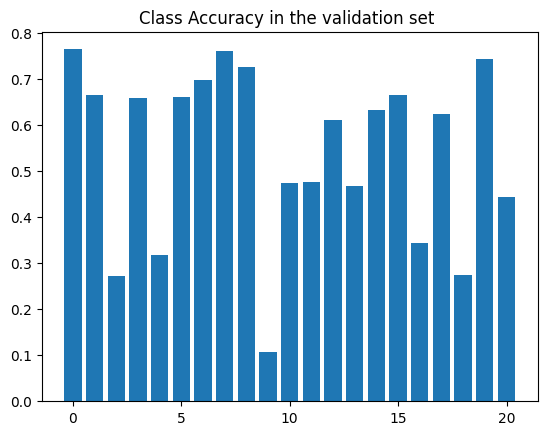


Test set (736): Average loss: 0.6388, mIoU: 0.5425

PSPnetLite training, epoch 8
Train Epoch: 8 [240/8498 (3%)]	Loss: 0.360664, Learning rate: 0.001000
Train Epoch: 8 [480/8498 (6%)]	Loss: 0.759032, Learning rate: 0.001000
Train Epoch: 8 [720/8498 (8%)]	Loss: 0.386253, Learning rate: 0.001000
Train Epoch: 8 [960/8498 (11%)]	Loss: 0.562856, Learning rate: 0.001000
Train Epoch: 8 [1200/8498 (14%)]	Loss: 0.488030, Learning rate: 0.001000
Train Epoch: 8 [1440/8498 (17%)]	Loss: 0.480519, Learning rate: 0.001000
Train Epoch: 8 [1680/8498 (20%)]	Loss: 0.486104, Learning rate: 0.001000
Train Epoch: 8 [1920/8498 (23%)]	Loss: 0.398414, Learning rate: 0.001000
Train Epoch: 8 [2160/8498 (25%)]	Loss: 0.553803, Learning rate: 0.001000
Train Epoch: 8 [2400/8498 (28%)]	Loss: 0.548097, Learning rate: 0.001000
Train Epoch: 8 [2640/8498 (31%)]	Loss: 0.426361, Learning rate: 0.001000
Train Epoch: 8 [2880/8498 (34%)]	Loss: 0.712090, Learning rate: 0.001000
Train Epoch: 8 [3120/8498 (37%)]	Loss: 0.494491, 

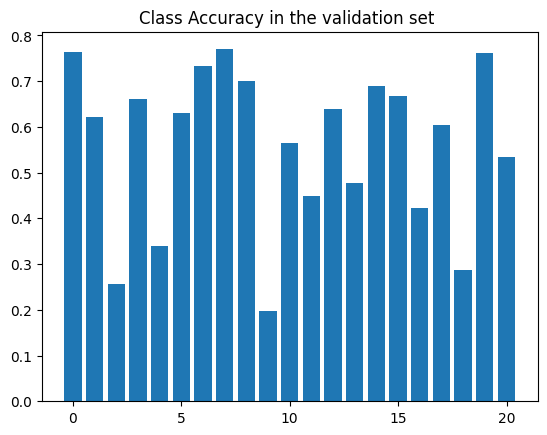


Test set (736): Average loss: 0.6219, mIoU: 0.5604

PSPnetLite training, epoch 9
Train Epoch: 9 [240/8498 (3%)]	Loss: 0.444767, Learning rate: 0.001000
Train Epoch: 9 [480/8498 (6%)]	Loss: 0.392186, Learning rate: 0.001000
Train Epoch: 9 [720/8498 (8%)]	Loss: 0.335905, Learning rate: 0.001000
Train Epoch: 9 [960/8498 (11%)]	Loss: 0.567244, Learning rate: 0.001000
Train Epoch: 9 [1200/8498 (14%)]	Loss: 0.431464, Learning rate: 0.001000
Train Epoch: 9 [1440/8498 (17%)]	Loss: 0.499171, Learning rate: 0.001000
Train Epoch: 9 [1680/8498 (20%)]	Loss: 0.391443, Learning rate: 0.001000
Train Epoch: 9 [1920/8498 (23%)]	Loss: 0.664124, Learning rate: 0.001000
Train Epoch: 9 [2160/8498 (25%)]	Loss: 0.493137, Learning rate: 0.001000
Train Epoch: 9 [2400/8498 (28%)]	Loss: 0.554511, Learning rate: 0.001000
Train Epoch: 9 [2640/8498 (31%)]	Loss: 0.517566, Learning rate: 0.001000
Train Epoch: 9 [2880/8498 (34%)]	Loss: 0.365676, Learning rate: 0.001000
Train Epoch: 9 [3120/8498 (37%)]	Loss: 0.395714, 

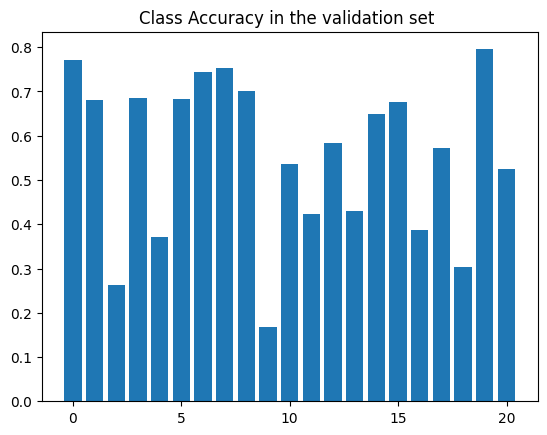


Test set (736): Average loss: 0.6578, mIoU: 0.5572

PSPnetLite training, epoch 10
Train Epoch: 10 [240/8498 (3%)]	Loss: 0.346568, Learning rate: 0.001000
Train Epoch: 10 [480/8498 (6%)]	Loss: 0.303509, Learning rate: 0.001000
Train Epoch: 10 [720/8498 (8%)]	Loss: 0.467760, Learning rate: 0.001000
Train Epoch: 10 [960/8498 (11%)]	Loss: 0.429296, Learning rate: 0.001000
Train Epoch: 10 [1200/8498 (14%)]	Loss: 0.391037, Learning rate: 0.001000
Train Epoch: 10 [1440/8498 (17%)]	Loss: 0.440703, Learning rate: 0.001000
Train Epoch: 10 [1680/8498 (20%)]	Loss: 0.531755, Learning rate: 0.001000
Train Epoch: 10 [1920/8498 (23%)]	Loss: 0.348214, Learning rate: 0.001000
Train Epoch: 10 [2160/8498 (25%)]	Loss: 0.411444, Learning rate: 0.001000
Train Epoch: 10 [2400/8498 (28%)]	Loss: 0.489894, Learning rate: 0.001000
Train Epoch: 10 [2640/8498 (31%)]	Loss: 0.516910, Learning rate: 0.001000
Train Epoch: 10 [2880/8498 (34%)]	Loss: 0.509218, Learning rate: 0.001000
Train Epoch: 10 [3120/8498 (37%)]	Lo

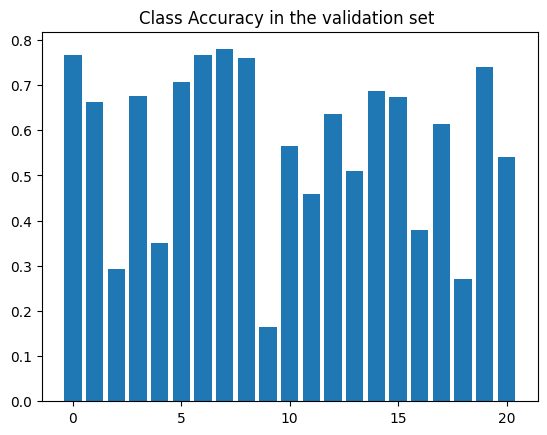


Test set (736): Average loss: 0.6368, mIoU: 0.5714

PSPnetLite training, epoch 11
Train Epoch: 11 [240/8498 (3%)]	Loss: 0.421855, Learning rate: 0.001000
Train Epoch: 11 [480/8498 (6%)]	Loss: 0.490805, Learning rate: 0.001000
Train Epoch: 11 [720/8498 (8%)]	Loss: 0.812255, Learning rate: 0.001000
Train Epoch: 11 [960/8498 (11%)]	Loss: 0.401266, Learning rate: 0.001000
Train Epoch: 11 [1200/8498 (14%)]	Loss: 0.458870, Learning rate: 0.001000
Train Epoch: 11 [1440/8498 (17%)]	Loss: 0.484851, Learning rate: 0.001000
Train Epoch: 11 [1680/8498 (20%)]	Loss: 0.661431, Learning rate: 0.001000
Train Epoch: 11 [1920/8498 (23%)]	Loss: 0.383830, Learning rate: 0.001000
Train Epoch: 11 [2160/8498 (25%)]	Loss: 0.487923, Learning rate: 0.001000
Train Epoch: 11 [2400/8498 (28%)]	Loss: 0.595553, Learning rate: 0.001000
Train Epoch: 11 [2640/8498 (31%)]	Loss: 0.603530, Learning rate: 0.001000
Train Epoch: 11 [2880/8498 (34%)]	Loss: 0.520180, Learning rate: 0.001000
Train Epoch: 11 [3120/8498 (37%)]	Lo

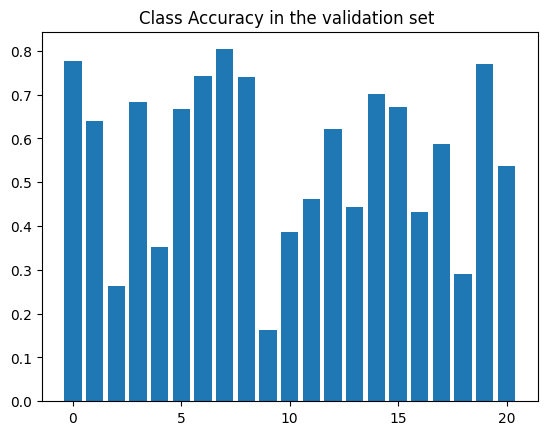


Test set (736): Average loss: 0.6189, mIoU: 0.5589

PSPnetLite training, epoch 12
Train Epoch: 12 [240/8498 (3%)]	Loss: 0.342110, Learning rate: 0.001000
Train Epoch: 12 [480/8498 (6%)]	Loss: 0.504739, Learning rate: 0.001000
Train Epoch: 12 [720/8498 (8%)]	Loss: 0.456476, Learning rate: 0.001000
Train Epoch: 12 [960/8498 (11%)]	Loss: 0.389586, Learning rate: 0.001000
Train Epoch: 12 [1200/8498 (14%)]	Loss: 0.349009, Learning rate: 0.001000
Train Epoch: 12 [1440/8498 (17%)]	Loss: 0.405627, Learning rate: 0.001000
Train Epoch: 12 [1680/8498 (20%)]	Loss: 0.408354, Learning rate: 0.001000
Train Epoch: 12 [1920/8498 (23%)]	Loss: 0.622198, Learning rate: 0.001000
Train Epoch: 12 [2160/8498 (25%)]	Loss: 0.424044, Learning rate: 0.001000
Train Epoch: 12 [2400/8498 (28%)]	Loss: 0.500145, Learning rate: 0.001000
Train Epoch: 12 [2640/8498 (31%)]	Loss: 0.287594, Learning rate: 0.001000
Train Epoch: 12 [2880/8498 (34%)]	Loss: 0.389312, Learning rate: 0.001000
Train Epoch: 12 [3120/8498 (37%)]	Lo

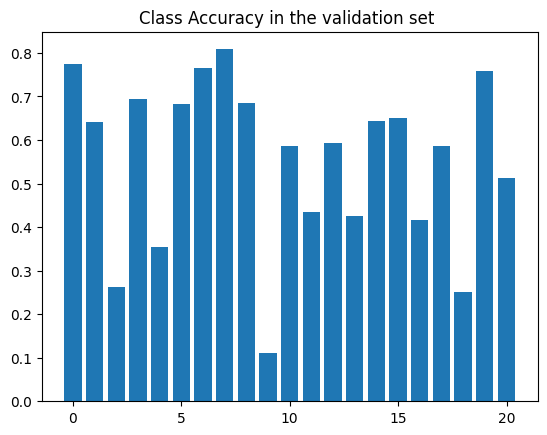


Test set (736): Average loss: 0.6376, mIoU: 0.5539

PSPnetLite training, epoch 13
Train Epoch: 13 [240/8498 (3%)]	Loss: 0.533556, Learning rate: 0.001000
Train Epoch: 13 [480/8498 (6%)]	Loss: 0.373930, Learning rate: 0.001000
Train Epoch: 13 [720/8498 (8%)]	Loss: 0.473252, Learning rate: 0.001000
Train Epoch: 13 [960/8498 (11%)]	Loss: 0.471253, Learning rate: 0.001000
Train Epoch: 13 [1200/8498 (14%)]	Loss: 0.319536, Learning rate: 0.001000
Train Epoch: 13 [1440/8498 (17%)]	Loss: 0.464924, Learning rate: 0.001000
Train Epoch: 13 [1680/8498 (20%)]	Loss: 0.396018, Learning rate: 0.001000
Train Epoch: 13 [1920/8498 (23%)]	Loss: 0.462165, Learning rate: 0.001000
Train Epoch: 13 [2160/8498 (25%)]	Loss: 0.480750, Learning rate: 0.001000
Train Epoch: 13 [2400/8498 (28%)]	Loss: 0.601673, Learning rate: 0.001000
Train Epoch: 13 [2640/8498 (31%)]	Loss: 0.430847, Learning rate: 0.001000
Train Epoch: 13 [2880/8498 (34%)]	Loss: 0.387303, Learning rate: 0.001000
Train Epoch: 13 [3120/8498 (37%)]	Lo

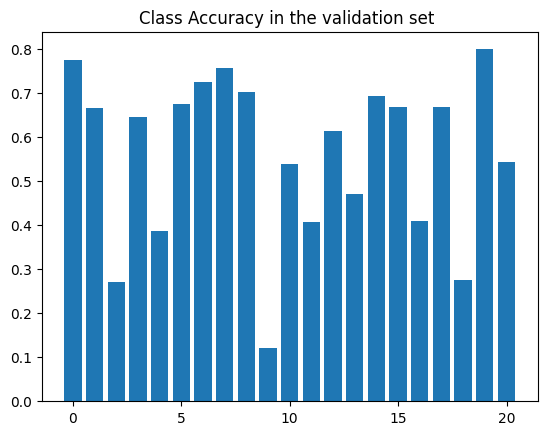


Test set (736): Average loss: 0.6572, mIoU: 0.5624

PSPnetLite training, epoch 14
Train Epoch: 14 [240/8498 (3%)]	Loss: 0.419814, Learning rate: 0.001000
Train Epoch: 14 [480/8498 (6%)]	Loss: 0.304804, Learning rate: 0.001000
Train Epoch: 14 [720/8498 (8%)]	Loss: 0.383859, Learning rate: 0.001000
Train Epoch: 14 [960/8498 (11%)]	Loss: 0.572918, Learning rate: 0.001000
Train Epoch: 14 [1200/8498 (14%)]	Loss: 0.315437, Learning rate: 0.001000
Train Epoch: 14 [1440/8498 (17%)]	Loss: 0.287882, Learning rate: 0.001000
Train Epoch: 14 [1680/8498 (20%)]	Loss: 0.383272, Learning rate: 0.001000
Train Epoch: 14 [1920/8498 (23%)]	Loss: 0.393340, Learning rate: 0.001000
Train Epoch: 14 [2160/8498 (25%)]	Loss: 0.335403, Learning rate: 0.001000
Train Epoch: 14 [2400/8498 (28%)]	Loss: 0.240049, Learning rate: 0.001000
Train Epoch: 14 [2640/8498 (31%)]	Loss: 0.361570, Learning rate: 0.001000
Train Epoch: 14 [2880/8498 (34%)]	Loss: 0.449453, Learning rate: 0.001000
Train Epoch: 14 [3120/8498 (37%)]	Lo

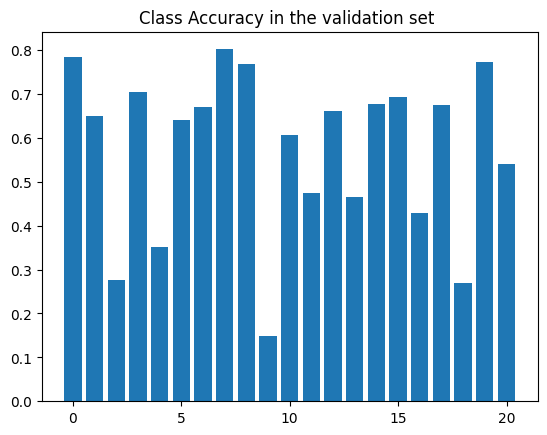


Test set (736): Average loss: 0.5998, mIoU: 0.5738

PSPnetLite training, epoch 15
Train Epoch: 15 [240/8498 (3%)]	Loss: 0.320903, Learning rate: 0.001000
Train Epoch: 15 [480/8498 (6%)]	Loss: 0.318662, Learning rate: 0.001000
Train Epoch: 15 [720/8498 (8%)]	Loss: 0.405702, Learning rate: 0.001000
Train Epoch: 15 [960/8498 (11%)]	Loss: 0.305399, Learning rate: 0.001000
Train Epoch: 15 [1200/8498 (14%)]	Loss: 0.420861, Learning rate: 0.001000
Train Epoch: 15 [1440/8498 (17%)]	Loss: 0.497324, Learning rate: 0.001000
Train Epoch: 15 [1680/8498 (20%)]	Loss: 0.431516, Learning rate: 0.001000
Train Epoch: 15 [1920/8498 (23%)]	Loss: 0.233544, Learning rate: 0.001000
Train Epoch: 15 [2160/8498 (25%)]	Loss: 0.440810, Learning rate: 0.001000
Train Epoch: 15 [2400/8498 (28%)]	Loss: 0.487332, Learning rate: 0.001000
Train Epoch: 15 [2640/8498 (31%)]	Loss: 0.410286, Learning rate: 0.001000
Train Epoch: 15 [2880/8498 (34%)]	Loss: 0.380147, Learning rate: 0.001000
Train Epoch: 15 [3120/8498 (37%)]	Lo

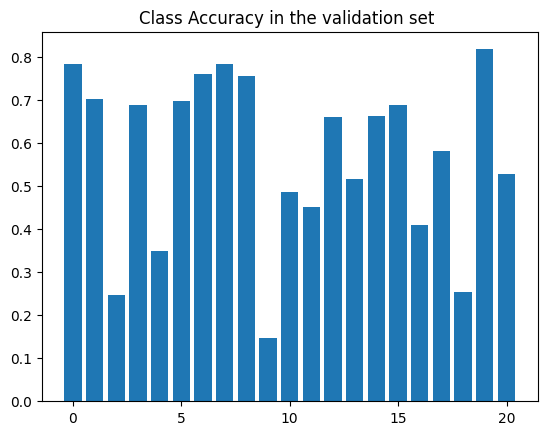


Test set (736): Average loss: 0.5974, mIoU: 0.5698

PSPnetLite training, epoch 16
Train Epoch: 16 [240/8498 (3%)]	Loss: 0.585524, Learning rate: 0.001000
Train Epoch: 16 [480/8498 (6%)]	Loss: 0.418287, Learning rate: 0.001000
Train Epoch: 16 [720/8498 (8%)]	Loss: 0.563268, Learning rate: 0.001000
Train Epoch: 16 [960/8498 (11%)]	Loss: 0.470306, Learning rate: 0.001000
Train Epoch: 16 [1200/8498 (14%)]	Loss: 0.421790, Learning rate: 0.001000
Train Epoch: 16 [1440/8498 (17%)]	Loss: 0.420251, Learning rate: 0.001000
Train Epoch: 16 [1680/8498 (20%)]	Loss: 0.364918, Learning rate: 0.001000
Train Epoch: 16 [1920/8498 (23%)]	Loss: 0.327424, Learning rate: 0.001000
Train Epoch: 16 [2160/8498 (25%)]	Loss: 0.402337, Learning rate: 0.001000
Train Epoch: 16 [2400/8498 (28%)]	Loss: 0.545519, Learning rate: 0.001000
Train Epoch: 16 [2640/8498 (31%)]	Loss: 0.451991, Learning rate: 0.001000
Train Epoch: 16 [2880/8498 (34%)]	Loss: 0.288459, Learning rate: 0.001000
Train Epoch: 16 [3120/8498 (37%)]	Lo

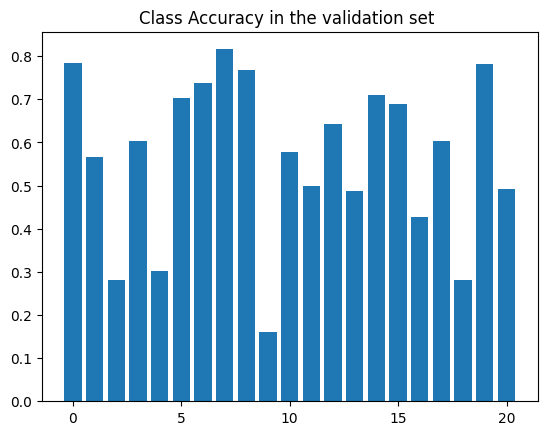


Test set (736): Average loss: 0.6027, mIoU: 0.5673

PSPnetLite training, epoch 17
Train Epoch: 17 [240/8498 (3%)]	Loss: 0.434508, Learning rate: 0.001000
Train Epoch: 17 [480/8498 (6%)]	Loss: 0.595136, Learning rate: 0.001000
Train Epoch: 17 [720/8498 (8%)]	Loss: 0.241156, Learning rate: 0.001000
Train Epoch: 17 [960/8498 (11%)]	Loss: 0.387649, Learning rate: 0.001000
Train Epoch: 17 [1200/8498 (14%)]	Loss: 0.420827, Learning rate: 0.001000
Train Epoch: 17 [1440/8498 (17%)]	Loss: 0.290375, Learning rate: 0.001000
Train Epoch: 17 [1680/8498 (20%)]	Loss: 0.293048, Learning rate: 0.001000
Train Epoch: 17 [1920/8498 (23%)]	Loss: 0.357236, Learning rate: 0.001000
Train Epoch: 17 [2160/8498 (25%)]	Loss: 0.368263, Learning rate: 0.001000
Train Epoch: 17 [2400/8498 (28%)]	Loss: 0.498725, Learning rate: 0.001000
Train Epoch: 17 [2640/8498 (31%)]	Loss: 0.404526, Learning rate: 0.001000
Train Epoch: 17 [2880/8498 (34%)]	Loss: 0.468013, Learning rate: 0.001000
Train Epoch: 17 [3120/8498 (37%)]	Lo

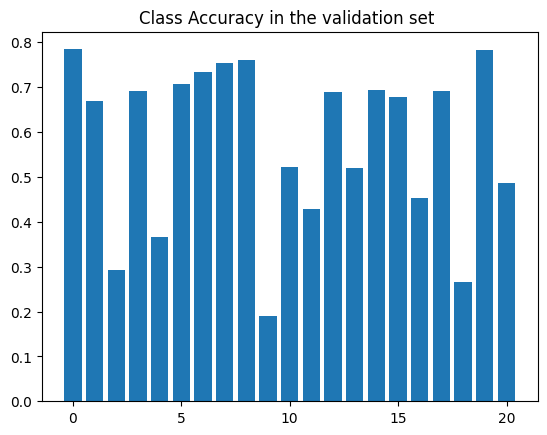


Test set (736): Average loss: 0.6266, mIoU: 0.5791

PSPnetLite training, epoch 18
Train Epoch: 18 [240/8498 (3%)]	Loss: 0.390068, Learning rate: 0.001000
Train Epoch: 18 [480/8498 (6%)]	Loss: 0.487591, Learning rate: 0.001000
Train Epoch: 18 [720/8498 (8%)]	Loss: 0.340446, Learning rate: 0.001000
Train Epoch: 18 [960/8498 (11%)]	Loss: 0.421835, Learning rate: 0.001000
Train Epoch: 18 [1200/8498 (14%)]	Loss: 0.301735, Learning rate: 0.001000
Train Epoch: 18 [1440/8498 (17%)]	Loss: 0.391393, Learning rate: 0.001000
Train Epoch: 18 [1680/8498 (20%)]	Loss: 0.570068, Learning rate: 0.001000
Train Epoch: 18 [1920/8498 (23%)]	Loss: 0.426219, Learning rate: 0.001000
Train Epoch: 18 [2160/8498 (25%)]	Loss: 0.487142, Learning rate: 0.001000
Train Epoch: 18 [2400/8498 (28%)]	Loss: 0.381094, Learning rate: 0.001000
Train Epoch: 18 [2640/8498 (31%)]	Loss: 0.533648, Learning rate: 0.001000
Train Epoch: 18 [2880/8498 (34%)]	Loss: 0.425805, Learning rate: 0.001000
Train Epoch: 18 [3120/8498 (37%)]	Lo

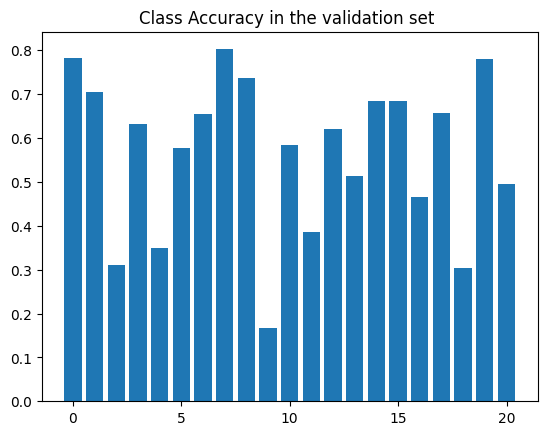


Test set (736): Average loss: 0.6098, mIoU: 0.5665

PSPnetLite training, epoch 19
Train Epoch: 19 [240/8498 (3%)]	Loss: 0.445387, Learning rate: 0.001000
Train Epoch: 19 [480/8498 (6%)]	Loss: 0.500330, Learning rate: 0.001000
Train Epoch: 19 [720/8498 (8%)]	Loss: 0.282876, Learning rate: 0.001000
Train Epoch: 19 [960/8498 (11%)]	Loss: 0.487395, Learning rate: 0.001000
Train Epoch: 19 [1200/8498 (14%)]	Loss: 0.638849, Learning rate: 0.001000
Train Epoch: 19 [1440/8498 (17%)]	Loss: 0.328740, Learning rate: 0.001000
Train Epoch: 19 [1680/8498 (20%)]	Loss: 0.355416, Learning rate: 0.001000
Train Epoch: 19 [1920/8498 (23%)]	Loss: 0.426548, Learning rate: 0.001000
Train Epoch: 19 [2160/8498 (25%)]	Loss: 0.445293, Learning rate: 0.001000
Train Epoch: 19 [2400/8498 (28%)]	Loss: 0.319593, Learning rate: 0.001000
Train Epoch: 19 [2640/8498 (31%)]	Loss: 0.388052, Learning rate: 0.001000
Train Epoch: 19 [2880/8498 (34%)]	Loss: 0.284659, Learning rate: 0.001000
Train Epoch: 19 [3120/8498 (37%)]	Lo

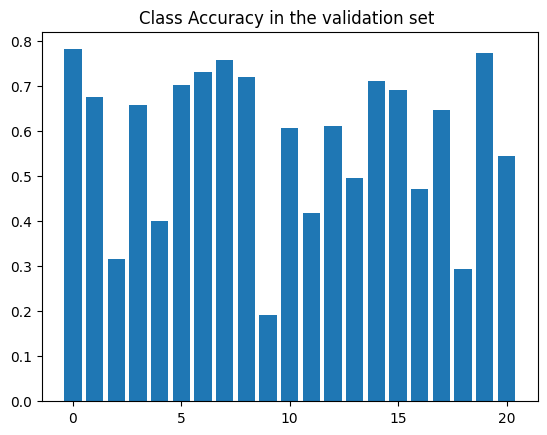


Test set (736): Average loss: 0.6272, mIoU: 0.5808

PSPnetLite training, epoch 20
Train Epoch: 20 [240/8498 (3%)]	Loss: 0.466387, Learning rate: 0.001000
Train Epoch: 20 [480/8498 (6%)]	Loss: 0.506438, Learning rate: 0.001000
Train Epoch: 20 [720/8498 (8%)]	Loss: 0.427158, Learning rate: 0.001000
Train Epoch: 20 [960/8498 (11%)]	Loss: 0.282957, Learning rate: 0.001000
Train Epoch: 20 [1200/8498 (14%)]	Loss: 0.376264, Learning rate: 0.001000
Train Epoch: 20 [1440/8498 (17%)]	Loss: 0.279072, Learning rate: 0.001000
Train Epoch: 20 [1680/8498 (20%)]	Loss: 0.353714, Learning rate: 0.001000
Train Epoch: 20 [1920/8498 (23%)]	Loss: 0.375570, Learning rate: 0.001000
Train Epoch: 20 [2160/8498 (25%)]	Loss: 0.405677, Learning rate: 0.001000
Train Epoch: 20 [2400/8498 (28%)]	Loss: 0.255111, Learning rate: 0.001000
Train Epoch: 20 [2640/8498 (31%)]	Loss: 0.411130, Learning rate: 0.001000
Train Epoch: 20 [2880/8498 (34%)]	Loss: 0.319655, Learning rate: 0.001000
Train Epoch: 20 [3120/8498 (37%)]	Lo

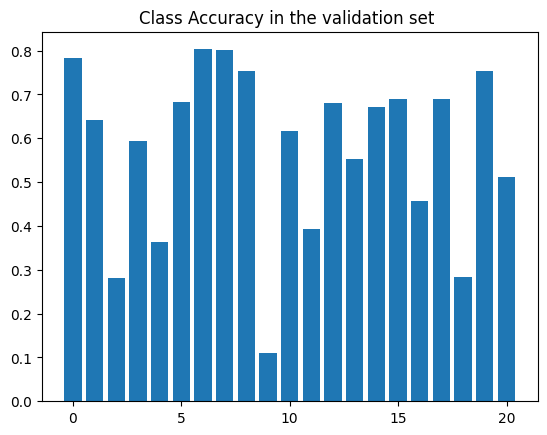


Test set (736): Average loss: 0.6407, mIoU: 0.5768

PSPnetLite training, epoch 21
Train Epoch: 21 [240/8498 (3%)]	Loss: 0.387792, Learning rate: 0.001000
Train Epoch: 21 [480/8498 (6%)]	Loss: 0.284431, Learning rate: 0.001000
Train Epoch: 21 [720/8498 (8%)]	Loss: 0.558602, Learning rate: 0.001000
Train Epoch: 21 [960/8498 (11%)]	Loss: 0.342716, Learning rate: 0.001000
Train Epoch: 21 [1200/8498 (14%)]	Loss: 0.477710, Learning rate: 0.001000
Train Epoch: 21 [1440/8498 (17%)]	Loss: 0.254807, Learning rate: 0.001000
Train Epoch: 21 [1680/8498 (20%)]	Loss: 0.351906, Learning rate: 0.001000
Train Epoch: 21 [1920/8498 (23%)]	Loss: 0.360273, Learning rate: 0.001000
Train Epoch: 21 [2160/8498 (25%)]	Loss: 0.326299, Learning rate: 0.001000
Train Epoch: 21 [2400/8498 (28%)]	Loss: 0.374769, Learning rate: 0.001000
Train Epoch: 21 [2640/8498 (31%)]	Loss: 0.370218, Learning rate: 0.001000
Train Epoch: 21 [2880/8498 (34%)]	Loss: 0.321145, Learning rate: 0.001000
Train Epoch: 21 [3120/8498 (37%)]	Lo

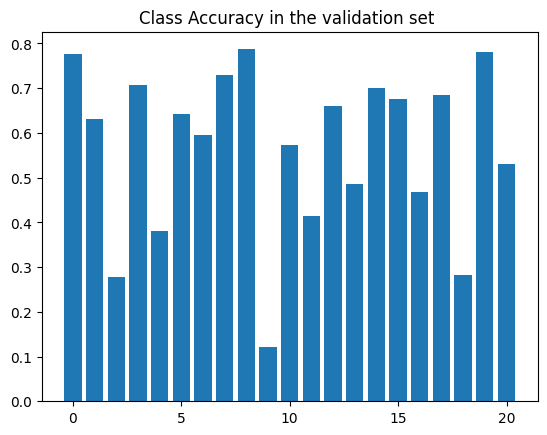


Test set (736): Average loss: 0.6365, mIoU: 0.5668

PSPnetLite training, epoch 22
Train Epoch: 22 [240/8498 (3%)]	Loss: 0.375085, Learning rate: 0.001000
Train Epoch: 22 [480/8498 (6%)]	Loss: 0.347378, Learning rate: 0.001000
Train Epoch: 22 [720/8498 (8%)]	Loss: 0.337775, Learning rate: 0.001000
Train Epoch: 22 [960/8498 (11%)]	Loss: 0.558937, Learning rate: 0.001000
Train Epoch: 22 [1200/8498 (14%)]	Loss: 0.344151, Learning rate: 0.001000
Train Epoch: 22 [1440/8498 (17%)]	Loss: 0.286828, Learning rate: 0.001000
Train Epoch: 22 [1680/8498 (20%)]	Loss: 0.414924, Learning rate: 0.001000
Train Epoch: 22 [1920/8498 (23%)]	Loss: 0.473911, Learning rate: 0.001000
Train Epoch: 22 [2160/8498 (25%)]	Loss: 0.465005, Learning rate: 0.001000
Train Epoch: 22 [2400/8498 (28%)]	Loss: 0.302647, Learning rate: 0.001000
Train Epoch: 22 [2640/8498 (31%)]	Loss: 0.368938, Learning rate: 0.001000
Train Epoch: 22 [2880/8498 (34%)]	Loss: 0.444834, Learning rate: 0.001000
Train Epoch: 22 [3120/8498 (37%)]	Lo

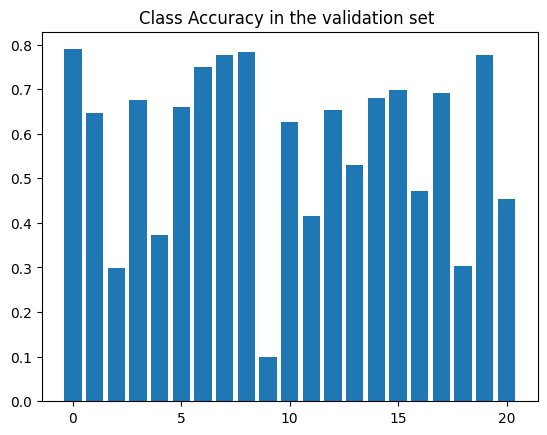


Test set (736): Average loss: 0.6088, mIoU: 0.5788

PSPnetLite training, epoch 23
Train Epoch: 23 [240/8498 (3%)]	Loss: 0.349757, Learning rate: 0.001000
Train Epoch: 23 [480/8498 (6%)]	Loss: 0.350071, Learning rate: 0.001000
Train Epoch: 23 [720/8498 (8%)]	Loss: 0.465569, Learning rate: 0.001000
Train Epoch: 23 [960/8498 (11%)]	Loss: 0.394878, Learning rate: 0.001000
Train Epoch: 23 [1200/8498 (14%)]	Loss: 0.286376, Learning rate: 0.001000
Train Epoch: 23 [1440/8498 (17%)]	Loss: 0.284742, Learning rate: 0.001000
Train Epoch: 23 [1680/8498 (20%)]	Loss: 0.405255, Learning rate: 0.001000
Train Epoch: 23 [1920/8498 (23%)]	Loss: 0.337933, Learning rate: 0.001000
Train Epoch: 23 [2160/8498 (25%)]	Loss: 0.379241, Learning rate: 0.001000
Train Epoch: 23 [2400/8498 (28%)]	Loss: 0.480871, Learning rate: 0.001000
Train Epoch: 23 [2640/8498 (31%)]	Loss: 0.300649, Learning rate: 0.001000
Train Epoch: 23 [2880/8498 (34%)]	Loss: 0.430926, Learning rate: 0.001000
Train Epoch: 23 [3120/8498 (37%)]	Lo

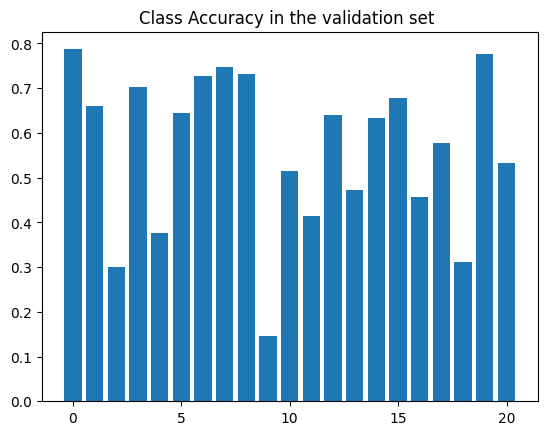


Test set (736): Average loss: 0.6335, mIoU: 0.5633

PSPnetLite training, epoch 24
Train Epoch: 24 [240/8498 (3%)]	Loss: 0.413186, Learning rate: 0.001000
Train Epoch: 24 [480/8498 (6%)]	Loss: 0.435962, Learning rate: 0.001000
Train Epoch: 24 [720/8498 (8%)]	Loss: 0.379072, Learning rate: 0.001000
Train Epoch: 24 [960/8498 (11%)]	Loss: 0.317228, Learning rate: 0.001000
Train Epoch: 24 [1200/8498 (14%)]	Loss: 0.420233, Learning rate: 0.001000
Train Epoch: 24 [1440/8498 (17%)]	Loss: 0.304920, Learning rate: 0.001000
Train Epoch: 24 [1680/8498 (20%)]	Loss: 0.332250, Learning rate: 0.001000
Train Epoch: 24 [1920/8498 (23%)]	Loss: 0.374125, Learning rate: 0.001000
Train Epoch: 24 [2160/8498 (25%)]	Loss: 0.437506, Learning rate: 0.001000
Train Epoch: 24 [2400/8498 (28%)]	Loss: 0.270732, Learning rate: 0.001000
Train Epoch: 24 [2640/8498 (31%)]	Loss: 0.351214, Learning rate: 0.001000
Train Epoch: 24 [2880/8498 (34%)]	Loss: 0.373600, Learning rate: 0.001000
Train Epoch: 24 [3120/8498 (37%)]	Lo

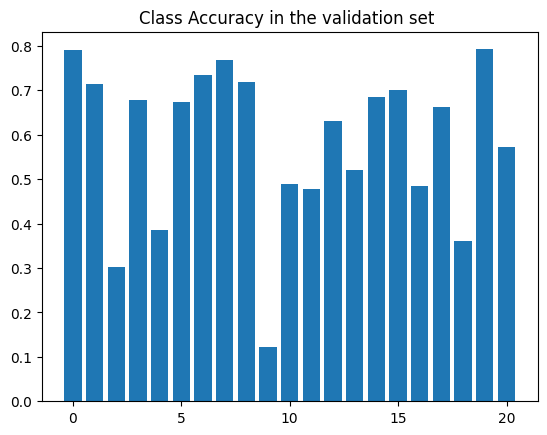


Test set (736): Average loss: 0.5954, mIoU: 0.5841

PSPnetLite training, epoch 25
Train Epoch: 25 [240/8498 (3%)]	Loss: 0.445231, Learning rate: 0.001000
Train Epoch: 25 [480/8498 (6%)]	Loss: 0.230499, Learning rate: 0.001000
Train Epoch: 25 [720/8498 (8%)]	Loss: 0.224269, Learning rate: 0.001000
Train Epoch: 25 [960/8498 (11%)]	Loss: 0.420587, Learning rate: 0.001000
Train Epoch: 25 [1200/8498 (14%)]	Loss: 0.300076, Learning rate: 0.001000
Train Epoch: 25 [1440/8498 (17%)]	Loss: 0.375127, Learning rate: 0.001000
Train Epoch: 25 [1680/8498 (20%)]	Loss: 0.398603, Learning rate: 0.001000
Train Epoch: 25 [1920/8498 (23%)]	Loss: 0.505292, Learning rate: 0.001000
Train Epoch: 25 [2160/8498 (25%)]	Loss: 0.379443, Learning rate: 0.001000
Train Epoch: 25 [2400/8498 (28%)]	Loss: 0.348259, Learning rate: 0.001000
Train Epoch: 25 [2640/8498 (31%)]	Loss: 0.341750, Learning rate: 0.001000
Train Epoch: 25 [2880/8498 (34%)]	Loss: 0.297199, Learning rate: 0.001000
Train Epoch: 25 [3120/8498 (37%)]	Lo

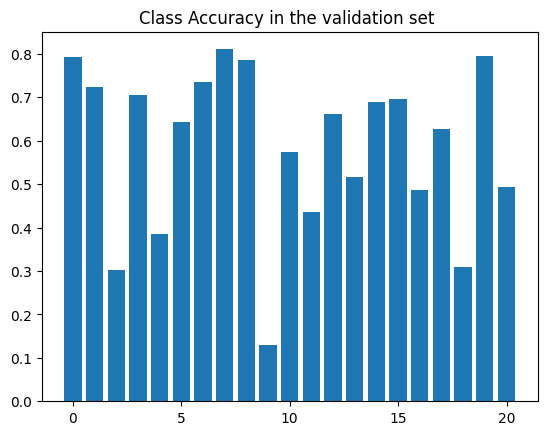


Test set (736): Average loss: 0.5981, mIoU: 0.5856

PSPnetLite training, epoch 26
Train Epoch: 26 [240/8498 (3%)]	Loss: 0.357182, Learning rate: 0.001000
Train Epoch: 26 [480/8498 (6%)]	Loss: 0.355851, Learning rate: 0.001000
Train Epoch: 26 [720/8498 (8%)]	Loss: 0.346778, Learning rate: 0.001000
Train Epoch: 26 [960/8498 (11%)]	Loss: 0.331597, Learning rate: 0.001000
Train Epoch: 26 [1200/8498 (14%)]	Loss: 0.304365, Learning rate: 0.001000
Train Epoch: 26 [1440/8498 (17%)]	Loss: 0.271618, Learning rate: 0.001000
Train Epoch: 26 [1680/8498 (20%)]	Loss: 0.318546, Learning rate: 0.001000
Train Epoch: 26 [1920/8498 (23%)]	Loss: 0.226129, Learning rate: 0.001000
Train Epoch: 26 [2160/8498 (25%)]	Loss: 0.301261, Learning rate: 0.001000
Train Epoch: 26 [2400/8498 (28%)]	Loss: 0.444398, Learning rate: 0.001000
Train Epoch: 26 [2640/8498 (31%)]	Loss: 0.465029, Learning rate: 0.001000
Train Epoch: 26 [2880/8498 (34%)]	Loss: 0.338721, Learning rate: 0.001000
Train Epoch: 26 [3120/8498 (37%)]	Lo

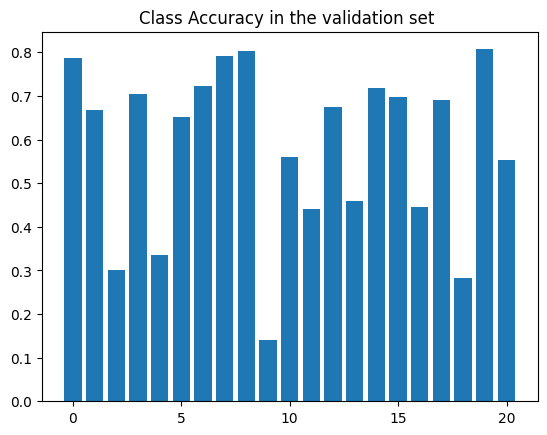


Test set (736): Average loss: 0.5997, mIoU: 0.5826

PSPnetLite training, epoch 27
Train Epoch: 27 [240/8498 (3%)]	Loss: 0.301043, Learning rate: 0.001000
Train Epoch: 27 [480/8498 (6%)]	Loss: 0.260447, Learning rate: 0.001000
Train Epoch: 27 [720/8498 (8%)]	Loss: 0.326620, Learning rate: 0.001000
Train Epoch: 27 [960/8498 (11%)]	Loss: 0.315144, Learning rate: 0.001000
Train Epoch: 27 [1200/8498 (14%)]	Loss: 0.285757, Learning rate: 0.001000
Train Epoch: 27 [1440/8498 (17%)]	Loss: 0.405092, Learning rate: 0.001000
Train Epoch: 27 [1680/8498 (20%)]	Loss: 0.266133, Learning rate: 0.001000
Train Epoch: 27 [1920/8498 (23%)]	Loss: 0.269147, Learning rate: 0.001000
Train Epoch: 27 [2160/8498 (25%)]	Loss: 0.347041, Learning rate: 0.001000
Train Epoch: 27 [2400/8498 (28%)]	Loss: 0.413754, Learning rate: 0.001000
Train Epoch: 27 [2640/8498 (31%)]	Loss: 0.404752, Learning rate: 0.001000
Train Epoch: 27 [2880/8498 (34%)]	Loss: 0.402880, Learning rate: 0.001000
Train Epoch: 27 [3120/8498 (37%)]	Lo

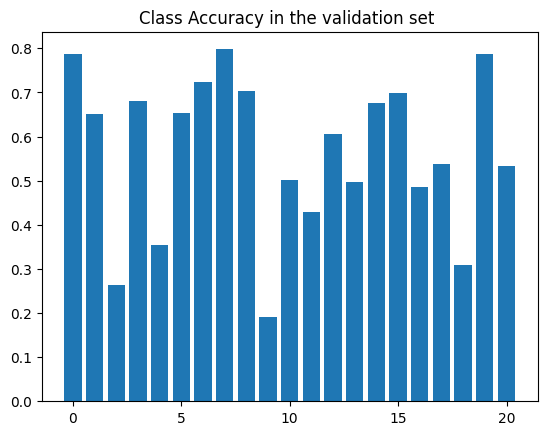


Test set (736): Average loss: 0.6211, mIoU: 0.5651

PSPnetLite training, epoch 28
Train Epoch: 28 [240/8498 (3%)]	Loss: 0.303913, Learning rate: 0.001000
Train Epoch: 28 [480/8498 (6%)]	Loss: 0.508944, Learning rate: 0.001000
Train Epoch: 28 [720/8498 (8%)]	Loss: 0.464605, Learning rate: 0.001000
Train Epoch: 28 [960/8498 (11%)]	Loss: 0.415703, Learning rate: 0.001000
Train Epoch: 28 [1200/8498 (14%)]	Loss: 0.341033, Learning rate: 0.001000
Train Epoch: 28 [1440/8498 (17%)]	Loss: 0.502320, Learning rate: 0.001000
Train Epoch: 28 [1680/8498 (20%)]	Loss: 0.474222, Learning rate: 0.001000
Train Epoch: 28 [1920/8498 (23%)]	Loss: 0.440809, Learning rate: 0.001000
Train Epoch: 28 [2160/8498 (25%)]	Loss: 0.246933, Learning rate: 0.001000
Train Epoch: 28 [2400/8498 (28%)]	Loss: 0.401243, Learning rate: 0.001000
Train Epoch: 28 [2640/8498 (31%)]	Loss: 0.366729, Learning rate: 0.001000
Train Epoch: 28 [2880/8498 (34%)]	Loss: 0.406479, Learning rate: 0.001000
Train Epoch: 28 [3120/8498 (37%)]	Lo

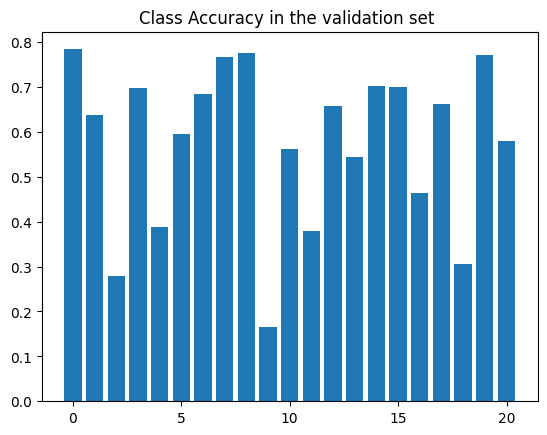


Test set (736): Average loss: 0.6222, mIoU: 0.5763

PSPnetLite training, epoch 29
Train Epoch: 29 [240/8498 (3%)]	Loss: 0.309972, Learning rate: 0.001000
Train Epoch: 29 [480/8498 (6%)]	Loss: 0.327692, Learning rate: 0.001000
Train Epoch: 29 [720/8498 (8%)]	Loss: 0.247327, Learning rate: 0.001000
Train Epoch: 29 [960/8498 (11%)]	Loss: 0.461630, Learning rate: 0.001000
Train Epoch: 29 [1200/8498 (14%)]	Loss: 0.222821, Learning rate: 0.001000
Train Epoch: 29 [1440/8498 (17%)]	Loss: 0.268284, Learning rate: 0.001000
Train Epoch: 29 [1680/8498 (20%)]	Loss: 0.292900, Learning rate: 0.001000
Train Epoch: 29 [1920/8498 (23%)]	Loss: 0.360536, Learning rate: 0.001000
Train Epoch: 29 [2160/8498 (25%)]	Loss: 0.193565, Learning rate: 0.001000
Train Epoch: 29 [2400/8498 (28%)]	Loss: 0.323056, Learning rate: 0.001000
Train Epoch: 29 [2640/8498 (31%)]	Loss: 0.305186, Learning rate: 0.001000
Train Epoch: 29 [2880/8498 (34%)]	Loss: 0.348491, Learning rate: 0.001000
Train Epoch: 29 [3120/8498 (37%)]	Lo

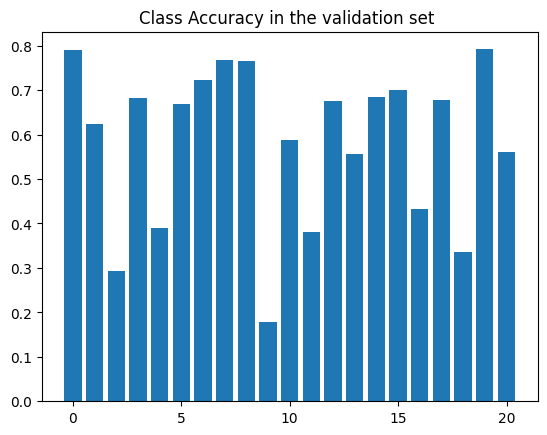


Test set (736): Average loss: 0.6348, mIoU: 0.5841

PSPnetLite training, epoch 30
Train Epoch: 30 [240/8498 (3%)]	Loss: 0.299112, Learning rate: 0.001000
Train Epoch: 30 [480/8498 (6%)]	Loss: 0.344909, Learning rate: 0.001000
Train Epoch: 30 [720/8498 (8%)]	Loss: 0.344989, Learning rate: 0.001000
Train Epoch: 30 [960/8498 (11%)]	Loss: 0.304517, Learning rate: 0.001000
Train Epoch: 30 [1200/8498 (14%)]	Loss: 0.369111, Learning rate: 0.001000
Train Epoch: 30 [1440/8498 (17%)]	Loss: 0.389937, Learning rate: 0.001000
Train Epoch: 30 [1680/8498 (20%)]	Loss: 0.265661, Learning rate: 0.001000
Train Epoch: 30 [1920/8498 (23%)]	Loss: 0.324049, Learning rate: 0.001000
Train Epoch: 30 [2160/8498 (25%)]	Loss: 0.391115, Learning rate: 0.001000
Train Epoch: 30 [2400/8498 (28%)]	Loss: 0.447451, Learning rate: 0.001000
Train Epoch: 30 [2640/8498 (31%)]	Loss: 0.454547, Learning rate: 0.001000
Train Epoch: 30 [2880/8498 (34%)]	Loss: 0.252178, Learning rate: 0.001000
Train Epoch: 30 [3120/8498 (37%)]	Lo

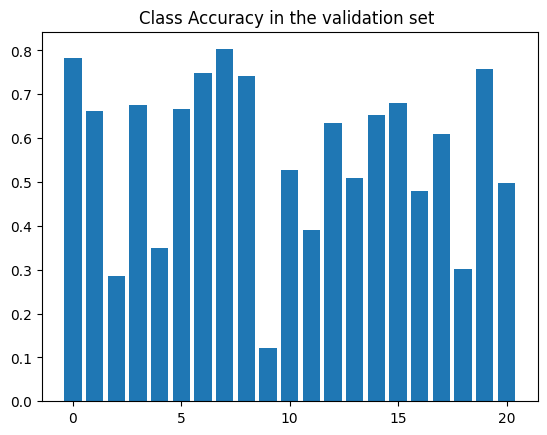


Test set (736): Average loss: 0.6479, mIoU: 0.5655

PSPnetLite training, epoch 31
Train Epoch: 31 [240/8498 (3%)]	Loss: 0.333564, Learning rate: 0.001000
Train Epoch: 31 [480/8498 (6%)]	Loss: 0.352250, Learning rate: 0.001000
Train Epoch: 31 [720/8498 (8%)]	Loss: 0.402646, Learning rate: 0.001000
Train Epoch: 31 [960/8498 (11%)]	Loss: 0.461796, Learning rate: 0.001000
Train Epoch: 31 [1200/8498 (14%)]	Loss: 0.357422, Learning rate: 0.001000
Train Epoch: 31 [1440/8498 (17%)]	Loss: 0.512459, Learning rate: 0.001000
Train Epoch: 31 [1680/8498 (20%)]	Loss: 0.430704, Learning rate: 0.001000
Train Epoch: 31 [1920/8498 (23%)]	Loss: 0.219699, Learning rate: 0.001000
Train Epoch: 31 [2160/8498 (25%)]	Loss: 0.316900, Learning rate: 0.001000
Train Epoch: 31 [2400/8498 (28%)]	Loss: 0.328961, Learning rate: 0.001000
Train Epoch: 31 [2640/8498 (31%)]	Loss: 0.293807, Learning rate: 0.001000
Train Epoch: 31 [2880/8498 (34%)]	Loss: 0.538274, Learning rate: 0.001000
Train Epoch: 31 [3120/8498 (37%)]	Lo

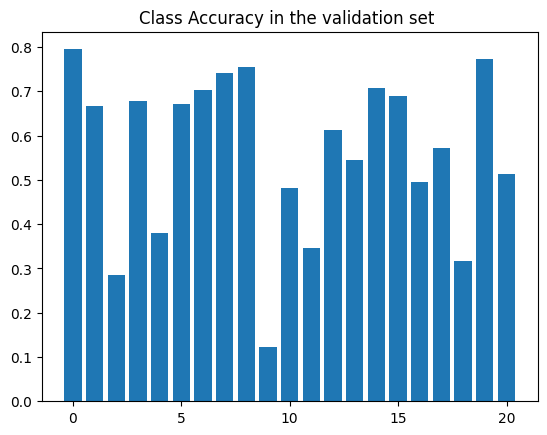


Test set (736): Average loss: 0.6366, mIoU: 0.5645

PSPnetLite training, epoch 32
Train Epoch: 32 [240/8498 (3%)]	Loss: 0.372836, Learning rate: 0.001000
Train Epoch: 32 [480/8498 (6%)]	Loss: 0.310536, Learning rate: 0.001000
Train Epoch: 32 [720/8498 (8%)]	Loss: 0.265462, Learning rate: 0.001000
Train Epoch: 32 [960/8498 (11%)]	Loss: 0.243266, Learning rate: 0.001000
Train Epoch: 32 [1200/8498 (14%)]	Loss: 0.328391, Learning rate: 0.001000
Train Epoch: 32 [1440/8498 (17%)]	Loss: 0.322562, Learning rate: 0.001000
Train Epoch: 32 [1680/8498 (20%)]	Loss: 0.278932, Learning rate: 0.001000
Train Epoch: 32 [1920/8498 (23%)]	Loss: 0.397079, Learning rate: 0.001000
Train Epoch: 32 [2160/8498 (25%)]	Loss: 0.255921, Learning rate: 0.001000
Train Epoch: 32 [2400/8498 (28%)]	Loss: 0.344667, Learning rate: 0.001000
Train Epoch: 32 [2640/8498 (31%)]	Loss: 0.391397, Learning rate: 0.001000
Train Epoch: 32 [2880/8498 (34%)]	Loss: 0.296708, Learning rate: 0.001000
Train Epoch: 32 [3120/8498 (37%)]	Lo

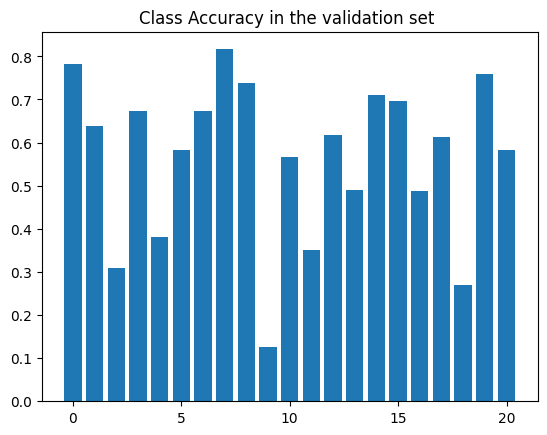


Test set (736): Average loss: 0.6555, mIoU: 0.5650

PSPnetLite training, epoch 33
Train Epoch: 33 [240/8498 (3%)]	Loss: 0.302662, Learning rate: 0.001000
Train Epoch: 33 [480/8498 (6%)]	Loss: 0.310587, Learning rate: 0.001000
Train Epoch: 33 [720/8498 (8%)]	Loss: 0.263456, Learning rate: 0.001000
Train Epoch: 33 [960/8498 (11%)]	Loss: 0.256883, Learning rate: 0.001000
Train Epoch: 33 [1200/8498 (14%)]	Loss: 0.440497, Learning rate: 0.001000
Train Epoch: 33 [1440/8498 (17%)]	Loss: 0.336751, Learning rate: 0.001000
Train Epoch: 33 [1680/8498 (20%)]	Loss: 0.648197, Learning rate: 0.001000
Train Epoch: 33 [1920/8498 (23%)]	Loss: 0.322896, Learning rate: 0.001000
Train Epoch: 33 [2160/8498 (25%)]	Loss: 0.344314, Learning rate: 0.001000
Train Epoch: 33 [2400/8498 (28%)]	Loss: 0.415803, Learning rate: 0.001000
Train Epoch: 33 [2640/8498 (31%)]	Loss: 0.471128, Learning rate: 0.001000
Train Epoch: 33 [2880/8498 (34%)]	Loss: 0.324676, Learning rate: 0.001000
Train Epoch: 33 [3120/8498 (37%)]	Lo

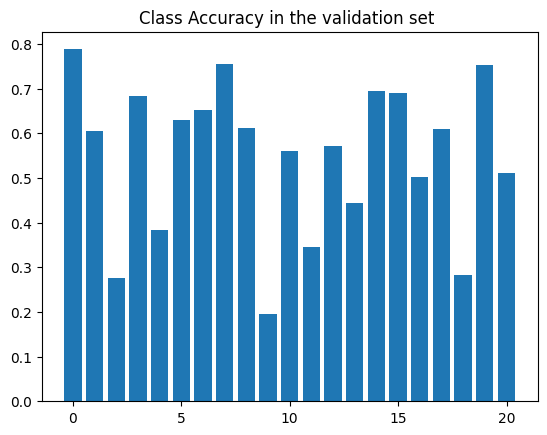


Test set (736): Average loss: 0.6981, mIoU: 0.5497

PSPnetLite training, epoch 34
Train Epoch: 34 [240/8498 (3%)]	Loss: 0.394706, Learning rate: 0.001000
Train Epoch: 34 [480/8498 (6%)]	Loss: 0.393656, Learning rate: 0.001000
Train Epoch: 34 [720/8498 (8%)]	Loss: 0.301375, Learning rate: 0.001000
Train Epoch: 34 [960/8498 (11%)]	Loss: 0.384086, Learning rate: 0.001000
Train Epoch: 34 [1200/8498 (14%)]	Loss: 0.406812, Learning rate: 0.001000
Train Epoch: 34 [1440/8498 (17%)]	Loss: 0.349286, Learning rate: 0.001000
Train Epoch: 34 [1680/8498 (20%)]	Loss: 0.249048, Learning rate: 0.001000
Train Epoch: 34 [1920/8498 (23%)]	Loss: 0.310397, Learning rate: 0.001000
Train Epoch: 34 [2160/8498 (25%)]	Loss: 0.267389, Learning rate: 0.001000
Train Epoch: 34 [2400/8498 (28%)]	Loss: 0.246789, Learning rate: 0.001000
Train Epoch: 34 [2640/8498 (31%)]	Loss: 0.225588, Learning rate: 0.001000
Train Epoch: 34 [2880/8498 (34%)]	Loss: 0.461432, Learning rate: 0.001000
Train Epoch: 34 [3120/8498 (37%)]	Lo

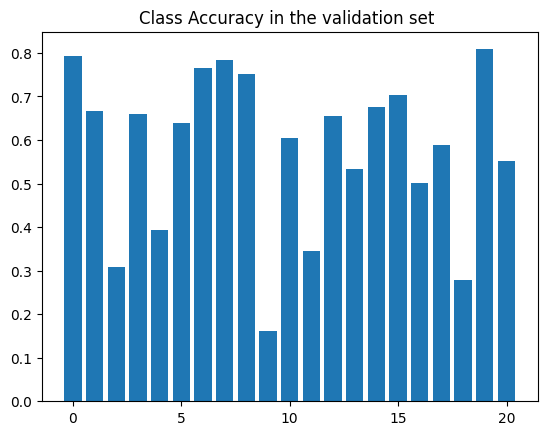


Test set (736): Average loss: 0.6074, mIoU: 0.5794

PSPnetLite training, epoch 35
Train Epoch: 35 [240/8498 (3%)]	Loss: 0.364988, Learning rate: 0.001000
Train Epoch: 35 [480/8498 (6%)]	Loss: 0.274256, Learning rate: 0.001000
Train Epoch: 35 [720/8498 (8%)]	Loss: 0.255349, Learning rate: 0.001000
Train Epoch: 35 [960/8498 (11%)]	Loss: 0.342608, Learning rate: 0.001000
Train Epoch: 35 [1200/8498 (14%)]	Loss: 0.353577, Learning rate: 0.001000
Train Epoch: 35 [1440/8498 (17%)]	Loss: 0.248483, Learning rate: 0.001000
Train Epoch: 35 [1680/8498 (20%)]	Loss: 0.301846, Learning rate: 0.001000
Train Epoch: 35 [1920/8498 (23%)]	Loss: 0.418492, Learning rate: 0.001000
Train Epoch: 35 [2160/8498 (25%)]	Loss: 0.401849, Learning rate: 0.001000
Train Epoch: 35 [2400/8498 (28%)]	Loss: 0.260203, Learning rate: 0.001000
Train Epoch: 35 [2640/8498 (31%)]	Loss: 0.294955, Learning rate: 0.001000
Train Epoch: 35 [2880/8498 (34%)]	Loss: 0.451319, Learning rate: 0.001000
Train Epoch: 35 [3120/8498 (37%)]	Lo

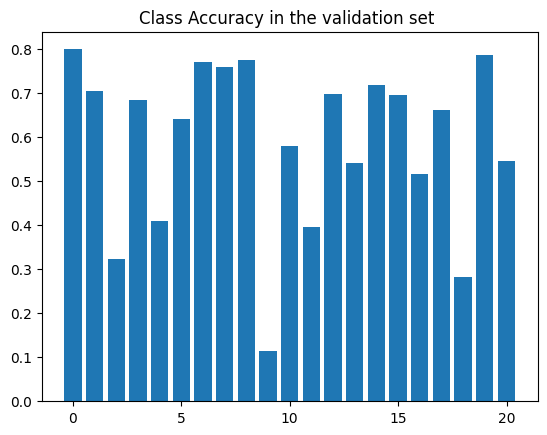


Test set (736): Average loss: 0.5803, mIoU: 0.5905

PSPnetLite training, epoch 36
Train Epoch: 36 [240/8498 (3%)]	Loss: 0.251257, Learning rate: 0.001000
Train Epoch: 36 [480/8498 (6%)]	Loss: 0.328871, Learning rate: 0.001000
Train Epoch: 36 [720/8498 (8%)]	Loss: 0.329027, Learning rate: 0.001000
Train Epoch: 36 [960/8498 (11%)]	Loss: 0.297064, Learning rate: 0.001000
Train Epoch: 36 [1200/8498 (14%)]	Loss: 0.405783, Learning rate: 0.001000
Train Epoch: 36 [1440/8498 (17%)]	Loss: 0.253440, Learning rate: 0.001000
Train Epoch: 36 [1680/8498 (20%)]	Loss: 0.314439, Learning rate: 0.001000
Train Epoch: 36 [1920/8498 (23%)]	Loss: 0.358731, Learning rate: 0.001000
Train Epoch: 36 [2160/8498 (25%)]	Loss: 0.356449, Learning rate: 0.001000
Train Epoch: 36 [2400/8498 (28%)]	Loss: 0.445385, Learning rate: 0.001000
Train Epoch: 36 [2640/8498 (31%)]	Loss: 0.218280, Learning rate: 0.001000
Train Epoch: 36 [2880/8498 (34%)]	Loss: 0.347365, Learning rate: 0.001000
Train Epoch: 36 [3120/8498 (37%)]	Lo

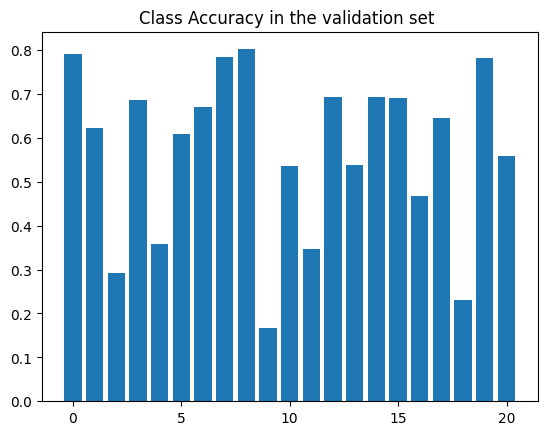


Test set (736): Average loss: 0.6355, mIoU: 0.5697

PSPnetLite training, epoch 37
Train Epoch: 37 [240/8498 (3%)]	Loss: 0.380795, Learning rate: 0.001000
Train Epoch: 37 [480/8498 (6%)]	Loss: 0.467664, Learning rate: 0.001000
Train Epoch: 37 [720/8498 (8%)]	Loss: 0.407636, Learning rate: 0.001000
Train Epoch: 37 [960/8498 (11%)]	Loss: 0.352447, Learning rate: 0.001000
Train Epoch: 37 [1200/8498 (14%)]	Loss: 0.262512, Learning rate: 0.001000
Train Epoch: 37 [1440/8498 (17%)]	Loss: 0.258431, Learning rate: 0.001000
Train Epoch: 37 [1680/8498 (20%)]	Loss: 0.433614, Learning rate: 0.001000
Train Epoch: 37 [1920/8498 (23%)]	Loss: 0.276972, Learning rate: 0.001000
Train Epoch: 37 [2160/8498 (25%)]	Loss: 0.210768, Learning rate: 0.001000
Train Epoch: 37 [2400/8498 (28%)]	Loss: 0.467254, Learning rate: 0.001000
Train Epoch: 37 [2640/8498 (31%)]	Loss: 0.310050, Learning rate: 0.001000
Train Epoch: 37 [2880/8498 (34%)]	Loss: 0.251492, Learning rate: 0.001000
Train Epoch: 37 [3120/8498 (37%)]	Lo

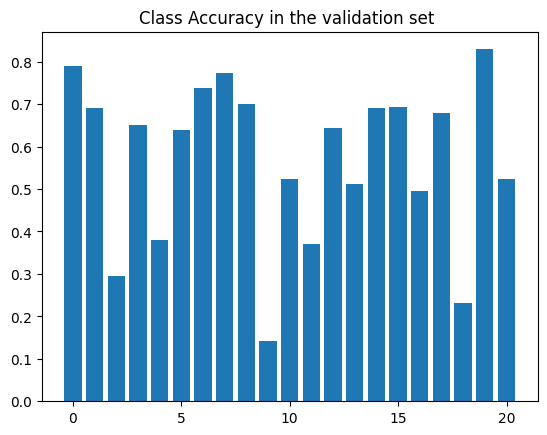


Test set (736): Average loss: 0.6390, mIoU: 0.5709

PSPnetLite training, epoch 38
Train Epoch: 38 [240/8498 (3%)]	Loss: 0.341613, Learning rate: 0.001000
Train Epoch: 38 [480/8498 (6%)]	Loss: 0.255408, Learning rate: 0.001000
Train Epoch: 38 [720/8498 (8%)]	Loss: 0.390403, Learning rate: 0.001000
Train Epoch: 38 [960/8498 (11%)]	Loss: 0.204979, Learning rate: 0.001000
Train Epoch: 38 [1200/8498 (14%)]	Loss: 0.211168, Learning rate: 0.001000
Train Epoch: 38 [1440/8498 (17%)]	Loss: 0.281764, Learning rate: 0.001000
Train Epoch: 38 [1680/8498 (20%)]	Loss: 0.317810, Learning rate: 0.001000
Train Epoch: 38 [1920/8498 (23%)]	Loss: 0.416869, Learning rate: 0.001000
Train Epoch: 38 [2160/8498 (25%)]	Loss: 0.351411, Learning rate: 0.001000
Train Epoch: 38 [2400/8498 (28%)]	Loss: 0.266110, Learning rate: 0.001000
Train Epoch: 38 [2640/8498 (31%)]	Loss: 0.295909, Learning rate: 0.001000
Train Epoch: 38 [2880/8498 (34%)]	Loss: 0.345292, Learning rate: 0.001000
Train Epoch: 38 [3120/8498 (37%)]	Lo

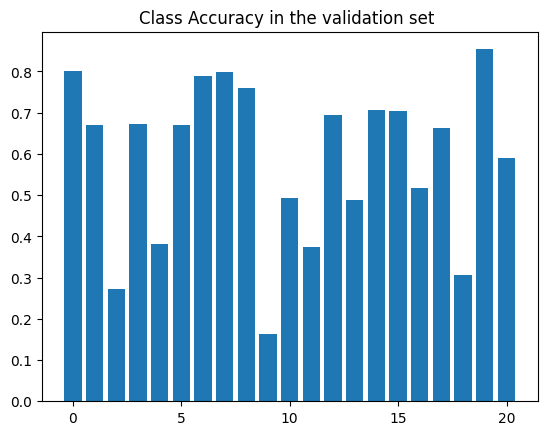


Test set (736): Average loss: 0.5820, mIoU: 0.5890

PSPnetLite training, epoch 39
Train Epoch: 39 [240/8498 (3%)]	Loss: 0.265699, Learning rate: 0.001000
Train Epoch: 39 [480/8498 (6%)]	Loss: 0.444236, Learning rate: 0.001000
Train Epoch: 39 [720/8498 (8%)]	Loss: 0.370773, Learning rate: 0.001000
Train Epoch: 39 [960/8498 (11%)]	Loss: 0.336170, Learning rate: 0.001000
Train Epoch: 39 [1200/8498 (14%)]	Loss: 0.297170, Learning rate: 0.001000
Train Epoch: 39 [1440/8498 (17%)]	Loss: 0.399760, Learning rate: 0.001000
Train Epoch: 39 [1680/8498 (20%)]	Loss: 0.186380, Learning rate: 0.001000
Train Epoch: 39 [1920/8498 (23%)]	Loss: 0.372183, Learning rate: 0.001000
Train Epoch: 39 [2160/8498 (25%)]	Loss: 0.344119, Learning rate: 0.001000
Train Epoch: 39 [2400/8498 (28%)]	Loss: 0.510210, Learning rate: 0.001000
Train Epoch: 39 [2640/8498 (31%)]	Loss: 0.245540, Learning rate: 0.001000
Train Epoch: 39 [2880/8498 (34%)]	Loss: 0.466055, Learning rate: 0.001000
Train Epoch: 39 [3120/8498 (37%)]	Lo

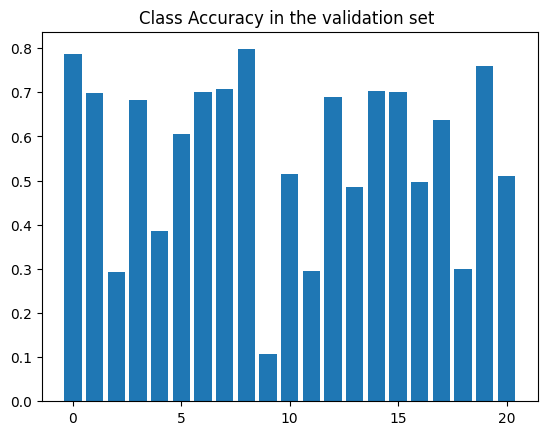


Test set (736): Average loss: 0.6244, mIoU: 0.5647

PSPnetLite training, epoch 40
Train Epoch: 40 [240/8498 (3%)]	Loss: 0.230522, Learning rate: 0.001000
Train Epoch: 40 [480/8498 (6%)]	Loss: 0.316649, Learning rate: 0.001000
Train Epoch: 40 [720/8498 (8%)]	Loss: 0.299994, Learning rate: 0.001000
Train Epoch: 40 [960/8498 (11%)]	Loss: 0.313274, Learning rate: 0.001000
Train Epoch: 40 [1200/8498 (14%)]	Loss: 0.377160, Learning rate: 0.001000
Train Epoch: 40 [1440/8498 (17%)]	Loss: 0.257308, Learning rate: 0.001000
Train Epoch: 40 [1680/8498 (20%)]	Loss: 0.257543, Learning rate: 0.001000
Train Epoch: 40 [1920/8498 (23%)]	Loss: 0.299526, Learning rate: 0.001000
Train Epoch: 40 [2160/8498 (25%)]	Loss: 0.247732, Learning rate: 0.001000
Train Epoch: 40 [2400/8498 (28%)]	Loss: 0.194565, Learning rate: 0.001000
Train Epoch: 40 [2640/8498 (31%)]	Loss: 0.324512, Learning rate: 0.001000
Train Epoch: 40 [2880/8498 (34%)]	Loss: 0.238210, Learning rate: 0.001000
Train Epoch: 40 [3120/8498 (37%)]	Lo

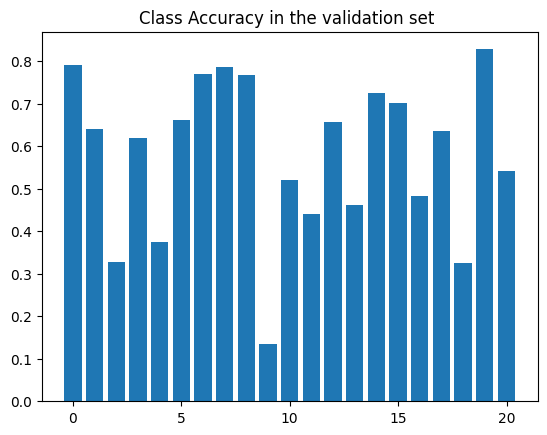


Test set (736): Average loss: 0.6385, mIoU: 0.5804

PSPnetLite training, epoch 41
Train Epoch: 41 [240/8498 (3%)]	Loss: 0.333798, Learning rate: 0.001000
Train Epoch: 41 [480/8498 (6%)]	Loss: 0.332497, Learning rate: 0.001000
Train Epoch: 41 [720/8498 (8%)]	Loss: 0.299448, Learning rate: 0.001000
Train Epoch: 41 [960/8498 (11%)]	Loss: 0.284688, Learning rate: 0.001000
Train Epoch: 41 [1200/8498 (14%)]	Loss: 0.311589, Learning rate: 0.001000
Train Epoch: 41 [1440/8498 (17%)]	Loss: 0.247745, Learning rate: 0.001000
Train Epoch: 41 [1680/8498 (20%)]	Loss: 0.402587, Learning rate: 0.001000
Train Epoch: 41 [1920/8498 (23%)]	Loss: 0.354495, Learning rate: 0.001000
Train Epoch: 41 [2160/8498 (25%)]	Loss: 0.415784, Learning rate: 0.001000
Train Epoch: 41 [2400/8498 (28%)]	Loss: 0.409929, Learning rate: 0.001000
Train Epoch: 41 [2640/8498 (31%)]	Loss: 0.285094, Learning rate: 0.001000
Train Epoch: 41 [2880/8498 (34%)]	Loss: 0.264660, Learning rate: 0.001000
Train Epoch: 41 [3120/8498 (37%)]	Lo

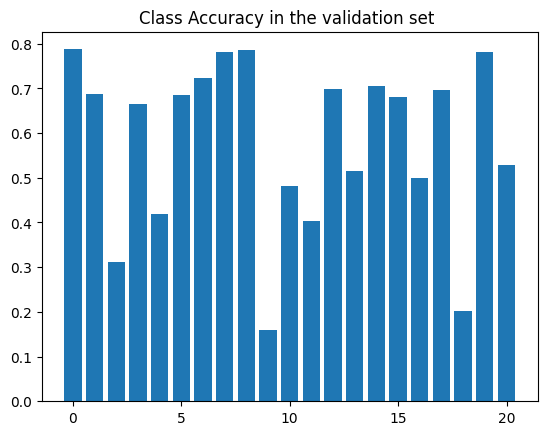


Test set (736): Average loss: 0.6262, mIoU: 0.5809

PSPnetLite training, epoch 42
Train Epoch: 42 [240/8498 (3%)]	Loss: 0.341273, Learning rate: 0.001000
Train Epoch: 42 [480/8498 (6%)]	Loss: 0.332416, Learning rate: 0.001000
Train Epoch: 42 [720/8498 (8%)]	Loss: 0.290295, Learning rate: 0.001000
Train Epoch: 42 [960/8498 (11%)]	Loss: 0.294058, Learning rate: 0.001000
Train Epoch: 42 [1200/8498 (14%)]	Loss: 0.241124, Learning rate: 0.001000
Train Epoch: 42 [1440/8498 (17%)]	Loss: 0.347064, Learning rate: 0.001000
Train Epoch: 42 [1680/8498 (20%)]	Loss: 0.246722, Learning rate: 0.001000
Train Epoch: 42 [1920/8498 (23%)]	Loss: 0.232916, Learning rate: 0.001000
Train Epoch: 42 [2160/8498 (25%)]	Loss: 0.215455, Learning rate: 0.001000
Train Epoch: 42 [2400/8498 (28%)]	Loss: 0.236073, Learning rate: 0.001000
Train Epoch: 42 [2640/8498 (31%)]	Loss: 0.339791, Learning rate: 0.001000
Train Epoch: 42 [2880/8498 (34%)]	Loss: 0.199431, Learning rate: 0.001000
Train Epoch: 42 [3120/8498 (37%)]	Lo

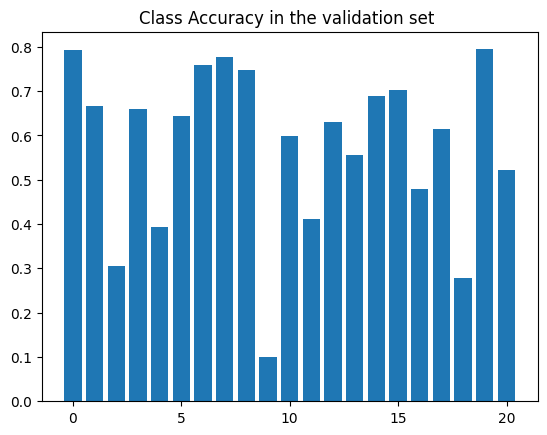


Test set (736): Average loss: 0.6304, mIoU: 0.5770

PSPnetLite training, epoch 43
Train Epoch: 43 [240/8498 (3%)]	Loss: 0.242588, Learning rate: 0.001000
Train Epoch: 43 [480/8498 (6%)]	Loss: 0.270997, Learning rate: 0.001000
Train Epoch: 43 [720/8498 (8%)]	Loss: 0.304793, Learning rate: 0.001000
Train Epoch: 43 [960/8498 (11%)]	Loss: 0.377573, Learning rate: 0.001000
Train Epoch: 43 [1200/8498 (14%)]	Loss: 0.384839, Learning rate: 0.001000
Train Epoch: 43 [1440/8498 (17%)]	Loss: 0.241033, Learning rate: 0.001000
Train Epoch: 43 [1680/8498 (20%)]	Loss: 0.218260, Learning rate: 0.001000
Train Epoch: 43 [1920/8498 (23%)]	Loss: 0.353616, Learning rate: 0.001000
Train Epoch: 43 [2160/8498 (25%)]	Loss: 0.324929, Learning rate: 0.001000
Train Epoch: 43 [2400/8498 (28%)]	Loss: 0.247485, Learning rate: 0.001000
Train Epoch: 43 [2640/8498 (31%)]	Loss: 0.355760, Learning rate: 0.001000
Train Epoch: 43 [2880/8498 (34%)]	Loss: 0.285710, Learning rate: 0.001000
Train Epoch: 43 [3120/8498 (37%)]	Lo

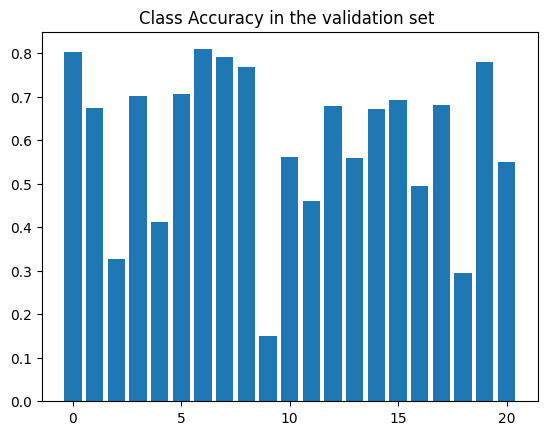


Test set (736): Average loss: 0.5779, mIoU: 0.5987

PSPnetLite training, epoch 44
Train Epoch: 44 [240/8498 (3%)]	Loss: 0.342241, Learning rate: 0.001000
Train Epoch: 44 [480/8498 (6%)]	Loss: 0.331423, Learning rate: 0.001000
Train Epoch: 44 [720/8498 (8%)]	Loss: 0.197501, Learning rate: 0.001000
Train Epoch: 44 [960/8498 (11%)]	Loss: 0.479730, Learning rate: 0.001000
Train Epoch: 44 [1200/8498 (14%)]	Loss: 0.292479, Learning rate: 0.001000
Train Epoch: 44 [1440/8498 (17%)]	Loss: 0.313650, Learning rate: 0.001000
Train Epoch: 44 [1680/8498 (20%)]	Loss: 0.283552, Learning rate: 0.001000
Train Epoch: 44 [1920/8498 (23%)]	Loss: 0.269828, Learning rate: 0.001000
Train Epoch: 44 [2160/8498 (25%)]	Loss: 0.324361, Learning rate: 0.001000
Train Epoch: 44 [2400/8498 (28%)]	Loss: 0.224177, Learning rate: 0.001000
Train Epoch: 44 [2640/8498 (31%)]	Loss: 0.209895, Learning rate: 0.001000
Train Epoch: 44 [2880/8498 (34%)]	Loss: 0.263988, Learning rate: 0.001000
Train Epoch: 44 [3120/8498 (37%)]	Lo

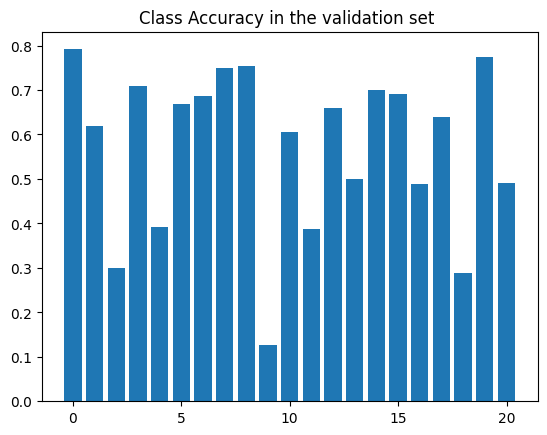


Test set (736): Average loss: 0.6206, mIoU: 0.5725

PSPnetLite training, epoch 45
Train Epoch: 45 [240/8498 (3%)]	Loss: 0.297156, Learning rate: 0.001000
Train Epoch: 45 [480/8498 (6%)]	Loss: 0.200225, Learning rate: 0.001000
Train Epoch: 45 [720/8498 (8%)]	Loss: 0.450372, Learning rate: 0.001000
Train Epoch: 45 [960/8498 (11%)]	Loss: 0.183843, Learning rate: 0.001000
Train Epoch: 45 [1200/8498 (14%)]	Loss: 0.214155, Learning rate: 0.001000
Train Epoch: 45 [1440/8498 (17%)]	Loss: 0.270421, Learning rate: 0.001000
Train Epoch: 45 [1680/8498 (20%)]	Loss: 0.268158, Learning rate: 0.001000
Train Epoch: 45 [1920/8498 (23%)]	Loss: 0.384984, Learning rate: 0.001000
Train Epoch: 45 [2160/8498 (25%)]	Loss: 0.318632, Learning rate: 0.001000
Train Epoch: 45 [2400/8498 (28%)]	Loss: 0.293902, Learning rate: 0.001000
Train Epoch: 45 [2640/8498 (31%)]	Loss: 0.336604, Learning rate: 0.001000
Train Epoch: 45 [2880/8498 (34%)]	Loss: 0.274692, Learning rate: 0.001000
Train Epoch: 45 [3120/8498 (37%)]	Lo

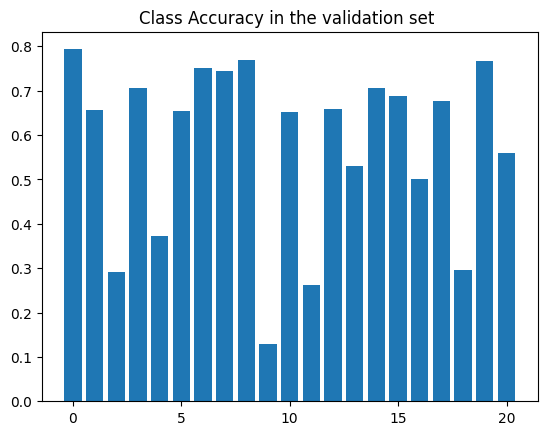


Test set (736): Average loss: 0.6676, mIoU: 0.5794



In [26]:
loss_train_epoch = []
loss_test_epoch = []
acc_train_per_epoch = []
acc_test_per_epoch = []
new_labels = []

cont = 0

res_path = "./metrics_" + args.experiment_name

if not os.path.isdir(res_path):
    os.makedirs(res_path)

for epoch in range(1, args.epoch + 1):
    st = time.time()

    # To fill: Train for one epoch
    print("PSPnetLite training, epoch " + str(epoch))
    loss_per_epoch = train_SemanticSeg(args, model, device, train_loader, optimizer, epoch)

    loss_train_epoch += [loss_per_epoch]

    scheduler.step()

    # To fill: test/validate
    loss_per_epoch_test, acc_val_per_epoch_i = testing(args, model, device, test_loader)

    loss_test_epoch += loss_per_epoch_test
    acc_test_per_epoch += [acc_val_per_epoch_i]

    if epoch == 1:
        best_acc_val = acc_val_per_epoch_i

    else:
        if acc_val_per_epoch_i > best_acc_val:
            best_acc_val = acc_val_per_epoch_i

    if epoch==args.epoch:
        torch.save(model.state_dict(), "SemanticSegModel.pth")

    np.save(res_path + '/' + 'LOSS_epoch_train.npy', np.asarray(loss_train_epoch))
    np.save(res_path + '/' + 'LOSS_epoch_val.npy', np.asarray(loss_test_epoch))

    # save accuracies:
    np.save(res_path + '/' + 'accuracy_per_epoch_val.npy', np.asarray(acc_test_per_epoch))

    cont += 1

### Accuracy and loss curves for semantic segmentation

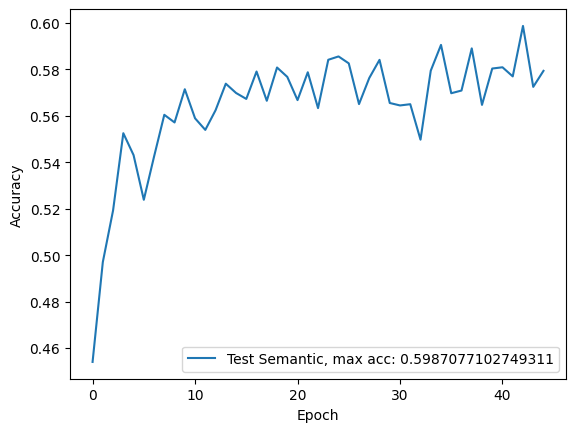

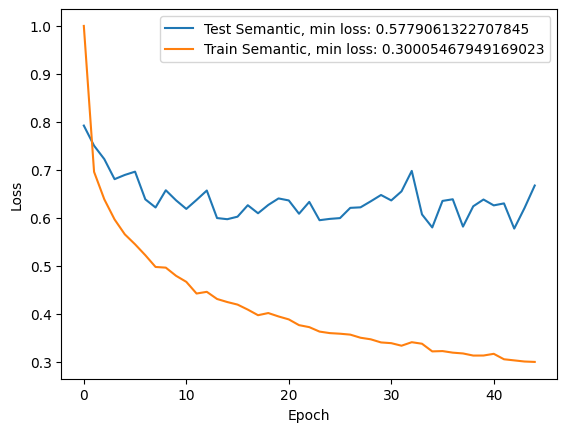

In [27]:
##Accuracy
acc_test  = np.asarray(acc_test_per_epoch)

#Loss per epoch
loss_test  = np.asarray(loss_test_epoch)
loss_train = np.asarray(loss_train_epoch)

numEpochs = len(acc_test)
epochs = range(numEpochs)

plt.figure(1)
plt.plot(epochs, acc_test, label='Test Semantic, max acc: ' + str(np.max(acc_test)))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(2)
plt.plot(epochs, loss_test, label='Test Semantic, min loss: ' + str(np.min(loss_test)))
plt.plot(epochs, loss_train, label='Train Semantic, min loss: ' + str(np.min(loss_train)))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

## Training a semantic segmentation CNN with class-based weighted loss

Now we will measure the beneftis of including weights in the computation of the loss.

As semantic segmentation is a class imbalance problem by nature, it may be interesting...

### Compute class weights from the training set

[[2.3447810e+08 7.2989280e+06 5.7621360e+06 7.0446840e+06 4.7513030e+06
  3.6516030e+06 9.1742140e+06 1.2724602e+07 2.0507506e+07 6.2963200e+06
  4.1390750e+06 4.6005140e+06 1.9435082e+07 6.5000070e+06 7.5537250e+06
  4.5500192e+07 3.5046890e+06 4.3871290e+06 5.6777030e+06 9.0360700e+06
  4.3719360e+06]]
[[0.45009255 0.98288226 0.98648643 0.98347855 0.98885703 0.9914361
  0.9784843  0.97015774 0.95190495 0.9852336  0.99029285 0.98921067
  0.9544201  0.98475593 0.9822847  0.8932911  0.99178064 0.9897111
  0.98668444 0.9788082  0.98974675]]


Text(0.5, 1.0, 'Assigned per-class weights to be used in the loss')

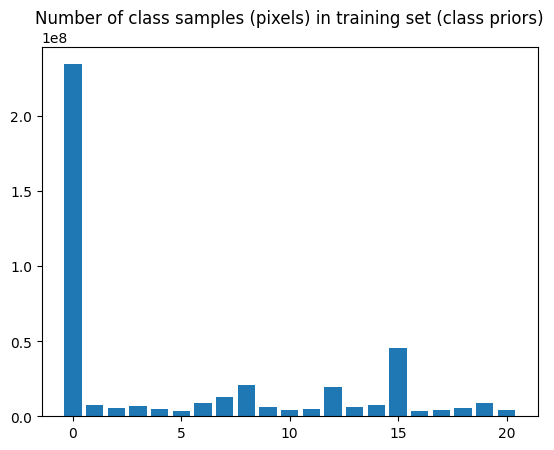

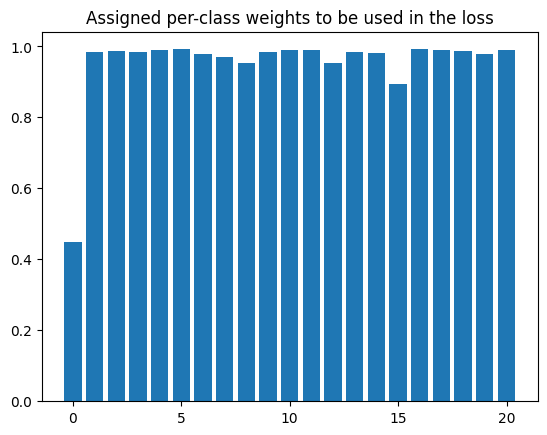

In [28]:
# Prior probabilities
class_sample_count = torch.zeros(1, 21)
for batch_idx, (images, mask) in enumerate(trainset):
   class_sample_count = class_sample_count + torch.tensor([(mask == t).sum() for t in torch.arange(0,21)])

print(class_sample_count.numpy())
plt.bar(np.arange(21), class_sample_count[0].numpy())
plt.title('Number of class samples (pixels) in training set (class priors)')
# get weights
weights = 1. - (class_sample_count/class_sample_count.sum())
print(weights.numpy())
plt.figure()
plt.bar(np.arange(21), weights[0].numpy())
plt.title('Assigned per-class weights to be used in the loss')

### Dataloaders for the training and the validation (test) stages to initialize the iterator.

In [29]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args.test_batch_size, shuffle=False, num_workers=8, pin_memory=True)

### Redefine PSPnet (lite) traning epoch to use per class weights in the loss computation

In [30]:
def train_SemanticSeg_Weights(args, model, device, train_loader, optimizer, class_weights, epoch):
    # switch to train mode
    model.train()

    train_loss = []
    counter = 1

    #### To fill: define a cross-entropy loss criterion.
    # Use a function that directly computes the log_softmax.
    # Use the input class_weights as a 1D Tensor assigning weight to each of the classes
    # ignore 255-labeled pixels, i.e. object contours labeled with 255 in the
    # training GT
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), ignore_index=args.ignore_label)

    gts_all, predictions_all = [], []

    for batch_idx, (images, mask) in enumerate(train_loader):

        images, mask = images.to(device), mask.to(device)

        #### To fill: Forward pass
        outputs = model(images)

        #Aggregated per-pixel loss
        loss = criterion(outputs, mask.squeeze(1))
        train_loss.append(loss.item())

        #### To fill: reset gradients
        optimizer.zero_grad()

        #### To fill: perform backpropagation
        loss.backward()

        #### To fill: perform a gradient descend step
        optimizer.step()

        if counter % 15 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Learning rate: {:.6f}'.format(
                epoch, int(counter * len(images)), len(train_loader.dataset),
                100. * counter / len(train_loader), loss.item(),
                optimizer.param_groups[0]['lr']))
        counter = counter + 1

    return sum(train_loss) / len(train_loss)#, mean_iu

### Define the model architecture

In [31]:
#To fill: define a model with the same architecture and pretrained weights as before...
model_weights = PSPNetLite(args, num_classes=args.num_classes, pretrained=args.pre_trained).to(device)
# print(model_weights) # if you want, you can visually inspect the defined architecture

### Define the optimizer and the scheduler

In [32]:
optimizer_weights = optim.SGD(model_weights.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)
scheduler_weights = optim.lr_scheduler.MultiStepLR(optimizer_weights, milestones=args.M, gamma=0.1)

### Training loop for weighted-loss semantic segmentation

PSPnetLite training, epoch 1
Train Epoch: 1 [240/8498 (3%)]	Loss: 2.423400, Learning rate: 0.001000
Train Epoch: 1 [480/8498 (6%)]	Loss: 2.052882, Learning rate: 0.001000
Train Epoch: 1 [720/8498 (8%)]	Loss: 1.828999, Learning rate: 0.001000
Train Epoch: 1 [960/8498 (11%)]	Loss: 2.131049, Learning rate: 0.001000
Train Epoch: 1 [1200/8498 (14%)]	Loss: 1.544358, Learning rate: 0.001000
Train Epoch: 1 [1440/8498 (17%)]	Loss: 1.507639, Learning rate: 0.001000
Train Epoch: 1 [1680/8498 (20%)]	Loss: 1.299143, Learning rate: 0.001000
Train Epoch: 1 [1920/8498 (23%)]	Loss: 1.147397, Learning rate: 0.001000
Train Epoch: 1 [2160/8498 (25%)]	Loss: 1.414216, Learning rate: 0.001000
Train Epoch: 1 [2400/8498 (28%)]	Loss: 0.889121, Learning rate: 0.001000
Train Epoch: 1 [2640/8498 (31%)]	Loss: 1.088260, Learning rate: 0.001000
Train Epoch: 1 [2880/8498 (34%)]	Loss: 1.044457, Learning rate: 0.001000
Train Epoch: 1 [3120/8498 (37%)]	Loss: 1.139640, Learning rate: 0.001000
Train Epoch: 1 [3360/8498 (39

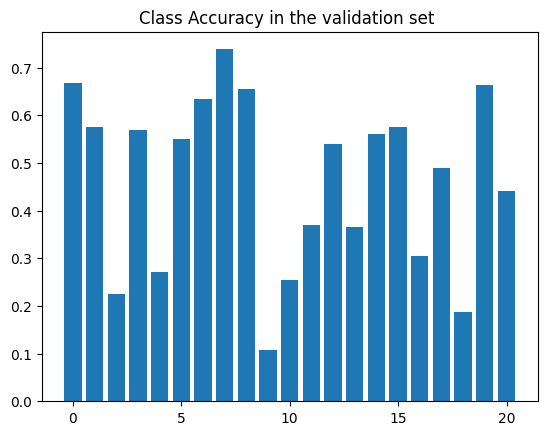


Test set (736): Average loss: 0.8563, mIoU: 0.4638

PSPnetLite training, epoch 2
Train Epoch: 2 [240/8498 (3%)]	Loss: 0.575714, Learning rate: 0.001000
Train Epoch: 2 [480/8498 (6%)]	Loss: 1.089674, Learning rate: 0.001000
Train Epoch: 2 [720/8498 (8%)]	Loss: 0.528841, Learning rate: 0.001000
Train Epoch: 2 [960/8498 (11%)]	Loss: 0.516030, Learning rate: 0.001000
Train Epoch: 2 [1200/8498 (14%)]	Loss: 0.525755, Learning rate: 0.001000
Train Epoch: 2 [1440/8498 (17%)]	Loss: 1.016610, Learning rate: 0.001000
Train Epoch: 2 [1680/8498 (20%)]	Loss: 1.001560, Learning rate: 0.001000
Train Epoch: 2 [1920/8498 (23%)]	Loss: 1.196195, Learning rate: 0.001000
Train Epoch: 2 [2160/8498 (25%)]	Loss: 0.904503, Learning rate: 0.001000
Train Epoch: 2 [2400/8498 (28%)]	Loss: 0.814655, Learning rate: 0.001000
Train Epoch: 2 [2640/8498 (31%)]	Loss: 0.846453, Learning rate: 0.001000
Train Epoch: 2 [2880/8498 (34%)]	Loss: 0.915553, Learning rate: 0.001000
Train Epoch: 2 [3120/8498 (37%)]	Loss: 0.734200, 

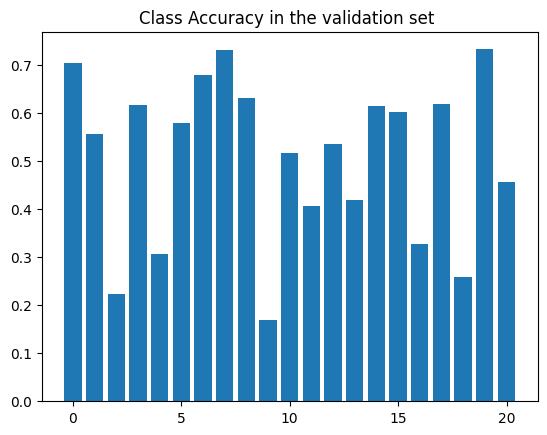


Test set (736): Average loss: 0.7888, mIoU: 0.5088

PSPnetLite training, epoch 3
Train Epoch: 3 [240/8498 (3%)]	Loss: 0.744287, Learning rate: 0.001000
Train Epoch: 3 [480/8498 (6%)]	Loss: 0.510324, Learning rate: 0.001000
Train Epoch: 3 [720/8498 (8%)]	Loss: 0.786258, Learning rate: 0.001000
Train Epoch: 3 [960/8498 (11%)]	Loss: 0.714510, Learning rate: 0.001000
Train Epoch: 3 [1200/8498 (14%)]	Loss: 1.185845, Learning rate: 0.001000
Train Epoch: 3 [1440/8498 (17%)]	Loss: 0.833332, Learning rate: 0.001000
Train Epoch: 3 [1680/8498 (20%)]	Loss: 0.665469, Learning rate: 0.001000
Train Epoch: 3 [1920/8498 (23%)]	Loss: 0.736323, Learning rate: 0.001000
Train Epoch: 3 [2160/8498 (25%)]	Loss: 1.013647, Learning rate: 0.001000
Train Epoch: 3 [2400/8498 (28%)]	Loss: 0.797694, Learning rate: 0.001000
Train Epoch: 3 [2640/8498 (31%)]	Loss: 0.944181, Learning rate: 0.001000
Train Epoch: 3 [2880/8498 (34%)]	Loss: 0.825087, Learning rate: 0.001000
Train Epoch: 3 [3120/8498 (37%)]	Loss: 0.945704, 

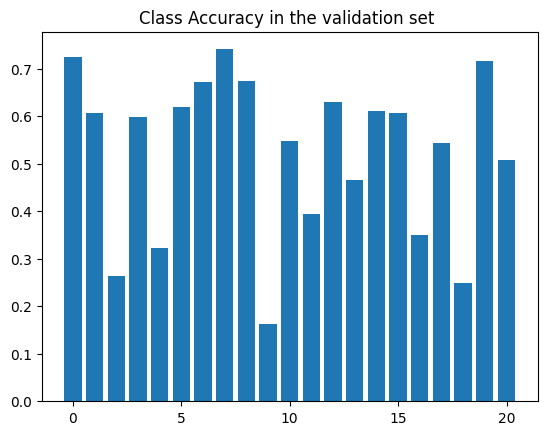


Test set (736): Average loss: 0.7488, mIoU: 0.5243

PSPnetLite training, epoch 4
Train Epoch: 4 [240/8498 (3%)]	Loss: 0.871180, Learning rate: 0.001000
Train Epoch: 4 [480/8498 (6%)]	Loss: 0.614524, Learning rate: 0.001000
Train Epoch: 4 [720/8498 (8%)]	Loss: 0.601639, Learning rate: 0.001000
Train Epoch: 4 [960/8498 (11%)]	Loss: 0.607589, Learning rate: 0.001000
Train Epoch: 4 [1200/8498 (14%)]	Loss: 0.760061, Learning rate: 0.001000
Train Epoch: 4 [1440/8498 (17%)]	Loss: 0.719386, Learning rate: 0.001000
Train Epoch: 4 [1680/8498 (20%)]	Loss: 0.904919, Learning rate: 0.001000
Train Epoch: 4 [1920/8498 (23%)]	Loss: 0.593570, Learning rate: 0.001000
Train Epoch: 4 [2160/8498 (25%)]	Loss: 0.526939, Learning rate: 0.001000
Train Epoch: 4 [2400/8498 (28%)]	Loss: 0.693020, Learning rate: 0.001000
Train Epoch: 4 [2640/8498 (31%)]	Loss: 0.528271, Learning rate: 0.001000
Train Epoch: 4 [2880/8498 (34%)]	Loss: 0.505093, Learning rate: 0.001000
Train Epoch: 4 [3120/8498 (37%)]	Loss: 0.855423, 

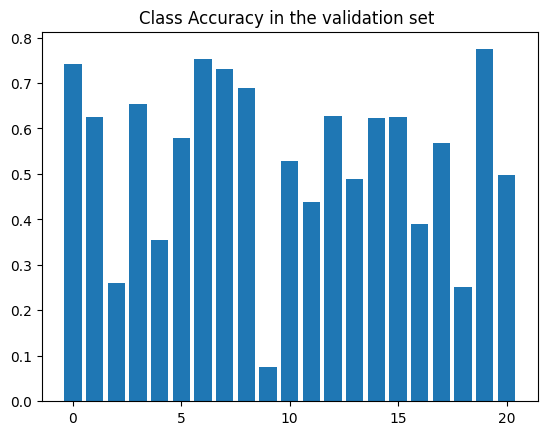


Test set (736): Average loss: 0.6936, mIoU: 0.5369

PSPnetLite training, epoch 5
Train Epoch: 5 [240/8498 (3%)]	Loss: 0.510926, Learning rate: 0.001000
Train Epoch: 5 [480/8498 (6%)]	Loss: 0.650087, Learning rate: 0.001000
Train Epoch: 5 [720/8498 (8%)]	Loss: 0.617397, Learning rate: 0.001000
Train Epoch: 5 [960/8498 (11%)]	Loss: 0.539932, Learning rate: 0.001000
Train Epoch: 5 [1200/8498 (14%)]	Loss: 0.695616, Learning rate: 0.001000
Train Epoch: 5 [1440/8498 (17%)]	Loss: 0.633133, Learning rate: 0.001000
Train Epoch: 5 [1680/8498 (20%)]	Loss: 1.029389, Learning rate: 0.001000
Train Epoch: 5 [1920/8498 (23%)]	Loss: 0.570778, Learning rate: 0.001000
Train Epoch: 5 [2160/8498 (25%)]	Loss: 0.572480, Learning rate: 0.001000
Train Epoch: 5 [2400/8498 (28%)]	Loss: 0.655471, Learning rate: 0.001000
Train Epoch: 5 [2640/8498 (31%)]	Loss: 0.806731, Learning rate: 0.001000
Train Epoch: 5 [2880/8498 (34%)]	Loss: 0.648970, Learning rate: 0.001000
Train Epoch: 5 [3120/8498 (37%)]	Loss: 0.430181, 

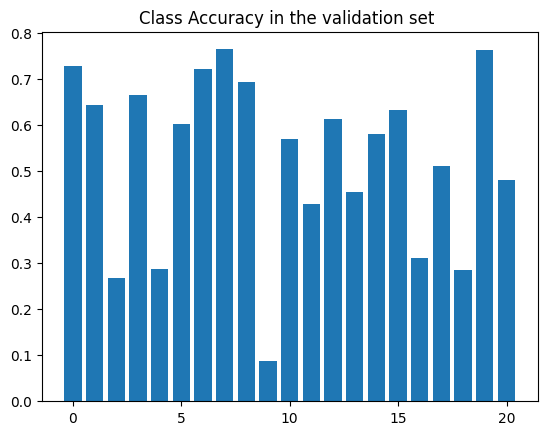


Test set (736): Average loss: 0.7666, mIoU: 0.5283

PSPnetLite training, epoch 6
Train Epoch: 6 [240/8498 (3%)]	Loss: 0.971064, Learning rate: 0.001000
Train Epoch: 6 [480/8498 (6%)]	Loss: 0.466829, Learning rate: 0.001000
Train Epoch: 6 [720/8498 (8%)]	Loss: 0.570343, Learning rate: 0.001000
Train Epoch: 6 [960/8498 (11%)]	Loss: 0.466984, Learning rate: 0.001000
Train Epoch: 6 [1200/8498 (14%)]	Loss: 0.505605, Learning rate: 0.001000
Train Epoch: 6 [1440/8498 (17%)]	Loss: 0.429096, Learning rate: 0.001000
Train Epoch: 6 [1680/8498 (20%)]	Loss: 0.583799, Learning rate: 0.001000
Train Epoch: 6 [1920/8498 (23%)]	Loss: 0.675121, Learning rate: 0.001000
Train Epoch: 6 [2160/8498 (25%)]	Loss: 0.567948, Learning rate: 0.001000
Train Epoch: 6 [2400/8498 (28%)]	Loss: 0.500933, Learning rate: 0.001000
Train Epoch: 6 [2640/8498 (31%)]	Loss: 0.539546, Learning rate: 0.001000
Train Epoch: 6 [2880/8498 (34%)]	Loss: 0.662173, Learning rate: 0.001000
Train Epoch: 6 [3120/8498 (37%)]	Loss: 0.553156, 

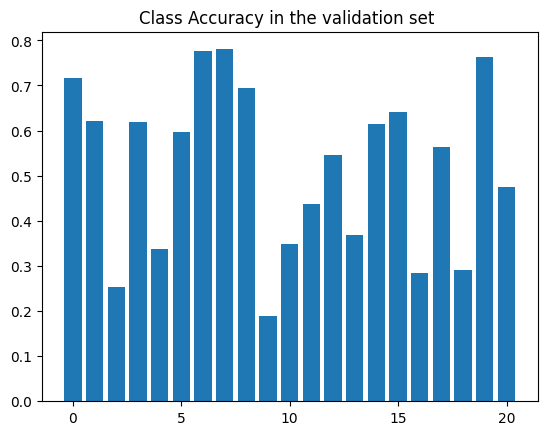


Test set (736): Average loss: 0.7691, mIoU: 0.5200

PSPnetLite training, epoch 7
Train Epoch: 7 [240/8498 (3%)]	Loss: 0.374292, Learning rate: 0.001000
Train Epoch: 7 [480/8498 (6%)]	Loss: 0.613598, Learning rate: 0.001000
Train Epoch: 7 [720/8498 (8%)]	Loss: 0.797959, Learning rate: 0.001000
Train Epoch: 7 [960/8498 (11%)]	Loss: 0.751550, Learning rate: 0.001000
Train Epoch: 7 [1200/8498 (14%)]	Loss: 0.417636, Learning rate: 0.001000
Train Epoch: 7 [1440/8498 (17%)]	Loss: 0.939821, Learning rate: 0.001000
Train Epoch: 7 [1680/8498 (20%)]	Loss: 0.553066, Learning rate: 0.001000
Train Epoch: 7 [1920/8498 (23%)]	Loss: 0.581115, Learning rate: 0.001000
Train Epoch: 7 [2160/8498 (25%)]	Loss: 0.462999, Learning rate: 0.001000
Train Epoch: 7 [2400/8498 (28%)]	Loss: 0.660466, Learning rate: 0.001000
Train Epoch: 7 [2640/8498 (31%)]	Loss: 0.460380, Learning rate: 0.001000
Train Epoch: 7 [2880/8498 (34%)]	Loss: 0.571607, Learning rate: 0.001000
Train Epoch: 7 [3120/8498 (37%)]	Loss: 0.679937, 

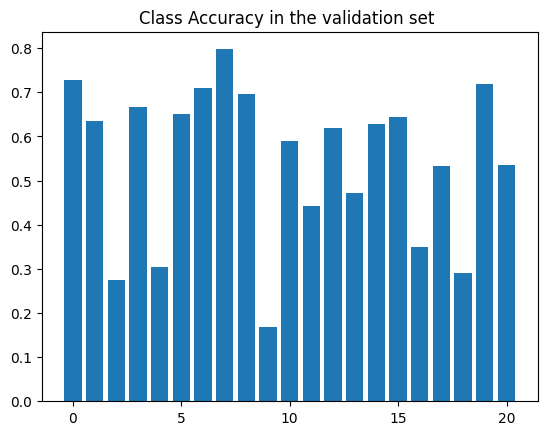


Test set (736): Average loss: 0.7368, mIoU: 0.5453

PSPnetLite training, epoch 8
Train Epoch: 8 [240/8498 (3%)]	Loss: 0.611147, Learning rate: 0.001000
Train Epoch: 8 [480/8498 (6%)]	Loss: 0.541344, Learning rate: 0.001000
Train Epoch: 8 [720/8498 (8%)]	Loss: 0.509776, Learning rate: 0.001000
Train Epoch: 8 [960/8498 (11%)]	Loss: 0.496588, Learning rate: 0.001000
Train Epoch: 8 [1200/8498 (14%)]	Loss: 0.422181, Learning rate: 0.001000
Train Epoch: 8 [1440/8498 (17%)]	Loss: 0.610852, Learning rate: 0.001000
Train Epoch: 8 [1680/8498 (20%)]	Loss: 0.471823, Learning rate: 0.001000
Train Epoch: 8 [1920/8498 (23%)]	Loss: 0.861836, Learning rate: 0.001000
Train Epoch: 8 [2160/8498 (25%)]	Loss: 0.665230, Learning rate: 0.001000
Train Epoch: 8 [2400/8498 (28%)]	Loss: 0.438034, Learning rate: 0.001000
Train Epoch: 8 [2640/8498 (31%)]	Loss: 0.465792, Learning rate: 0.001000
Train Epoch: 8 [2880/8498 (34%)]	Loss: 0.571129, Learning rate: 0.001000
Train Epoch: 8 [3120/8498 (37%)]	Loss: 0.461733, 

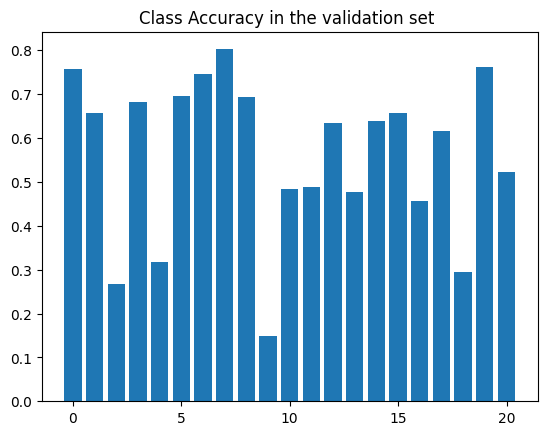


Test set (736): Average loss: 0.7033, mIoU: 0.5616

PSPnetLite training, epoch 9
Train Epoch: 9 [240/8498 (3%)]	Loss: 0.456556, Learning rate: 0.001000
Train Epoch: 9 [480/8498 (6%)]	Loss: 0.647270, Learning rate: 0.001000
Train Epoch: 9 [720/8498 (8%)]	Loss: 0.588283, Learning rate: 0.001000
Train Epoch: 9 [960/8498 (11%)]	Loss: 0.536176, Learning rate: 0.001000
Train Epoch: 9 [1200/8498 (14%)]	Loss: 0.728463, Learning rate: 0.001000
Train Epoch: 9 [1440/8498 (17%)]	Loss: 0.347869, Learning rate: 0.001000
Train Epoch: 9 [1680/8498 (20%)]	Loss: 0.605136, Learning rate: 0.001000
Train Epoch: 9 [1920/8498 (23%)]	Loss: 0.517210, Learning rate: 0.001000
Train Epoch: 9 [2160/8498 (25%)]	Loss: 0.342426, Learning rate: 0.001000
Train Epoch: 9 [2400/8498 (28%)]	Loss: 0.381182, Learning rate: 0.001000
Train Epoch: 9 [2640/8498 (31%)]	Loss: 0.827592, Learning rate: 0.001000
Train Epoch: 9 [2880/8498 (34%)]	Loss: 0.599255, Learning rate: 0.001000
Train Epoch: 9 [3120/8498 (37%)]	Loss: 0.455490, 

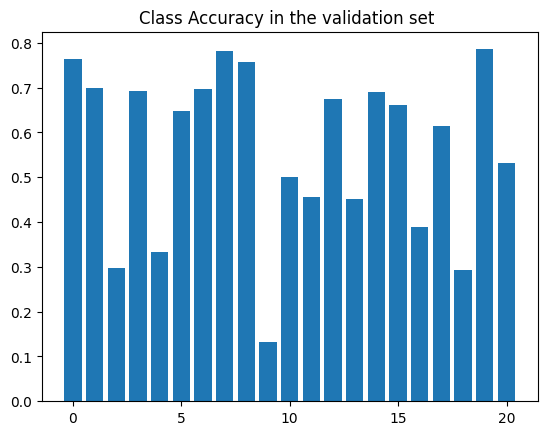


Test set (736): Average loss: 0.6645, mIoU: 0.5644

PSPnetLite training, epoch 10
Train Epoch: 10 [240/8498 (3%)]	Loss: 0.558198, Learning rate: 0.001000
Train Epoch: 10 [480/8498 (6%)]	Loss: 0.368877, Learning rate: 0.001000
Train Epoch: 10 [720/8498 (8%)]	Loss: 0.435695, Learning rate: 0.001000
Train Epoch: 10 [960/8498 (11%)]	Loss: 0.374019, Learning rate: 0.001000
Train Epoch: 10 [1200/8498 (14%)]	Loss: 0.514805, Learning rate: 0.001000
Train Epoch: 10 [1440/8498 (17%)]	Loss: 0.447639, Learning rate: 0.001000
Train Epoch: 10 [1680/8498 (20%)]	Loss: 0.519943, Learning rate: 0.001000
Train Epoch: 10 [1920/8498 (23%)]	Loss: 0.402905, Learning rate: 0.001000
Train Epoch: 10 [2160/8498 (25%)]	Loss: 0.890413, Learning rate: 0.001000
Train Epoch: 10 [2400/8498 (28%)]	Loss: 0.621431, Learning rate: 0.001000
Train Epoch: 10 [2640/8498 (31%)]	Loss: 0.264900, Learning rate: 0.001000
Train Epoch: 10 [2880/8498 (34%)]	Loss: 0.411825, Learning rate: 0.001000
Train Epoch: 10 [3120/8498 (37%)]	Lo

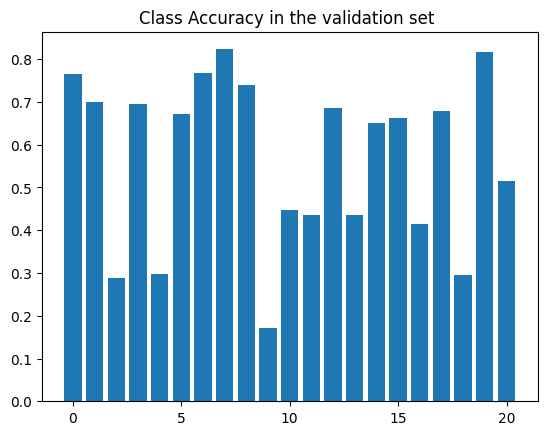


Test set (736): Average loss: 0.6388, mIoU: 0.5695

PSPnetLite training, epoch 11
Train Epoch: 11 [240/8498 (3%)]	Loss: 0.382008, Learning rate: 0.001000
Train Epoch: 11 [480/8498 (6%)]	Loss: 0.510620, Learning rate: 0.001000
Train Epoch: 11 [720/8498 (8%)]	Loss: 0.751688, Learning rate: 0.001000
Train Epoch: 11 [960/8498 (11%)]	Loss: 0.391749, Learning rate: 0.001000
Train Epoch: 11 [1200/8498 (14%)]	Loss: 0.487600, Learning rate: 0.001000
Train Epoch: 11 [1440/8498 (17%)]	Loss: 0.504028, Learning rate: 0.001000
Train Epoch: 11 [1680/8498 (20%)]	Loss: 0.522694, Learning rate: 0.001000
Train Epoch: 11 [1920/8498 (23%)]	Loss: 0.563437, Learning rate: 0.001000
Train Epoch: 11 [2160/8498 (25%)]	Loss: 0.650177, Learning rate: 0.001000
Train Epoch: 11 [2400/8498 (28%)]	Loss: 0.463163, Learning rate: 0.001000
Train Epoch: 11 [2640/8498 (31%)]	Loss: 0.372077, Learning rate: 0.001000
Train Epoch: 11 [2880/8498 (34%)]	Loss: 0.521101, Learning rate: 0.001000
Train Epoch: 11 [3120/8498 (37%)]	Lo

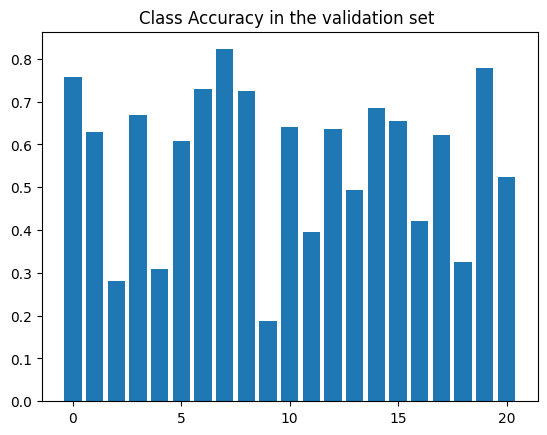


Test set (736): Average loss: 0.6414, mIoU: 0.5662

PSPnetLite training, epoch 12
Train Epoch: 12 [240/8498 (3%)]	Loss: 0.642963, Learning rate: 0.001000
Train Epoch: 12 [480/8498 (6%)]	Loss: 0.582765, Learning rate: 0.001000
Train Epoch: 12 [720/8498 (8%)]	Loss: 0.391478, Learning rate: 0.001000
Train Epoch: 12 [960/8498 (11%)]	Loss: 0.865427, Learning rate: 0.001000
Train Epoch: 12 [1200/8498 (14%)]	Loss: 0.422757, Learning rate: 0.001000
Train Epoch: 12 [1440/8498 (17%)]	Loss: 0.471598, Learning rate: 0.001000
Train Epoch: 12 [1680/8498 (20%)]	Loss: 0.354980, Learning rate: 0.001000
Train Epoch: 12 [1920/8498 (23%)]	Loss: 0.364138, Learning rate: 0.001000
Train Epoch: 12 [2160/8498 (25%)]	Loss: 0.291519, Learning rate: 0.001000
Train Epoch: 12 [2400/8498 (28%)]	Loss: 0.538842, Learning rate: 0.001000
Train Epoch: 12 [2640/8498 (31%)]	Loss: 0.353903, Learning rate: 0.001000
Train Epoch: 12 [2880/8498 (34%)]	Loss: 0.563532, Learning rate: 0.001000
Train Epoch: 12 [3120/8498 (37%)]	Lo

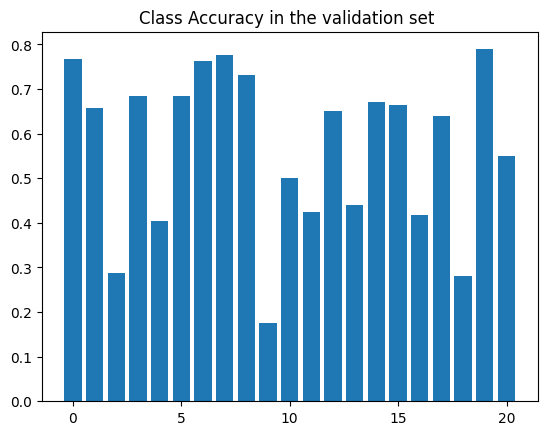


Test set (736): Average loss: 0.6495, mIoU: 0.5692

PSPnetLite training, epoch 13
Train Epoch: 13 [240/8498 (3%)]	Loss: 0.652707, Learning rate: 0.001000
Train Epoch: 13 [480/8498 (6%)]	Loss: 0.574885, Learning rate: 0.001000
Train Epoch: 13 [720/8498 (8%)]	Loss: 0.813040, Learning rate: 0.001000
Train Epoch: 13 [960/8498 (11%)]	Loss: 0.459180, Learning rate: 0.001000
Train Epoch: 13 [1200/8498 (14%)]	Loss: 0.485011, Learning rate: 0.001000
Train Epoch: 13 [1440/8498 (17%)]	Loss: 0.459602, Learning rate: 0.001000
Train Epoch: 13 [1680/8498 (20%)]	Loss: 0.685692, Learning rate: 0.001000
Train Epoch: 13 [1920/8498 (23%)]	Loss: 0.399331, Learning rate: 0.001000
Train Epoch: 13 [2160/8498 (25%)]	Loss: 0.209851, Learning rate: 0.001000
Train Epoch: 13 [2400/8498 (28%)]	Loss: 0.544487, Learning rate: 0.001000
Train Epoch: 13 [2640/8498 (31%)]	Loss: 0.362615, Learning rate: 0.001000
Train Epoch: 13 [2880/8498 (34%)]	Loss: 0.608277, Learning rate: 0.001000
Train Epoch: 13 [3120/8498 (37%)]	Lo

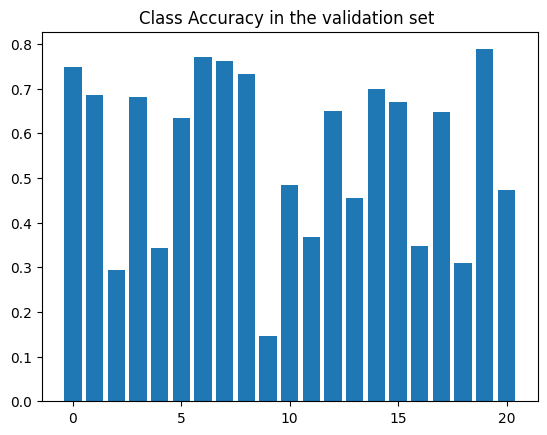


Test set (736): Average loss: 0.6286, mIoU: 0.5564

PSPnetLite training, epoch 14
Train Epoch: 14 [240/8498 (3%)]	Loss: 0.504602, Learning rate: 0.001000
Train Epoch: 14 [480/8498 (6%)]	Loss: 0.394969, Learning rate: 0.001000
Train Epoch: 14 [720/8498 (8%)]	Loss: 0.722146, Learning rate: 0.001000
Train Epoch: 14 [960/8498 (11%)]	Loss: 0.709892, Learning rate: 0.001000
Train Epoch: 14 [1200/8498 (14%)]	Loss: 0.404765, Learning rate: 0.001000
Train Epoch: 14 [1440/8498 (17%)]	Loss: 0.660292, Learning rate: 0.001000
Train Epoch: 14 [1680/8498 (20%)]	Loss: 0.483945, Learning rate: 0.001000
Train Epoch: 14 [1920/8498 (23%)]	Loss: 0.672750, Learning rate: 0.001000
Train Epoch: 14 [2160/8498 (25%)]	Loss: 0.475861, Learning rate: 0.001000
Train Epoch: 14 [2400/8498 (28%)]	Loss: 0.316781, Learning rate: 0.001000
Train Epoch: 14 [2640/8498 (31%)]	Loss: 0.497622, Learning rate: 0.001000
Train Epoch: 14 [2880/8498 (34%)]	Loss: 0.337085, Learning rate: 0.001000
Train Epoch: 14 [3120/8498 (37%)]	Lo

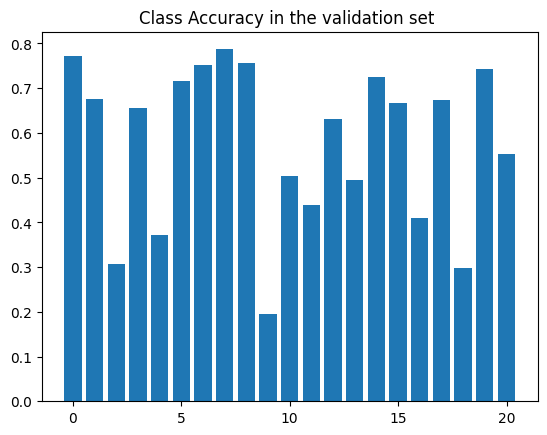


Test set (736): Average loss: 0.6038, mIoU: 0.5774

PSPnetLite training, epoch 15
Train Epoch: 15 [240/8498 (3%)]	Loss: 0.359001, Learning rate: 0.001000
Train Epoch: 15 [480/8498 (6%)]	Loss: 0.433606, Learning rate: 0.001000
Train Epoch: 15 [720/8498 (8%)]	Loss: 0.420579, Learning rate: 0.001000
Train Epoch: 15 [960/8498 (11%)]	Loss: 0.542910, Learning rate: 0.001000
Train Epoch: 15 [1200/8498 (14%)]	Loss: 0.444741, Learning rate: 0.001000
Train Epoch: 15 [1440/8498 (17%)]	Loss: 0.421859, Learning rate: 0.001000
Train Epoch: 15 [1680/8498 (20%)]	Loss: 0.476575, Learning rate: 0.001000
Train Epoch: 15 [1920/8498 (23%)]	Loss: 0.493322, Learning rate: 0.001000
Train Epoch: 15 [2160/8498 (25%)]	Loss: 0.401248, Learning rate: 0.001000
Train Epoch: 15 [2400/8498 (28%)]	Loss: 0.497618, Learning rate: 0.001000
Train Epoch: 15 [2640/8498 (31%)]	Loss: 0.443928, Learning rate: 0.001000
Train Epoch: 15 [2880/8498 (34%)]	Loss: 0.331638, Learning rate: 0.001000
Train Epoch: 15 [3120/8498 (37%)]	Lo

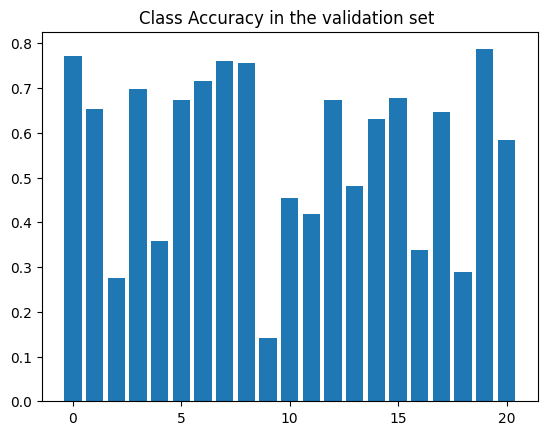


Test set (736): Average loss: 0.6162, mIoU: 0.5610

PSPnetLite training, epoch 16
Train Epoch: 16 [240/8498 (3%)]	Loss: 0.519498, Learning rate: 0.001000
Train Epoch: 16 [480/8498 (6%)]	Loss: 0.527693, Learning rate: 0.001000
Train Epoch: 16 [720/8498 (8%)]	Loss: 0.342435, Learning rate: 0.001000
Train Epoch: 16 [960/8498 (11%)]	Loss: 0.487240, Learning rate: 0.001000
Train Epoch: 16 [1200/8498 (14%)]	Loss: 0.375035, Learning rate: 0.001000
Train Epoch: 16 [1440/8498 (17%)]	Loss: 0.376708, Learning rate: 0.001000
Train Epoch: 16 [1680/8498 (20%)]	Loss: 0.324948, Learning rate: 0.001000
Train Epoch: 16 [1920/8498 (23%)]	Loss: 0.583740, Learning rate: 0.001000
Train Epoch: 16 [2160/8498 (25%)]	Loss: 0.507816, Learning rate: 0.001000
Train Epoch: 16 [2400/8498 (28%)]	Loss: 0.541240, Learning rate: 0.001000
Train Epoch: 16 [2640/8498 (31%)]	Loss: 0.577010, Learning rate: 0.001000
Train Epoch: 16 [2880/8498 (34%)]	Loss: 0.437029, Learning rate: 0.001000
Train Epoch: 16 [3120/8498 (37%)]	Lo

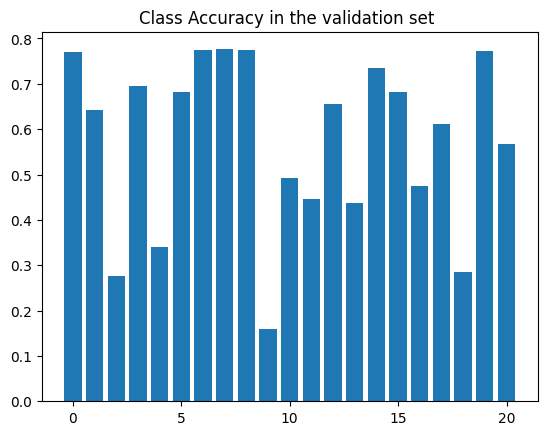


Test set (736): Average loss: 0.6275, mIoU: 0.5739

PSPnetLite training, epoch 17
Train Epoch: 17 [240/8498 (3%)]	Loss: 0.515506, Learning rate: 0.001000
Train Epoch: 17 [480/8498 (6%)]	Loss: 0.436935, Learning rate: 0.001000
Train Epoch: 17 [720/8498 (8%)]	Loss: 0.432675, Learning rate: 0.001000
Train Epoch: 17 [960/8498 (11%)]	Loss: 0.479298, Learning rate: 0.001000
Train Epoch: 17 [1200/8498 (14%)]	Loss: 0.360513, Learning rate: 0.001000
Train Epoch: 17 [1440/8498 (17%)]	Loss: 0.461479, Learning rate: 0.001000
Train Epoch: 17 [1680/8498 (20%)]	Loss: 0.321124, Learning rate: 0.001000
Train Epoch: 17 [1920/8498 (23%)]	Loss: 0.382798, Learning rate: 0.001000
Train Epoch: 17 [2160/8498 (25%)]	Loss: 0.299130, Learning rate: 0.001000
Train Epoch: 17 [2400/8498 (28%)]	Loss: 0.348035, Learning rate: 0.001000
Train Epoch: 17 [2640/8498 (31%)]	Loss: 0.422460, Learning rate: 0.001000
Train Epoch: 17 [2880/8498 (34%)]	Loss: 0.540944, Learning rate: 0.001000
Train Epoch: 17 [3120/8498 (37%)]	Lo

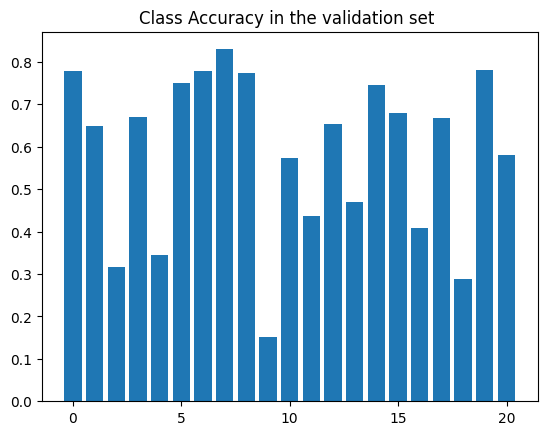


Test set (736): Average loss: 0.6130, mIoU: 0.5866

PSPnetLite training, epoch 18
Train Epoch: 18 [240/8498 (3%)]	Loss: 0.404005, Learning rate: 0.001000
Train Epoch: 18 [480/8498 (6%)]	Loss: 0.370628, Learning rate: 0.001000
Train Epoch: 18 [720/8498 (8%)]	Loss: 0.366766, Learning rate: 0.001000
Train Epoch: 18 [960/8498 (11%)]	Loss: 0.431863, Learning rate: 0.001000
Train Epoch: 18 [1200/8498 (14%)]	Loss: 0.259325, Learning rate: 0.001000
Train Epoch: 18 [1440/8498 (17%)]	Loss: 0.321846, Learning rate: 0.001000
Train Epoch: 18 [1680/8498 (20%)]	Loss: 0.468453, Learning rate: 0.001000
Train Epoch: 18 [1920/8498 (23%)]	Loss: 0.500088, Learning rate: 0.001000
Train Epoch: 18 [2160/8498 (25%)]	Loss: 0.380081, Learning rate: 0.001000
Train Epoch: 18 [2400/8498 (28%)]	Loss: 0.504874, Learning rate: 0.001000
Train Epoch: 18 [2640/8498 (31%)]	Loss: 0.499090, Learning rate: 0.001000
Train Epoch: 18 [2880/8498 (34%)]	Loss: 0.256755, Learning rate: 0.001000
Train Epoch: 18 [3120/8498 (37%)]	Lo

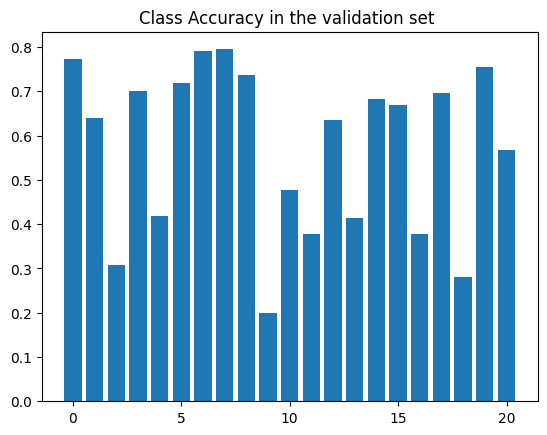


Test set (736): Average loss: 0.6752, mIoU: 0.5721

PSPnetLite training, epoch 19
Train Epoch: 19 [240/8498 (3%)]	Loss: 0.521375, Learning rate: 0.001000
Train Epoch: 19 [480/8498 (6%)]	Loss: 0.380053, Learning rate: 0.001000
Train Epoch: 19 [720/8498 (8%)]	Loss: 0.343466, Learning rate: 0.001000
Train Epoch: 19 [960/8498 (11%)]	Loss: 0.411004, Learning rate: 0.001000
Train Epoch: 19 [1200/8498 (14%)]	Loss: 0.306241, Learning rate: 0.001000
Train Epoch: 19 [1440/8498 (17%)]	Loss: 0.312498, Learning rate: 0.001000
Train Epoch: 19 [1680/8498 (20%)]	Loss: 0.446645, Learning rate: 0.001000
Train Epoch: 19 [1920/8498 (23%)]	Loss: 0.481049, Learning rate: 0.001000
Train Epoch: 19 [2160/8498 (25%)]	Loss: 0.542851, Learning rate: 0.001000
Train Epoch: 19 [2400/8498 (28%)]	Loss: 0.381194, Learning rate: 0.001000
Train Epoch: 19 [2640/8498 (31%)]	Loss: 0.596755, Learning rate: 0.001000
Train Epoch: 19 [2880/8498 (34%)]	Loss: 0.507249, Learning rate: 0.001000
Train Epoch: 19 [3120/8498 (37%)]	Lo

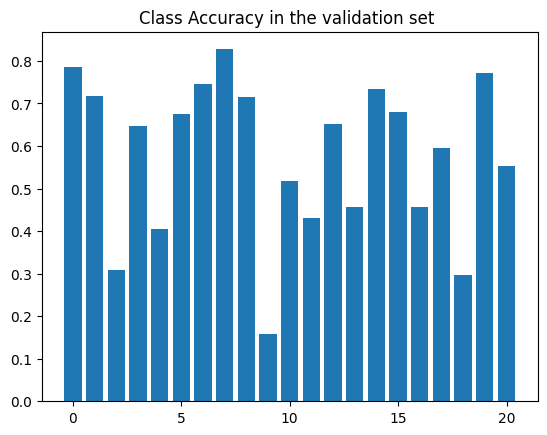


Test set (736): Average loss: 0.6214, mIoU: 0.5776

PSPnetLite training, epoch 20
Train Epoch: 20 [240/8498 (3%)]	Loss: 0.333195, Learning rate: 0.001000
Train Epoch: 20 [480/8498 (6%)]	Loss: 0.302785, Learning rate: 0.001000
Train Epoch: 20 [720/8498 (8%)]	Loss: 0.386162, Learning rate: 0.001000
Train Epoch: 20 [960/8498 (11%)]	Loss: 0.441515, Learning rate: 0.001000
Train Epoch: 20 [1200/8498 (14%)]	Loss: 0.464789, Learning rate: 0.001000
Train Epoch: 20 [1440/8498 (17%)]	Loss: 0.456919, Learning rate: 0.001000
Train Epoch: 20 [1680/8498 (20%)]	Loss: 0.682479, Learning rate: 0.001000
Train Epoch: 20 [1920/8498 (23%)]	Loss: 0.404212, Learning rate: 0.001000
Train Epoch: 20 [2160/8498 (25%)]	Loss: 0.337215, Learning rate: 0.001000
Train Epoch: 20 [2400/8498 (28%)]	Loss: 0.307220, Learning rate: 0.001000
Train Epoch: 20 [2640/8498 (31%)]	Loss: 0.573559, Learning rate: 0.001000
Train Epoch: 20 [2880/8498 (34%)]	Loss: 0.272919, Learning rate: 0.001000
Train Epoch: 20 [3120/8498 (37%)]	Lo

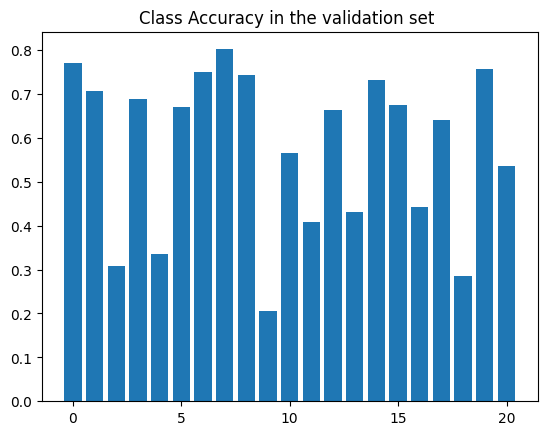


Test set (736): Average loss: 0.6717, mIoU: 0.5767

PSPnetLite training, epoch 21
Train Epoch: 21 [240/8498 (3%)]	Loss: 0.335543, Learning rate: 0.001000
Train Epoch: 21 [480/8498 (6%)]	Loss: 0.276754, Learning rate: 0.001000
Train Epoch: 21 [720/8498 (8%)]	Loss: 0.402899, Learning rate: 0.001000
Train Epoch: 21 [960/8498 (11%)]	Loss: 0.418212, Learning rate: 0.001000
Train Epoch: 21 [1200/8498 (14%)]	Loss: 0.453357, Learning rate: 0.001000
Train Epoch: 21 [1440/8498 (17%)]	Loss: 0.370064, Learning rate: 0.001000
Train Epoch: 21 [1680/8498 (20%)]	Loss: 0.512559, Learning rate: 0.001000
Train Epoch: 21 [1920/8498 (23%)]	Loss: 0.495195, Learning rate: 0.001000
Train Epoch: 21 [2160/8498 (25%)]	Loss: 0.333797, Learning rate: 0.001000
Train Epoch: 21 [2400/8498 (28%)]	Loss: 0.280827, Learning rate: 0.001000
Train Epoch: 21 [2640/8498 (31%)]	Loss: 0.294180, Learning rate: 0.001000
Train Epoch: 21 [2880/8498 (34%)]	Loss: 0.358432, Learning rate: 0.001000
Train Epoch: 21 [3120/8498 (37%)]	Lo

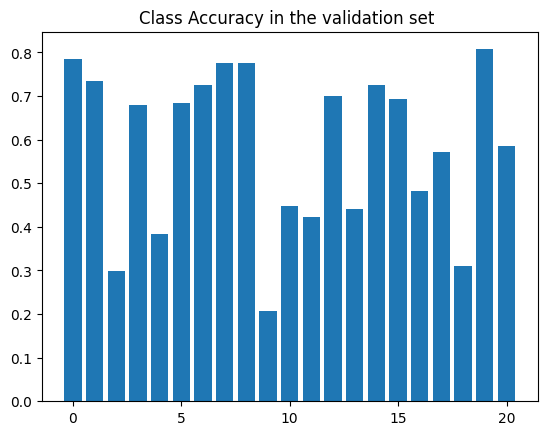


Test set (736): Average loss: 0.6250, mIoU: 0.5825

PSPnetLite training, epoch 22
Train Epoch: 22 [240/8498 (3%)]	Loss: 0.476613, Learning rate: 0.001000
Train Epoch: 22 [480/8498 (6%)]	Loss: 0.470845, Learning rate: 0.001000
Train Epoch: 22 [720/8498 (8%)]	Loss: 0.262872, Learning rate: 0.001000
Train Epoch: 22 [960/8498 (11%)]	Loss: 0.418771, Learning rate: 0.001000
Train Epoch: 22 [1200/8498 (14%)]	Loss: 0.463522, Learning rate: 0.001000
Train Epoch: 22 [1440/8498 (17%)]	Loss: 0.389438, Learning rate: 0.001000
Train Epoch: 22 [1680/8498 (20%)]	Loss: 0.467453, Learning rate: 0.001000
Train Epoch: 22 [1920/8498 (23%)]	Loss: 0.327990, Learning rate: 0.001000
Train Epoch: 22 [2160/8498 (25%)]	Loss: 0.271351, Learning rate: 0.001000
Train Epoch: 22 [2400/8498 (28%)]	Loss: 0.375139, Learning rate: 0.001000
Train Epoch: 22 [2640/8498 (31%)]	Loss: 0.316794, Learning rate: 0.001000
Train Epoch: 22 [2880/8498 (34%)]	Loss: 0.402211, Learning rate: 0.001000
Train Epoch: 22 [3120/8498 (37%)]	Lo

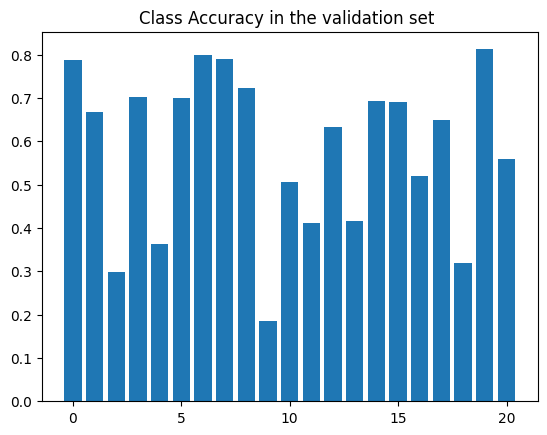


Test set (736): Average loss: 0.6220, mIoU: 0.5823

PSPnetLite training, epoch 23
Train Epoch: 23 [240/8498 (3%)]	Loss: 0.308327, Learning rate: 0.001000
Train Epoch: 23 [480/8498 (6%)]	Loss: 0.251100, Learning rate: 0.001000
Train Epoch: 23 [720/8498 (8%)]	Loss: 0.326734, Learning rate: 0.001000
Train Epoch: 23 [960/8498 (11%)]	Loss: 0.322999, Learning rate: 0.001000
Train Epoch: 23 [1200/8498 (14%)]	Loss: 0.318619, Learning rate: 0.001000
Train Epoch: 23 [1440/8498 (17%)]	Loss: 0.191670, Learning rate: 0.001000
Train Epoch: 23 [1680/8498 (20%)]	Loss: 0.396829, Learning rate: 0.001000
Train Epoch: 23 [1920/8498 (23%)]	Loss: 0.319103, Learning rate: 0.001000
Train Epoch: 23 [2160/8498 (25%)]	Loss: 0.458376, Learning rate: 0.001000
Train Epoch: 23 [2400/8498 (28%)]	Loss: 0.565196, Learning rate: 0.001000
Train Epoch: 23 [2640/8498 (31%)]	Loss: 0.313298, Learning rate: 0.001000
Train Epoch: 23 [2880/8498 (34%)]	Loss: 0.301914, Learning rate: 0.001000
Train Epoch: 23 [3120/8498 (37%)]	Lo

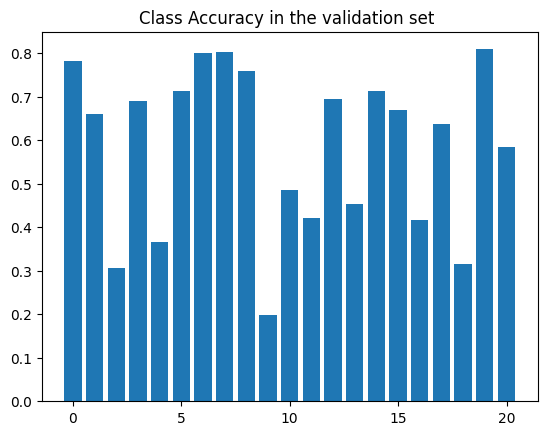


Test set (736): Average loss: 0.6610, mIoU: 0.5845

PSPnetLite training, epoch 24
Train Epoch: 24 [240/8498 (3%)]	Loss: 0.589371, Learning rate: 0.001000
Train Epoch: 24 [480/8498 (6%)]	Loss: 0.361404, Learning rate: 0.001000
Train Epoch: 24 [720/8498 (8%)]	Loss: 0.439950, Learning rate: 0.001000
Train Epoch: 24 [960/8498 (11%)]	Loss: 0.347364, Learning rate: 0.001000
Train Epoch: 24 [1200/8498 (14%)]	Loss: 0.460003, Learning rate: 0.001000
Train Epoch: 24 [1440/8498 (17%)]	Loss: 0.419984, Learning rate: 0.001000
Train Epoch: 24 [1680/8498 (20%)]	Loss: 0.362618, Learning rate: 0.001000
Train Epoch: 24 [1920/8498 (23%)]	Loss: 0.350058, Learning rate: 0.001000
Train Epoch: 24 [2160/8498 (25%)]	Loss: 0.334841, Learning rate: 0.001000
Train Epoch: 24 [2400/8498 (28%)]	Loss: 0.373989, Learning rate: 0.001000
Train Epoch: 24 [2640/8498 (31%)]	Loss: 0.358265, Learning rate: 0.001000
Train Epoch: 24 [2880/8498 (34%)]	Loss: 0.338274, Learning rate: 0.001000
Train Epoch: 24 [3120/8498 (37%)]	Lo

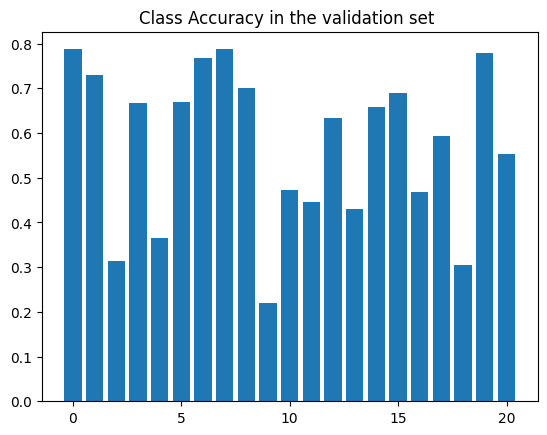


Test set (736): Average loss: 0.6499, mIoU: 0.5733

PSPnetLite training, epoch 25
Train Epoch: 25 [240/8498 (3%)]	Loss: 0.374724, Learning rate: 0.001000
Train Epoch: 25 [480/8498 (6%)]	Loss: 0.442419, Learning rate: 0.001000
Train Epoch: 25 [720/8498 (8%)]	Loss: 0.560950, Learning rate: 0.001000
Train Epoch: 25 [960/8498 (11%)]	Loss: 0.536233, Learning rate: 0.001000
Train Epoch: 25 [1200/8498 (14%)]	Loss: 0.344751, Learning rate: 0.001000
Train Epoch: 25 [1440/8498 (17%)]	Loss: 0.390625, Learning rate: 0.001000
Train Epoch: 25 [1680/8498 (20%)]	Loss: 0.413807, Learning rate: 0.001000
Train Epoch: 25 [1920/8498 (23%)]	Loss: 0.376538, Learning rate: 0.001000
Train Epoch: 25 [2160/8498 (25%)]	Loss: 0.274056, Learning rate: 0.001000
Train Epoch: 25 [2400/8498 (28%)]	Loss: 0.316526, Learning rate: 0.001000
Train Epoch: 25 [2640/8498 (31%)]	Loss: 0.330077, Learning rate: 0.001000
Train Epoch: 25 [2880/8498 (34%)]	Loss: 0.312188, Learning rate: 0.001000
Train Epoch: 25 [3120/8498 (37%)]	Lo

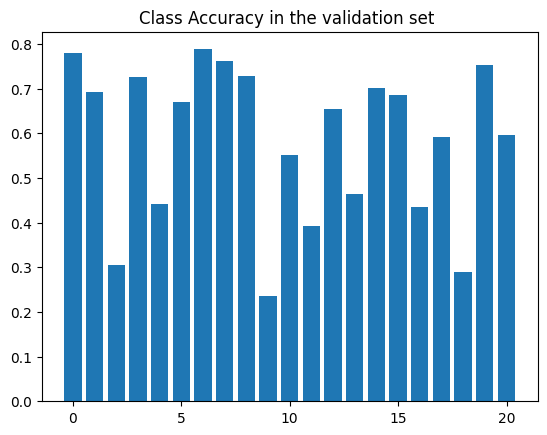


Test set (736): Average loss: 0.5910, mIoU: 0.5827

PSPnetLite training, epoch 26
Train Epoch: 26 [240/8498 (3%)]	Loss: 0.384463, Learning rate: 0.001000
Train Epoch: 26 [480/8498 (6%)]	Loss: 0.333592, Learning rate: 0.001000
Train Epoch: 26 [720/8498 (8%)]	Loss: 0.372016, Learning rate: 0.001000
Train Epoch: 26 [960/8498 (11%)]	Loss: 0.469140, Learning rate: 0.001000
Train Epoch: 26 [1200/8498 (14%)]	Loss: 0.362501, Learning rate: 0.001000
Train Epoch: 26 [1440/8498 (17%)]	Loss: 0.297684, Learning rate: 0.001000
Train Epoch: 26 [1680/8498 (20%)]	Loss: 0.615838, Learning rate: 0.001000
Train Epoch: 26 [1920/8498 (23%)]	Loss: 0.445686, Learning rate: 0.001000
Train Epoch: 26 [2160/8498 (25%)]	Loss: 0.357748, Learning rate: 0.001000
Train Epoch: 26 [2400/8498 (28%)]	Loss: 0.293873, Learning rate: 0.001000
Train Epoch: 26 [2640/8498 (31%)]	Loss: 0.429360, Learning rate: 0.001000
Train Epoch: 26 [2880/8498 (34%)]	Loss: 0.399801, Learning rate: 0.001000
Train Epoch: 26 [3120/8498 (37%)]	Lo

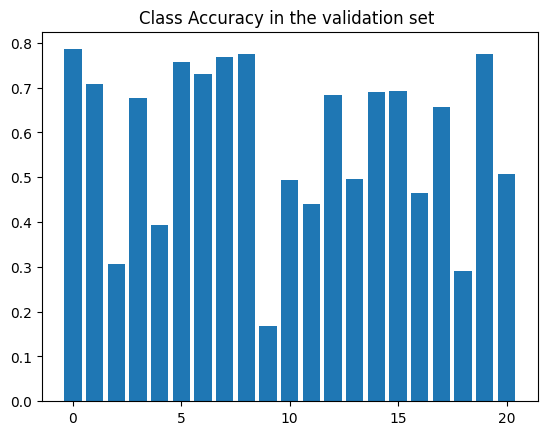


Test set (736): Average loss: 0.6201, mIoU: 0.5839

PSPnetLite training, epoch 27
Train Epoch: 27 [240/8498 (3%)]	Loss: 0.367864, Learning rate: 0.001000
Train Epoch: 27 [480/8498 (6%)]	Loss: 0.289717, Learning rate: 0.001000
Train Epoch: 27 [720/8498 (8%)]	Loss: 0.667860, Learning rate: 0.001000
Train Epoch: 27 [960/8498 (11%)]	Loss: 0.329209, Learning rate: 0.001000
Train Epoch: 27 [1200/8498 (14%)]	Loss: 0.483548, Learning rate: 0.001000
Train Epoch: 27 [1440/8498 (17%)]	Loss: 0.237379, Learning rate: 0.001000
Train Epoch: 27 [1680/8498 (20%)]	Loss: 0.352577, Learning rate: 0.001000
Train Epoch: 27 [1920/8498 (23%)]	Loss: 0.319460, Learning rate: 0.001000
Train Epoch: 27 [2160/8498 (25%)]	Loss: 0.524213, Learning rate: 0.001000
Train Epoch: 27 [2400/8498 (28%)]	Loss: 0.460113, Learning rate: 0.001000
Train Epoch: 27 [2640/8498 (31%)]	Loss: 0.309548, Learning rate: 0.001000
Train Epoch: 27 [2880/8498 (34%)]	Loss: 0.308524, Learning rate: 0.001000
Train Epoch: 27 [3120/8498 (37%)]	Lo

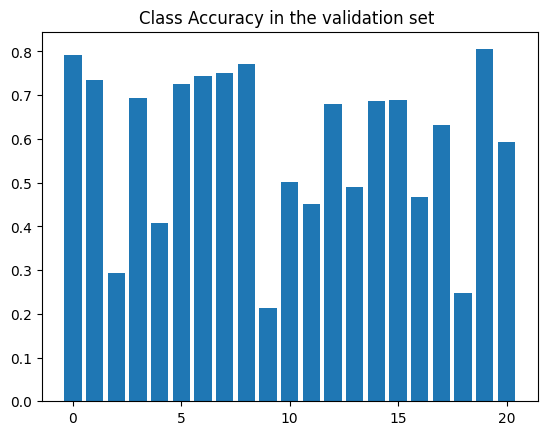


Test set (736): Average loss: 0.5990, mIoU: 0.5889

PSPnetLite training, epoch 28
Train Epoch: 28 [240/8498 (3%)]	Loss: 0.364631, Learning rate: 0.001000
Train Epoch: 28 [480/8498 (6%)]	Loss: 0.228068, Learning rate: 0.001000
Train Epoch: 28 [720/8498 (8%)]	Loss: 0.388079, Learning rate: 0.001000
Train Epoch: 28 [960/8498 (11%)]	Loss: 0.289180, Learning rate: 0.001000
Train Epoch: 28 [1200/8498 (14%)]	Loss: 0.364530, Learning rate: 0.001000
Train Epoch: 28 [1440/8498 (17%)]	Loss: 0.493858, Learning rate: 0.001000
Train Epoch: 28 [1680/8498 (20%)]	Loss: 0.508056, Learning rate: 0.001000
Train Epoch: 28 [1920/8498 (23%)]	Loss: 0.303907, Learning rate: 0.001000
Train Epoch: 28 [2160/8498 (25%)]	Loss: 0.393287, Learning rate: 0.001000
Train Epoch: 28 [2400/8498 (28%)]	Loss: 0.377753, Learning rate: 0.001000
Train Epoch: 28 [2640/8498 (31%)]	Loss: 0.225863, Learning rate: 0.001000
Train Epoch: 28 [2880/8498 (34%)]	Loss: 0.444383, Learning rate: 0.001000
Train Epoch: 28 [3120/8498 (37%)]	Lo

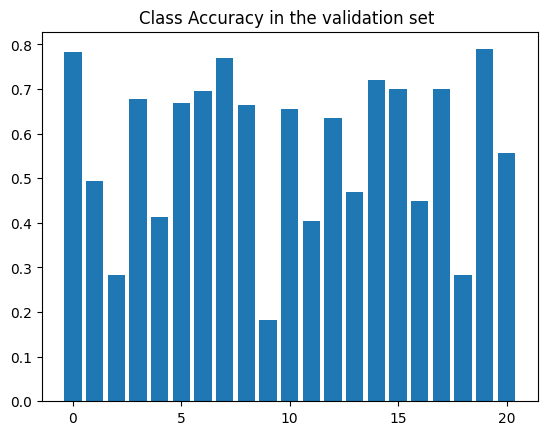


Test set (736): Average loss: 0.6347, mIoU: 0.5712

PSPnetLite training, epoch 29
Train Epoch: 29 [240/8498 (3%)]	Loss: 0.297405, Learning rate: 0.001000
Train Epoch: 29 [480/8498 (6%)]	Loss: 0.386290, Learning rate: 0.001000
Train Epoch: 29 [720/8498 (8%)]	Loss: 0.480397, Learning rate: 0.001000
Train Epoch: 29 [960/8498 (11%)]	Loss: 0.365812, Learning rate: 0.001000
Train Epoch: 29 [1200/8498 (14%)]	Loss: 0.216868, Learning rate: 0.001000
Train Epoch: 29 [1440/8498 (17%)]	Loss: 0.312770, Learning rate: 0.001000
Train Epoch: 29 [1680/8498 (20%)]	Loss: 0.396354, Learning rate: 0.001000
Train Epoch: 29 [1920/8498 (23%)]	Loss: 0.370153, Learning rate: 0.001000
Train Epoch: 29 [2160/8498 (25%)]	Loss: 0.379993, Learning rate: 0.001000
Train Epoch: 29 [2400/8498 (28%)]	Loss: 0.318025, Learning rate: 0.001000
Train Epoch: 29 [2640/8498 (31%)]	Loss: 0.441349, Learning rate: 0.001000
Train Epoch: 29 [2880/8498 (34%)]	Loss: 0.369569, Learning rate: 0.001000
Train Epoch: 29 [3120/8498 (37%)]	Lo

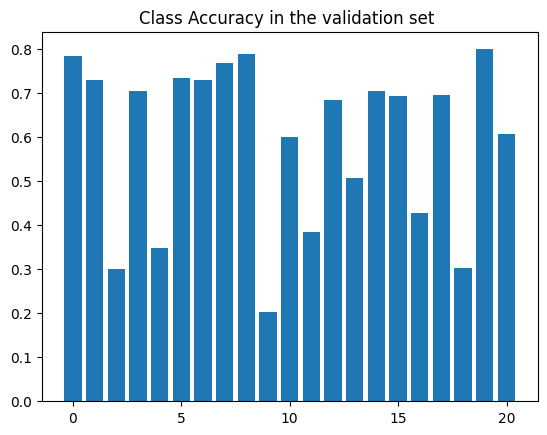


Test set (736): Average loss: 0.6303, mIoU: 0.5945

PSPnetLite training, epoch 30
Train Epoch: 30 [240/8498 (3%)]	Loss: 0.738362, Learning rate: 0.001000
Train Epoch: 30 [480/8498 (6%)]	Loss: 0.331687, Learning rate: 0.001000
Train Epoch: 30 [720/8498 (8%)]	Loss: 0.332080, Learning rate: 0.001000
Train Epoch: 30 [960/8498 (11%)]	Loss: 0.419014, Learning rate: 0.001000
Train Epoch: 30 [1200/8498 (14%)]	Loss: 0.348759, Learning rate: 0.001000
Train Epoch: 30 [1440/8498 (17%)]	Loss: 0.495072, Learning rate: 0.001000
Train Epoch: 30 [1680/8498 (20%)]	Loss: 0.452587, Learning rate: 0.001000
Train Epoch: 30 [1920/8498 (23%)]	Loss: 0.352216, Learning rate: 0.001000
Train Epoch: 30 [2160/8498 (25%)]	Loss: 0.350904, Learning rate: 0.001000
Train Epoch: 30 [2400/8498 (28%)]	Loss: 0.459172, Learning rate: 0.001000
Train Epoch: 30 [2640/8498 (31%)]	Loss: 0.374355, Learning rate: 0.001000
Train Epoch: 30 [2880/8498 (34%)]	Loss: 0.301456, Learning rate: 0.001000
Train Epoch: 30 [3120/8498 (37%)]	Lo

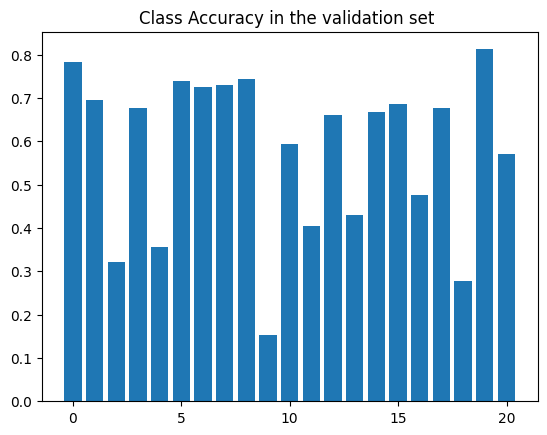


Test set (736): Average loss: 0.6256, mIoU: 0.5800

PSPnetLite training, epoch 31
Train Epoch: 31 [240/8498 (3%)]	Loss: 0.425450, Learning rate: 0.001000
Train Epoch: 31 [480/8498 (6%)]	Loss: 0.389094, Learning rate: 0.001000
Train Epoch: 31 [720/8498 (8%)]	Loss: 0.485230, Learning rate: 0.001000
Train Epoch: 31 [960/8498 (11%)]	Loss: 0.306272, Learning rate: 0.001000
Train Epoch: 31 [1200/8498 (14%)]	Loss: 0.433407, Learning rate: 0.001000
Train Epoch: 31 [1440/8498 (17%)]	Loss: 0.316935, Learning rate: 0.001000
Train Epoch: 31 [1680/8498 (20%)]	Loss: 0.333577, Learning rate: 0.001000
Train Epoch: 31 [1920/8498 (23%)]	Loss: 0.332085, Learning rate: 0.001000
Train Epoch: 31 [2160/8498 (25%)]	Loss: 0.361940, Learning rate: 0.001000
Train Epoch: 31 [2400/8498 (28%)]	Loss: 0.261298, Learning rate: 0.001000
Train Epoch: 31 [2640/8498 (31%)]	Loss: 0.370119, Learning rate: 0.001000
Train Epoch: 31 [2880/8498 (34%)]	Loss: 0.345487, Learning rate: 0.001000
Train Epoch: 31 [3120/8498 (37%)]	Lo

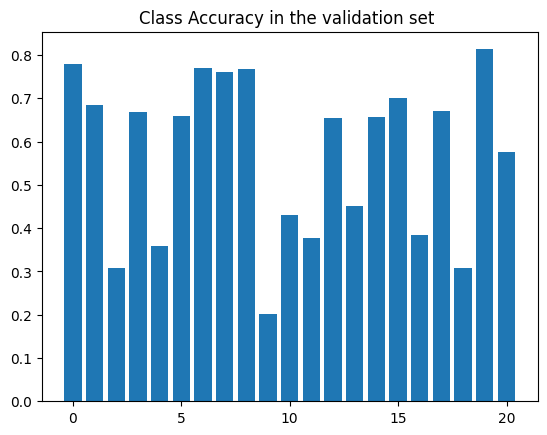


Test set (736): Average loss: 0.6633, mIoU: 0.5703

PSPnetLite training, epoch 32
Train Epoch: 32 [240/8498 (3%)]	Loss: 0.293719, Learning rate: 0.001000
Train Epoch: 32 [480/8498 (6%)]	Loss: 0.374643, Learning rate: 0.001000
Train Epoch: 32 [720/8498 (8%)]	Loss: 0.271444, Learning rate: 0.001000
Train Epoch: 32 [960/8498 (11%)]	Loss: 0.302511, Learning rate: 0.001000
Train Epoch: 32 [1200/8498 (14%)]	Loss: 0.331938, Learning rate: 0.001000
Train Epoch: 32 [1440/8498 (17%)]	Loss: 0.348529, Learning rate: 0.001000
Train Epoch: 32 [1680/8498 (20%)]	Loss: 0.375399, Learning rate: 0.001000
Train Epoch: 32 [1920/8498 (23%)]	Loss: 0.288940, Learning rate: 0.001000
Train Epoch: 32 [2160/8498 (25%)]	Loss: 0.394430, Learning rate: 0.001000
Train Epoch: 32 [2400/8498 (28%)]	Loss: 0.370508, Learning rate: 0.001000
Train Epoch: 32 [2640/8498 (31%)]	Loss: 0.453795, Learning rate: 0.001000
Train Epoch: 32 [2880/8498 (34%)]	Loss: 0.393794, Learning rate: 0.001000
Train Epoch: 32 [3120/8498 (37%)]	Lo

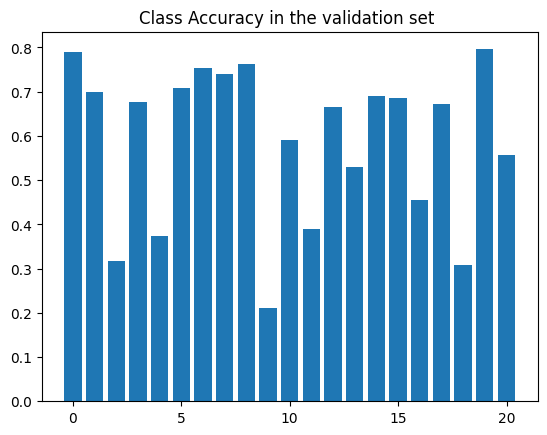


Test set (736): Average loss: 0.6146, mIoU: 0.5892

PSPnetLite training, epoch 33
Train Epoch: 33 [240/8498 (3%)]	Loss: 0.369418, Learning rate: 0.001000
Train Epoch: 33 [480/8498 (6%)]	Loss: 0.358710, Learning rate: 0.001000
Train Epoch: 33 [720/8498 (8%)]	Loss: 0.359628, Learning rate: 0.001000
Train Epoch: 33 [960/8498 (11%)]	Loss: 0.461071, Learning rate: 0.001000
Train Epoch: 33 [1200/8498 (14%)]	Loss: 0.379159, Learning rate: 0.001000
Train Epoch: 33 [1440/8498 (17%)]	Loss: 0.475345, Learning rate: 0.001000
Train Epoch: 33 [1680/8498 (20%)]	Loss: 0.488417, Learning rate: 0.001000
Train Epoch: 33 [1920/8498 (23%)]	Loss: 0.263255, Learning rate: 0.001000
Train Epoch: 33 [2160/8498 (25%)]	Loss: 0.250995, Learning rate: 0.001000
Train Epoch: 33 [2400/8498 (28%)]	Loss: 0.399862, Learning rate: 0.001000
Train Epoch: 33 [2640/8498 (31%)]	Loss: 0.506390, Learning rate: 0.001000
Train Epoch: 33 [2880/8498 (34%)]	Loss: 0.434059, Learning rate: 0.001000
Train Epoch: 33 [3120/8498 (37%)]	Lo

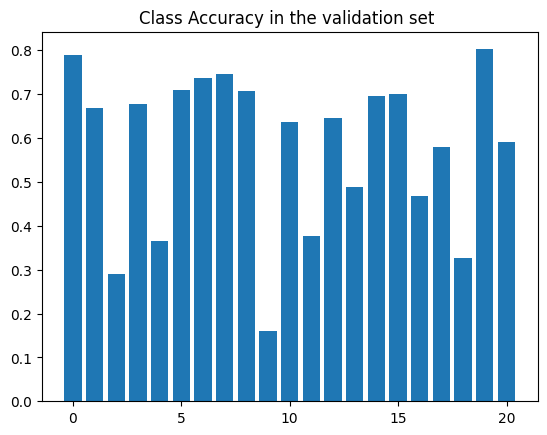


Test set (736): Average loss: 0.6489, mIoU: 0.5790

PSPnetLite training, epoch 34
Train Epoch: 34 [240/8498 (3%)]	Loss: 0.365484, Learning rate: 0.001000
Train Epoch: 34 [480/8498 (6%)]	Loss: 0.460265, Learning rate: 0.001000
Train Epoch: 34 [720/8498 (8%)]	Loss: 0.315805, Learning rate: 0.001000
Train Epoch: 34 [960/8498 (11%)]	Loss: 0.300967, Learning rate: 0.001000
Train Epoch: 34 [1200/8498 (14%)]	Loss: 0.468763, Learning rate: 0.001000
Train Epoch: 34 [1440/8498 (17%)]	Loss: 0.274797, Learning rate: 0.001000
Train Epoch: 34 [1680/8498 (20%)]	Loss: 0.390375, Learning rate: 0.001000
Train Epoch: 34 [1920/8498 (23%)]	Loss: 0.415067, Learning rate: 0.001000
Train Epoch: 34 [2160/8498 (25%)]	Loss: 0.354481, Learning rate: 0.001000
Train Epoch: 34 [2400/8498 (28%)]	Loss: 0.293388, Learning rate: 0.001000
Train Epoch: 34 [2640/8498 (31%)]	Loss: 0.495093, Learning rate: 0.001000
Train Epoch: 34 [2880/8498 (34%)]	Loss: 0.285106, Learning rate: 0.001000
Train Epoch: 34 [3120/8498 (37%)]	Lo

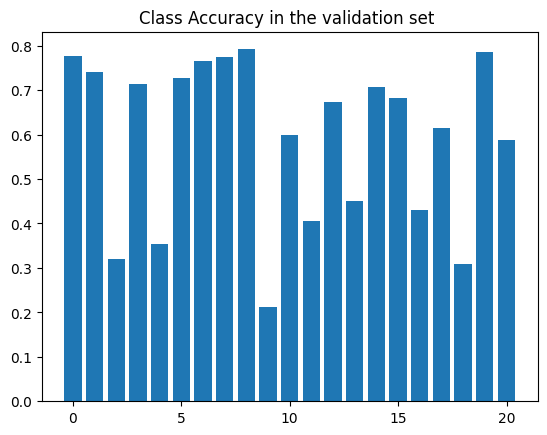


Test set (736): Average loss: 0.5996, mIoU: 0.5916

PSPnetLite training, epoch 35
Train Epoch: 35 [240/8498 (3%)]	Loss: 0.340184, Learning rate: 0.001000
Train Epoch: 35 [480/8498 (6%)]	Loss: 0.270830, Learning rate: 0.001000
Train Epoch: 35 [720/8498 (8%)]	Loss: 0.207865, Learning rate: 0.001000
Train Epoch: 35 [960/8498 (11%)]	Loss: 0.425894, Learning rate: 0.001000
Train Epoch: 35 [1200/8498 (14%)]	Loss: 0.292826, Learning rate: 0.001000
Train Epoch: 35 [1440/8498 (17%)]	Loss: 0.424515, Learning rate: 0.001000
Train Epoch: 35 [1680/8498 (20%)]	Loss: 0.372280, Learning rate: 0.001000
Train Epoch: 35 [1920/8498 (23%)]	Loss: 0.384525, Learning rate: 0.001000
Train Epoch: 35 [2160/8498 (25%)]	Loss: 0.313942, Learning rate: 0.001000
Train Epoch: 35 [2400/8498 (28%)]	Loss: 0.342902, Learning rate: 0.001000
Train Epoch: 35 [2640/8498 (31%)]	Loss: 0.300655, Learning rate: 0.001000
Train Epoch: 35 [2880/8498 (34%)]	Loss: 0.297925, Learning rate: 0.001000
Train Epoch: 35 [3120/8498 (37%)]	Lo

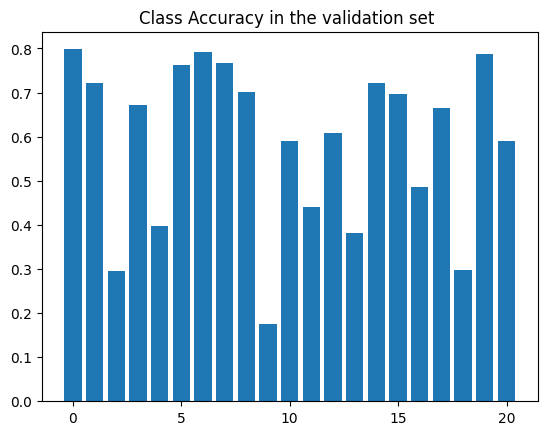


Test set (736): Average loss: 0.6252, mIoU: 0.5877

PSPnetLite training, epoch 36
Train Epoch: 36 [240/8498 (3%)]	Loss: 0.379073, Learning rate: 0.001000
Train Epoch: 36 [480/8498 (6%)]	Loss: 0.352272, Learning rate: 0.001000
Train Epoch: 36 [720/8498 (8%)]	Loss: 0.341053, Learning rate: 0.001000
Train Epoch: 36 [960/8498 (11%)]	Loss: 0.316827, Learning rate: 0.001000
Train Epoch: 36 [1200/8498 (14%)]	Loss: 0.400634, Learning rate: 0.001000
Train Epoch: 36 [1440/8498 (17%)]	Loss: 0.392444, Learning rate: 0.001000
Train Epoch: 36 [1680/8498 (20%)]	Loss: 0.261264, Learning rate: 0.001000
Train Epoch: 36 [1920/8498 (23%)]	Loss: 0.378068, Learning rate: 0.001000
Train Epoch: 36 [2160/8498 (25%)]	Loss: 0.316642, Learning rate: 0.001000
Train Epoch: 36 [2400/8498 (28%)]	Loss: 0.310299, Learning rate: 0.001000
Train Epoch: 36 [2640/8498 (31%)]	Loss: 0.364838, Learning rate: 0.001000
Train Epoch: 36 [2880/8498 (34%)]	Loss: 0.286182, Learning rate: 0.001000
Train Epoch: 36 [3120/8498 (37%)]	Lo

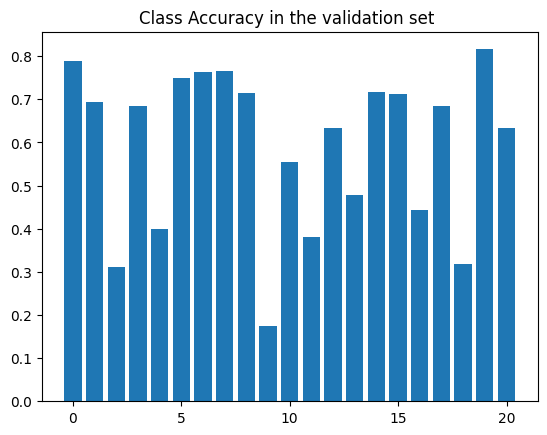


Test set (736): Average loss: 0.6288, mIoU: 0.5908

PSPnetLite training, epoch 37
Train Epoch: 37 [240/8498 (3%)]	Loss: 0.253819, Learning rate: 0.001000
Train Epoch: 37 [480/8498 (6%)]	Loss: 0.362511, Learning rate: 0.001000
Train Epoch: 37 [720/8498 (8%)]	Loss: 0.323808, Learning rate: 0.001000
Train Epoch: 37 [960/8498 (11%)]	Loss: 0.465129, Learning rate: 0.001000
Train Epoch: 37 [1200/8498 (14%)]	Loss: 0.270955, Learning rate: 0.001000
Train Epoch: 37 [1440/8498 (17%)]	Loss: 0.311187, Learning rate: 0.001000
Train Epoch: 37 [1680/8498 (20%)]	Loss: 0.279078, Learning rate: 0.001000
Train Epoch: 37 [1920/8498 (23%)]	Loss: 0.301576, Learning rate: 0.001000
Train Epoch: 37 [2160/8498 (25%)]	Loss: 0.284028, Learning rate: 0.001000
Train Epoch: 37 [2400/8498 (28%)]	Loss: 0.346125, Learning rate: 0.001000
Train Epoch: 37 [2640/8498 (31%)]	Loss: 0.354890, Learning rate: 0.001000
Train Epoch: 37 [2880/8498 (34%)]	Loss: 0.308683, Learning rate: 0.001000
Train Epoch: 37 [3120/8498 (37%)]	Lo

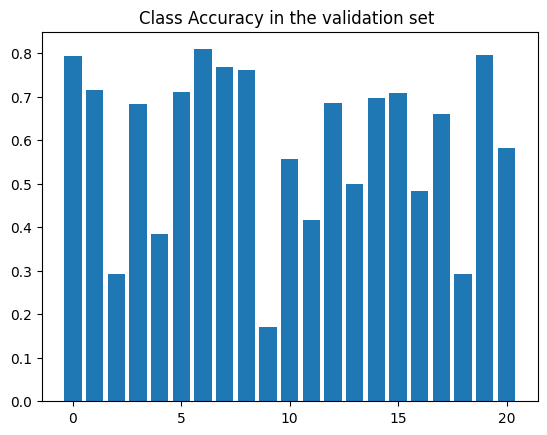


Test set (736): Average loss: 0.6183, mIoU: 0.5940

PSPnetLite training, epoch 38
Train Epoch: 38 [240/8498 (3%)]	Loss: 0.385774, Learning rate: 0.001000
Train Epoch: 38 [480/8498 (6%)]	Loss: 0.243915, Learning rate: 0.001000
Train Epoch: 38 [720/8498 (8%)]	Loss: 0.251037, Learning rate: 0.001000
Train Epoch: 38 [960/8498 (11%)]	Loss: 0.227238, Learning rate: 0.001000
Train Epoch: 38 [1200/8498 (14%)]	Loss: 0.412026, Learning rate: 0.001000
Train Epoch: 38 [1440/8498 (17%)]	Loss: 0.329198, Learning rate: 0.001000
Train Epoch: 38 [1680/8498 (20%)]	Loss: 0.462445, Learning rate: 0.001000
Train Epoch: 38 [1920/8498 (23%)]	Loss: 0.293173, Learning rate: 0.001000
Train Epoch: 38 [2160/8498 (25%)]	Loss: 0.272500, Learning rate: 0.001000
Train Epoch: 38 [2400/8498 (28%)]	Loss: 0.246653, Learning rate: 0.001000
Train Epoch: 38 [2640/8498 (31%)]	Loss: 0.224039, Learning rate: 0.001000
Train Epoch: 38 [2880/8498 (34%)]	Loss: 0.538148, Learning rate: 0.001000
Train Epoch: 38 [3120/8498 (37%)]	Lo

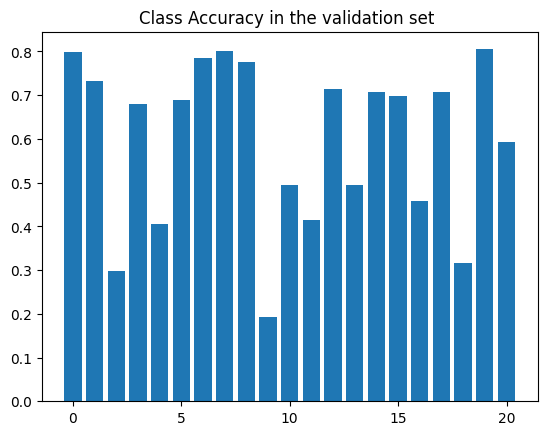


Test set (736): Average loss: 0.6106, mIoU: 0.5981

PSPnetLite training, epoch 39
Train Epoch: 39 [240/8498 (3%)]	Loss: 0.316594, Learning rate: 0.001000
Train Epoch: 39 [480/8498 (6%)]	Loss: 0.360813, Learning rate: 0.001000
Train Epoch: 39 [720/8498 (8%)]	Loss: 0.339141, Learning rate: 0.001000
Train Epoch: 39 [960/8498 (11%)]	Loss: 0.329721, Learning rate: 0.001000
Train Epoch: 39 [1200/8498 (14%)]	Loss: 0.327739, Learning rate: 0.001000
Train Epoch: 39 [1440/8498 (17%)]	Loss: 0.442309, Learning rate: 0.001000
Train Epoch: 39 [1680/8498 (20%)]	Loss: 0.234816, Learning rate: 0.001000
Train Epoch: 39 [1920/8498 (23%)]	Loss: 0.454319, Learning rate: 0.001000
Train Epoch: 39 [2160/8498 (25%)]	Loss: 0.202919, Learning rate: 0.001000
Train Epoch: 39 [2400/8498 (28%)]	Loss: 0.224639, Learning rate: 0.001000
Train Epoch: 39 [2640/8498 (31%)]	Loss: 0.444212, Learning rate: 0.001000
Train Epoch: 39 [2880/8498 (34%)]	Loss: 0.279781, Learning rate: 0.001000
Train Epoch: 39 [3120/8498 (37%)]	Lo

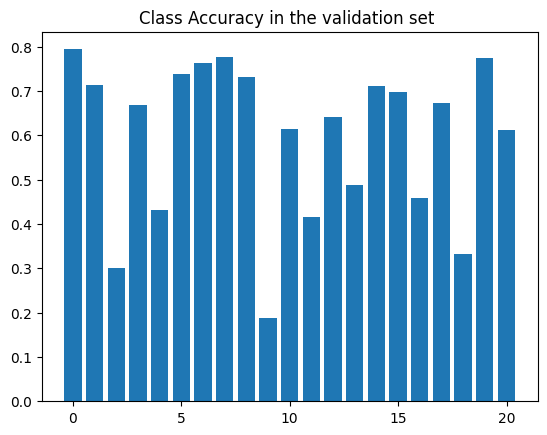


Test set (736): Average loss: 0.6077, mIoU: 0.5962

PSPnetLite training, epoch 40
Train Epoch: 40 [240/8498 (3%)]	Loss: 0.217648, Learning rate: 0.001000
Train Epoch: 40 [480/8498 (6%)]	Loss: 0.250681, Learning rate: 0.001000
Train Epoch: 40 [720/8498 (8%)]	Loss: 0.293647, Learning rate: 0.001000
Train Epoch: 40 [960/8498 (11%)]	Loss: 0.330026, Learning rate: 0.001000
Train Epoch: 40 [1200/8498 (14%)]	Loss: 0.284248, Learning rate: 0.001000
Train Epoch: 40 [1440/8498 (17%)]	Loss: 0.364508, Learning rate: 0.001000
Train Epoch: 40 [1680/8498 (20%)]	Loss: 0.260329, Learning rate: 0.001000
Train Epoch: 40 [1920/8498 (23%)]	Loss: 0.278410, Learning rate: 0.001000
Train Epoch: 40 [2160/8498 (25%)]	Loss: 0.464852, Learning rate: 0.001000
Train Epoch: 40 [2400/8498 (28%)]	Loss: 0.403247, Learning rate: 0.001000
Train Epoch: 40 [2640/8498 (31%)]	Loss: 0.221932, Learning rate: 0.001000
Train Epoch: 40 [2880/8498 (34%)]	Loss: 0.545231, Learning rate: 0.001000
Train Epoch: 40 [3120/8498 (37%)]	Lo

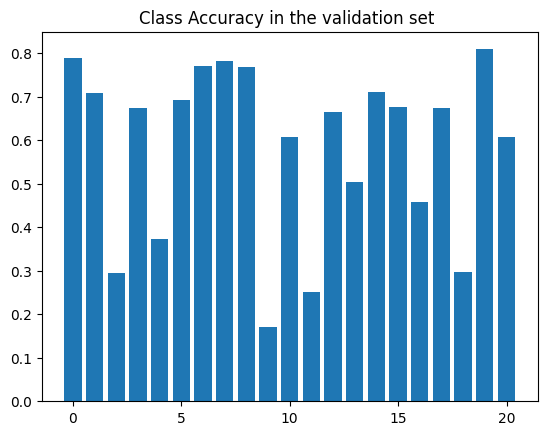


Test set (736): Average loss: 0.6349, mIoU: 0.5851

PSPnetLite training, epoch 41
Train Epoch: 41 [240/8498 (3%)]	Loss: 0.315648, Learning rate: 0.001000
Train Epoch: 41 [480/8498 (6%)]	Loss: 0.379016, Learning rate: 0.001000
Train Epoch: 41 [720/8498 (8%)]	Loss: 0.234985, Learning rate: 0.001000
Train Epoch: 41 [960/8498 (11%)]	Loss: 0.267725, Learning rate: 0.001000
Train Epoch: 41 [1200/8498 (14%)]	Loss: 0.406208, Learning rate: 0.001000
Train Epoch: 41 [1440/8498 (17%)]	Loss: 0.245841, Learning rate: 0.001000
Train Epoch: 41 [1680/8498 (20%)]	Loss: 0.387111, Learning rate: 0.001000
Train Epoch: 41 [1920/8498 (23%)]	Loss: 0.281154, Learning rate: 0.001000
Train Epoch: 41 [2160/8498 (25%)]	Loss: 0.283019, Learning rate: 0.001000
Train Epoch: 41 [2400/8498 (28%)]	Loss: 0.381704, Learning rate: 0.001000
Train Epoch: 41 [2640/8498 (31%)]	Loss: 0.226830, Learning rate: 0.001000
Train Epoch: 41 [2880/8498 (34%)]	Loss: 0.332126, Learning rate: 0.001000
Train Epoch: 41 [3120/8498 (37%)]	Lo

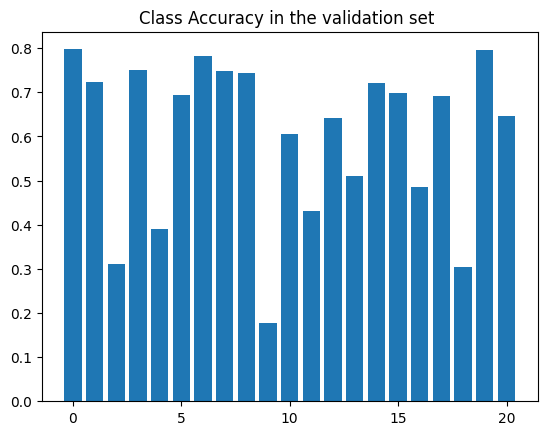


Test set (736): Average loss: 0.6053, mIoU: 0.6022

PSPnetLite training, epoch 42
Train Epoch: 42 [240/8498 (3%)]	Loss: 0.267658, Learning rate: 0.001000
Train Epoch: 42 [480/8498 (6%)]	Loss: 0.279992, Learning rate: 0.001000
Train Epoch: 42 [720/8498 (8%)]	Loss: 0.199122, Learning rate: 0.001000
Train Epoch: 42 [960/8498 (11%)]	Loss: 0.434306, Learning rate: 0.001000
Train Epoch: 42 [1200/8498 (14%)]	Loss: 0.279340, Learning rate: 0.001000
Train Epoch: 42 [1440/8498 (17%)]	Loss: 0.261999, Learning rate: 0.001000
Train Epoch: 42 [1680/8498 (20%)]	Loss: 0.311136, Learning rate: 0.001000
Train Epoch: 42 [1920/8498 (23%)]	Loss: 0.226265, Learning rate: 0.001000
Train Epoch: 42 [2160/8498 (25%)]	Loss: 0.223326, Learning rate: 0.001000
Train Epoch: 42 [2400/8498 (28%)]	Loss: 0.324124, Learning rate: 0.001000
Train Epoch: 42 [2640/8498 (31%)]	Loss: 0.240813, Learning rate: 0.001000
Train Epoch: 42 [2880/8498 (34%)]	Loss: 0.341220, Learning rate: 0.001000
Train Epoch: 42 [3120/8498 (37%)]	Lo

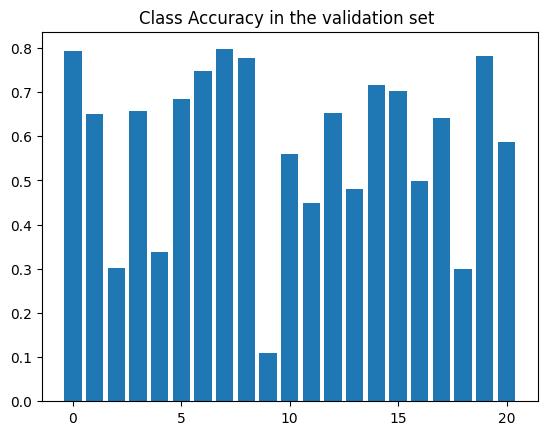


Test set (736): Average loss: 0.6478, mIoU: 0.5819

PSPnetLite training, epoch 43
Train Epoch: 43 [240/8498 (3%)]	Loss: 0.312593, Learning rate: 0.001000
Train Epoch: 43 [480/8498 (6%)]	Loss: 0.357605, Learning rate: 0.001000
Train Epoch: 43 [720/8498 (8%)]	Loss: 0.459479, Learning rate: 0.001000
Train Epoch: 43 [960/8498 (11%)]	Loss: 0.456372, Learning rate: 0.001000
Train Epoch: 43 [1200/8498 (14%)]	Loss: 0.285314, Learning rate: 0.001000
Train Epoch: 43 [1440/8498 (17%)]	Loss: 0.257001, Learning rate: 0.001000
Train Epoch: 43 [1680/8498 (20%)]	Loss: 0.417670, Learning rate: 0.001000
Train Epoch: 43 [1920/8498 (23%)]	Loss: 0.363774, Learning rate: 0.001000
Train Epoch: 43 [2160/8498 (25%)]	Loss: 0.419149, Learning rate: 0.001000
Train Epoch: 43 [2400/8498 (28%)]	Loss: 0.228486, Learning rate: 0.001000
Train Epoch: 43 [2640/8498 (31%)]	Loss: 0.657585, Learning rate: 0.001000
Train Epoch: 43 [2880/8498 (34%)]	Loss: 0.413040, Learning rate: 0.001000
Train Epoch: 43 [3120/8498 (37%)]	Lo

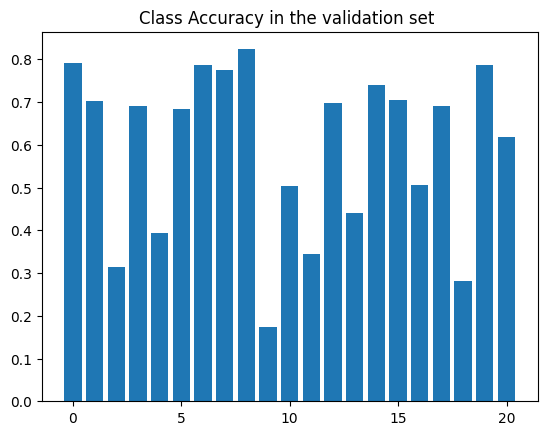


Test set (736): Average loss: 0.6541, mIoU: 0.5927

PSPnetLite training, epoch 44
Train Epoch: 44 [240/8498 (3%)]	Loss: 0.350493, Learning rate: 0.001000
Train Epoch: 44 [480/8498 (6%)]	Loss: 0.431561, Learning rate: 0.001000
Train Epoch: 44 [720/8498 (8%)]	Loss: 0.327910, Learning rate: 0.001000
Train Epoch: 44 [960/8498 (11%)]	Loss: 0.337307, Learning rate: 0.001000
Train Epoch: 44 [1200/8498 (14%)]	Loss: 0.268358, Learning rate: 0.001000
Train Epoch: 44 [1440/8498 (17%)]	Loss: 0.303041, Learning rate: 0.001000
Train Epoch: 44 [1680/8498 (20%)]	Loss: 0.245167, Learning rate: 0.001000
Train Epoch: 44 [1920/8498 (23%)]	Loss: 0.330055, Learning rate: 0.001000
Train Epoch: 44 [2160/8498 (25%)]	Loss: 0.452635, Learning rate: 0.001000
Train Epoch: 44 [2400/8498 (28%)]	Loss: 0.304124, Learning rate: 0.001000
Train Epoch: 44 [2640/8498 (31%)]	Loss: 0.381497, Learning rate: 0.001000
Train Epoch: 44 [2880/8498 (34%)]	Loss: 0.248742, Learning rate: 0.001000
Train Epoch: 44 [3120/8498 (37%)]	Lo

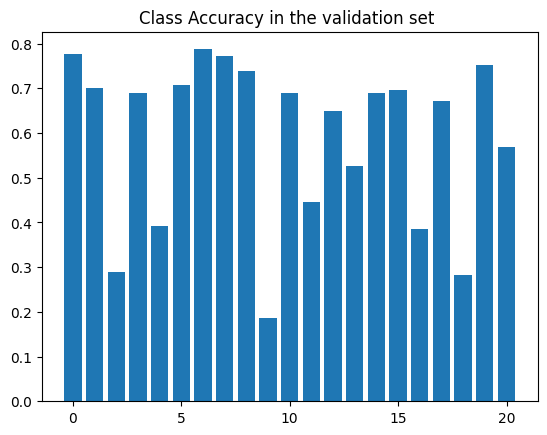


Test set (736): Average loss: 0.6213, mIoU: 0.5900

PSPnetLite training, epoch 45
Train Epoch: 45 [240/8498 (3%)]	Loss: 0.260776, Learning rate: 0.001000
Train Epoch: 45 [480/8498 (6%)]	Loss: 0.356377, Learning rate: 0.001000
Train Epoch: 45 [720/8498 (8%)]	Loss: 0.484358, Learning rate: 0.001000
Train Epoch: 45 [960/8498 (11%)]	Loss: 0.159941, Learning rate: 0.001000
Train Epoch: 45 [1200/8498 (14%)]	Loss: 0.257448, Learning rate: 0.001000
Train Epoch: 45 [1440/8498 (17%)]	Loss: 0.225377, Learning rate: 0.001000
Train Epoch: 45 [1680/8498 (20%)]	Loss: 0.414210, Learning rate: 0.001000
Train Epoch: 45 [1920/8498 (23%)]	Loss: 0.338254, Learning rate: 0.001000
Train Epoch: 45 [2160/8498 (25%)]	Loss: 0.325243, Learning rate: 0.001000
Train Epoch: 45 [2400/8498 (28%)]	Loss: 0.520415, Learning rate: 0.001000
Train Epoch: 45 [2640/8498 (31%)]	Loss: 0.319063, Learning rate: 0.001000
Train Epoch: 45 [2880/8498 (34%)]	Loss: 0.334743, Learning rate: 0.001000
Train Epoch: 45 [3120/8498 (37%)]	Lo

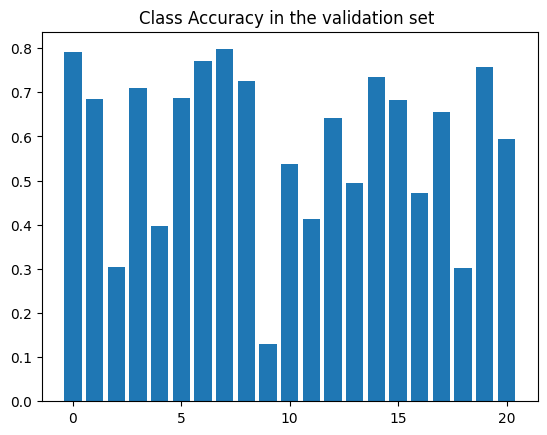


Test set (736): Average loss: 0.6391, mIoU: 0.5847



In [33]:
loss_train_epoch_weights = []
loss_test_epoch_weights = []

acc_test_per_epoch_weights = []
new_labels = []

cont = 0

res_path = "./metrics_" + args.experiment_name

if not os.path.isdir(res_path):
    os.makedirs(res_path)

for epoch in range(1, args.epoch + 1):
    st = time.time()

    # To fill: Train for one epoch
    print("PSPnetLite training, epoch " + str(epoch))
    loss_per_epoch = train_SemanticSeg_Weights(args, model_weights, device, train_loader, optimizer_weights, weights, epoch)

    loss_train_epoch_weights += [loss_per_epoch]

    scheduler_weights.step()

    # To fill: test/validate
    loss_per_epoch_test, acc_val_per_epoch_i = testing(args, model_weights, device, test_loader)

    loss_test_epoch_weights  += loss_per_epoch_test
    acc_test_per_epoch_weights += [acc_val_per_epoch_i]

    if epoch == 1:
        best_acc_val = acc_val_per_epoch_i

    else:
        if acc_val_per_epoch_i > best_acc_val:
            best_acc_val = acc_val_per_epoch_i

    if epoch==args.epoch:
        torch.save(model_weights.state_dict(), "SemanticSegModel_weights.pth")

    np.save(res_path + '/' + 'LOSS_epoch_train_weights.npy', np.asarray(loss_train_epoch_weights))
    np.save(res_path + '/' + 'LOSS_epoch_val_weights.npy', np.asarray(loss_test_epoch_weights))

    # save accuracies:
    np.save(res_path + '/' + 'accuracy_per_epoch_val.npy', np.asarray(acc_test_per_epoch_weights))

    cont += 1

### Accuracy and loss curves for semantic segmentation
Comparison between using and not using class weights in the loss

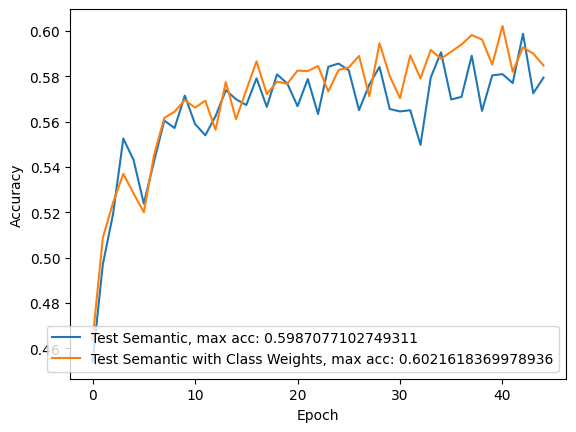

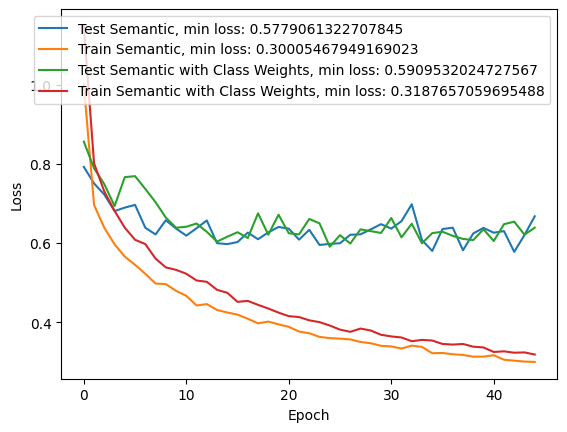

In [34]:
##Accuracy
#acc_train = np.asarray(acc_train_per_epoch)
acc_test_weights  = np.asarray(acc_test_per_epoch_weights)

#Loss per epoch
loss_test_weights  = np.asarray(loss_test_epoch_weights)
loss_train_weights = np.asarray(loss_train_epoch_weights)

numEpochs = len(acc_test_weights)
epochs = range(numEpochs)

plt.figure(1)
plt.plot(epochs, acc_test, label='Test Semantic, max acc: ' + str(np.max(acc_test)))
plt.plot(epochs, acc_test_weights, label='Test Semantic with Class Weights, max acc: ' + str(np.max(acc_test_weights)))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(2)
plt.plot(epochs, loss_test, label='Test Semantic, min loss: ' + str(np.min(loss_test)))
plt.plot(epochs, loss_train, label='Train Semantic, min loss: ' + str(np.min(loss_train)))
plt.plot(epochs, loss_test_weights, label='Test Semantic with Class Weights, min loss: ' + str(np.min(loss_test_weights)))
plt.plot(epochs, loss_train_weights, label='Train Semantic with Class Weights, min loss: ' + str(np.min(loss_train_weights)))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

## Visually comparison of semantic segmentation results
Semantic segmentation is a task that requires heavy training with resources and time out of the possibilities of this lab assignement. Therefore, do not expect great results here :).

### Define Functions to visualize results:
1st: Denormalization
2nd: Colorize images

In [35]:
class DeNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


def visualizeSegmentation(args, model_1, model_2, device, test_loader, imageDenormalize, colors):

    # switch to train mode
    model_1.eval()
    model_2.eval()

    with torch.no_grad():
        for batch_idx, (images, mask) in enumerate(test_loader):

            images, mask = images.to(device), mask.to(device)

            outputs_1 = model_1(images)
            outputs_2 = model_2(images)

            plt.figure(batch_idx)

            for i in range(0, images.size(0)):


                image_np = (255*(imageDenormalize(images[i,...]).data.permute(1,2,0).cpu().numpy())).astype(np.uint8)
                img_pil = Image.fromarray(image_np)

                gt_np = mask[i,...].squeeze().data.cpu().numpy()
                gt_np_color = np.stack((gt_np.copy(), gt_np.copy(), gt_np.copy()), axis=2)

                pred_np_1 = outputs_1[i,...].data.max(0)[1].squeeze_(0).byte().cpu().numpy()
                pred_np_1_color = np.stack((pred_np_1.copy(), pred_np_1.copy(), pred_np_1.copy()), axis=2)

                pred_np_2 = outputs_2[i,...].data.max(0)[1].squeeze_(0).byte().cpu().numpy()
                pred_np_2_color = np.stack((pred_np_2.copy(), pred_np_2.copy(), pred_np_2.copy()), axis=2)

                # Colorize
                for j in range(0, 21):
                    idx_tuple = np.where(gt_np == j)
                    gt_np_color[idx_tuple[0], idx_tuple[1], 0] = colors[j][0]
                    gt_np_color[idx_tuple[0], idx_tuple[1], 1] = colors[j][1]
                    gt_np_color[idx_tuple[0], idx_tuple[1], 2] = colors[j][2]

                    idx_tuple2 = np.where(pred_np_1 == j)
                    pred_np_1_color[idx_tuple2[0], idx_tuple2[1], 0] = colors[j][0]
                    pred_np_1_color[idx_tuple2[0], idx_tuple2[1], 1] = colors[j][1]
                    pred_np_1_color[idx_tuple2[0], idx_tuple2[1], 2] = colors[j][2]

                    idx_tuple3 = np.where(pred_np_2 == j)
                    pred_np_2_color[idx_tuple3[0], idx_tuple3[1], 0] = colors[j][0]
                    pred_np_2_color[idx_tuple3[0], idx_tuple3[1], 1] = colors[j][1]
                    pred_np_2_color[idx_tuple3[0], idx_tuple3[1], 2] = colors[j][2]


                plt.subplot(args.test_batch_size, 4, i * 4 + 1)
                plt.imshow(img_pil)
                plt.axis('off')
                if i==0:
                  plt.title('Image')

                plt.subplot(args.test_batch_size, 4, i * 4 + 2)
                plt.imshow(gt_np_color)
                plt.axis('off')
                if i==0:
                  plt.title('GT')

                plt.subplot(args.test_batch_size, 4, i * 4 + 3)
                plt.imshow(pred_np_1_color)
                plt.axis('off')
                if i==0:
                  plt.title('Sem Seg')

                plt.subplot(args.test_batch_size, 4, i * 4 + 4)
                plt.imshow(pred_np_2_color)
                plt.axis('off')
                if i==0:
                  plt.title('Sem Seg W')


            if batch_idx>7:
                plt.show()
                break


### Results visualization

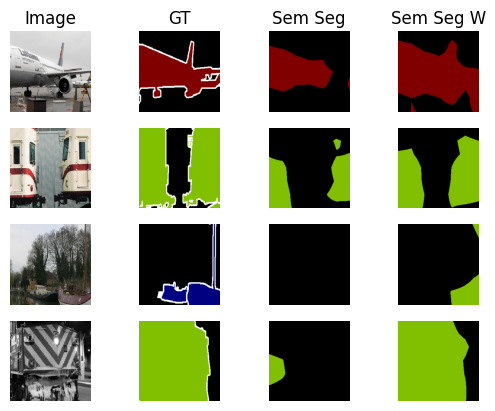

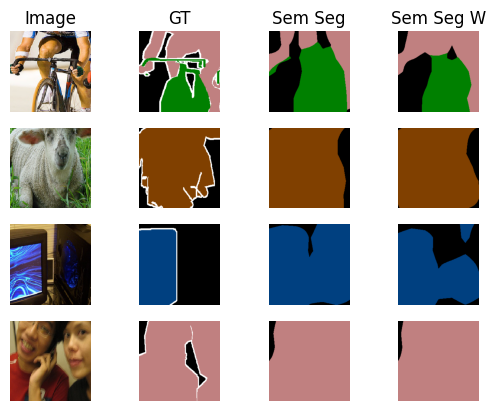

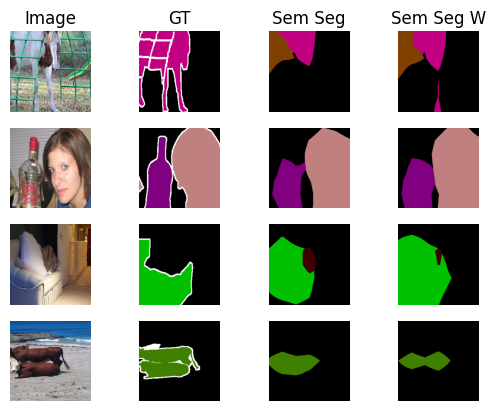

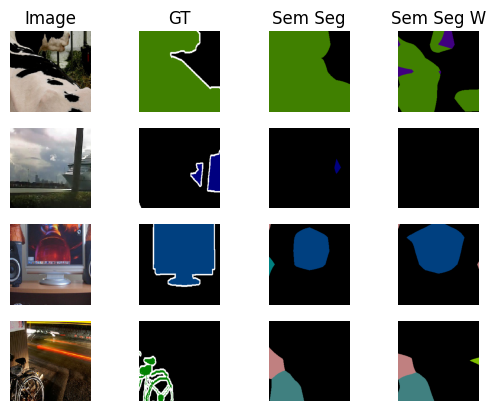

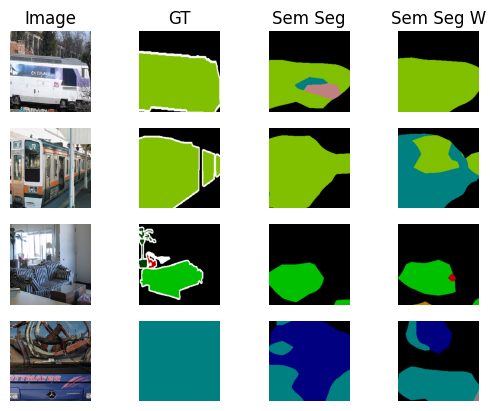

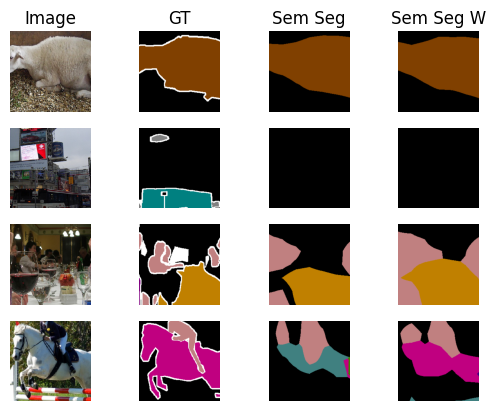

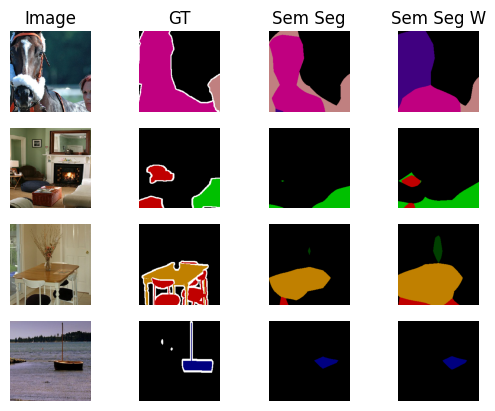

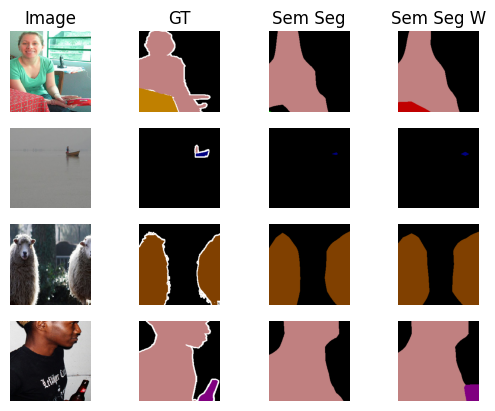

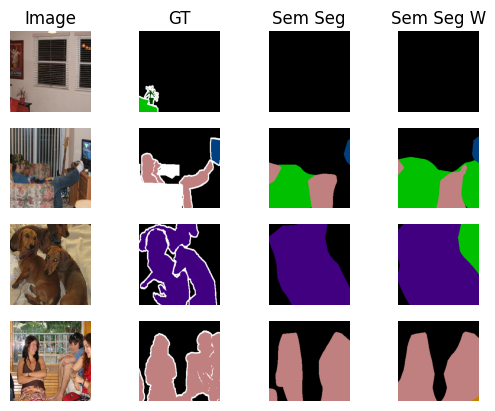

In [36]:
imageDenormalize = DeNormalize(mean,std)

## Color palette for visualization of the 21 classes
colors = np.array([[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128], [0, 128, 128],
            [128, 128, 128], [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128],
            [64, 128, 128], [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]])

cont = 0

visualizeSegmentation(args, model, model_weights, device, test_loader, imageDenormalize, colors)

# Part 2: Evaluating pretrained  models

Almost nothing to program here, just:

- Evaluate several images encompassing the learned objects (feel free to include anything here, we just need the image URL).
- Include image transformations to measure their effect.
- Compare CPU vs GPU inference time.
- Perform as many experiments as needed to arise to useful conclussions.




##Import additional packages
Find the PyTorch docs at https://pytorch.org/docs/stable/index.html

Tutorials: https://pytorch.org/tutorials/

In [37]:
from torchvision import models
import time

## Load pretrained semantic segmentation models

There are four loadable pretrained models in pytorch.

Two Fully Convolutional Networks using a ResNet50 and a ResNet101 backbone.
Two DeepLabv3 models using the same backbones.

All the models have been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.

All pre-trained models expect input images normalized in the same way. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

Although, they have been trained on images resized such that their minimum size is 520, we can use arbitrary images resolutions, as they are fully convolutional models. However, resolutions alike those used for training may result in better results.


In [38]:
# FCN ResNet50
fcn50  = models.segmentation.fcn_resnet50(pretrained=True).eval()
# FCN ResNet101
fcn101 = models.segmentation.fcn_resnet101(pretrained=True).eval()
# DeepLab ResNet50
deepL50  = models.segmentation.deeplabv3_resnet50(pretrained=True).eval()
# DeepLab ResNet101
deepL101 = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

/home/javiermunoz/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/javiermunoz/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/javiermunoz/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `w

## Define auxiliary functions to encapsulate common methods

### A function to colorize label images

A simplification of visualizeSegmentation for a single image

In [39]:
# Define the helper function
def decode_segmap(image, nc=21):
  ## Color palette for visualization of the 21 classes
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]

  rgb = np.stack([r, g, b], axis=2)
  return rgb

### A function to encapsulate normalization, segmentation and representation


In [40]:
def segment(net, path, show_orig=True,transform=None, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  input_image = transform(img).unsqueeze(0).to(dev)
  out = net.to(dev)(input_image)['out']
  segm = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  segm_rgb = decode_segmap(segm)
  plt.imshow(segm_rgb); plt.axis('off'); plt.show()

## Compare the performance of the loaded models and of the methods' parametrizations

### Load an image from the web
Changing the URL will change the image, you have some examples included, but include more!

We will use a common name 'imageToSegment.png' to generalize the process

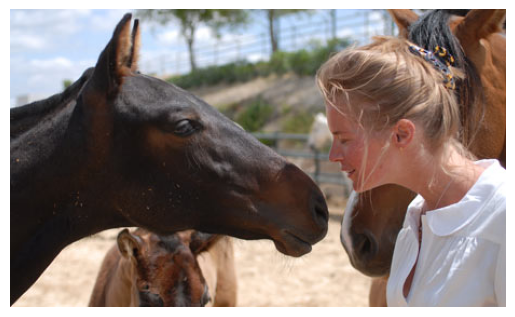

In [41]:
!rm './imageToSegment.png'

url  = 'https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fstatic.guim.co.uk%2Fsys-images%2FMedia%2FPix%2Fpictures%2F2009%2F4%2F14%2F1239732342843%2FHorse-People-with-Alexand-001.jpg&f=1&nofb=1'
#url = 'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwoofdog.org%2Fwp-content%2Fuploads%2F2017%2F08%2Fdog-sitting-on-couch-and-watching-TV.jpg&f=1&nofb=1'
#url = 'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fak8.picdn.net%2Fshutterstock%2Fvideos%2F17451598%2Fthumb%2F1.jpg&f=1&nofb=1'
#url= ...

wget.download(url, out='./imageToSegment.png')
# read image
img = Image.open('./imageToSegment.png')
# show image
plt.imshow(img); plt.axis('off'); plt.show()

### Define trasnformations
Play measuring the effect when input image is resized, cropped, inverted...

In [42]:
custom_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]) # T.Resize(640), #T.CenterCrop(224)...

### Compare visually and in terms of inference time

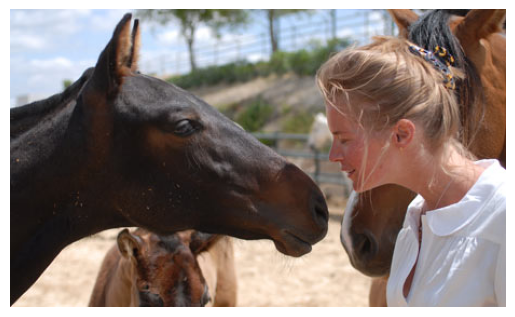

Segmentation Image on FCN ResNet50 backbone


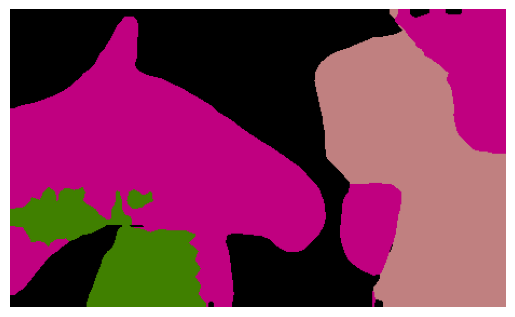

Segmentation Image on FCN ResNet101 backbone


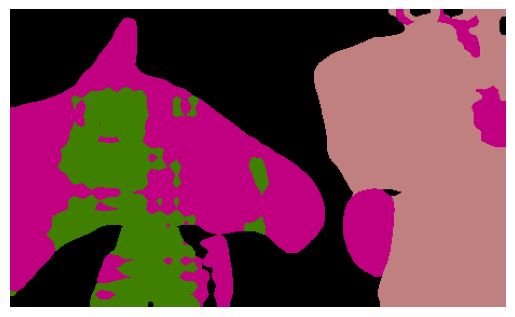

Segmentation Image on DeepLabv3 ResNet50 backbone


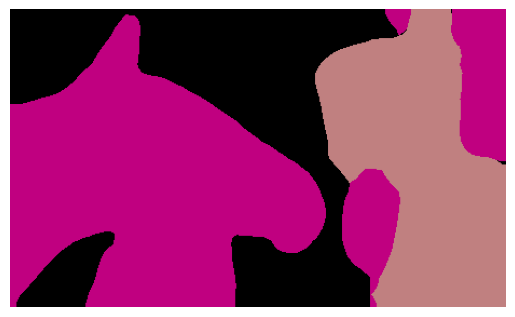

Segmentation Image on DeepLabv3 ResNet101 backbone


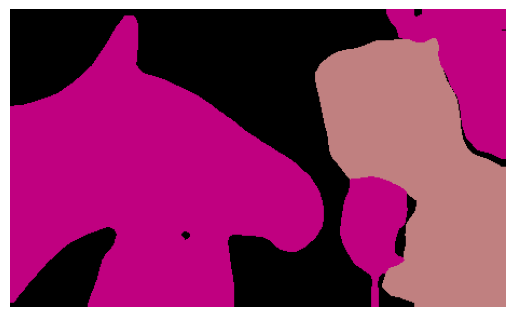

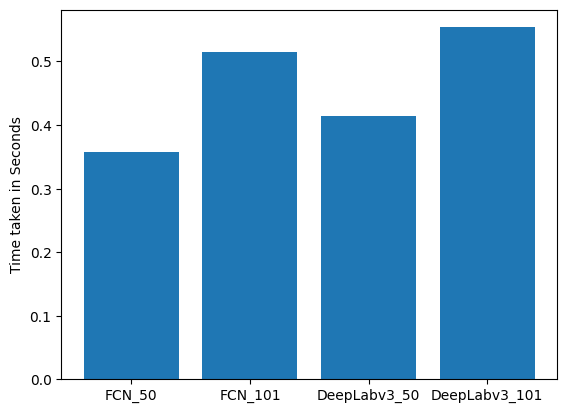

In [43]:
# read image
img = Image.open('./imageToSegment.png')
# show image
plt.imshow(img); plt.axis('off'); plt.show()

# show FCN50 segmentation results
plt.figure()
print ('Segmentation Image on FCN ResNet50 backbone')
st = time.time()
segment(fcn50, './imageToSegment.png', False, custom_transform, 'cpu')
#segment(fcn50, './imageToSegment.png', False, custom_transform)
et = time.time()
fcn50_time = et - st

# show FCN101 segmentation results
plt.figure()
print ('Segmentation Image on FCN ResNet101 backbone')
st = time.time()
segment(fcn101, './imageToSegment.png', False, custom_transform, 'cpu')
# segment(fcn101, './imageToSegment.png', False, custom_transform)
et = time.time()
fcn101_time = et - st

# show DeepLab50 segmentation results
plt.figure()
print ('Segmentation Image on DeepLabv3 ResNet50 backbone')
st = time.time()
segment(deepL50, './imageToSegment.png', False, custom_transform, 'cpu')
# segment(deepL50, './imageToSegment.png', False, custom_transform)
et = time.time()
deepL50_time = et - st

# show FCN101 segmentation results
plt.figure()
print ('Segmentation Image on DeepLabv3 ResNet101 backbone')
st = time.time()
segment(deepL101, './imageToSegment.png', False, custom_transform, 'cpu')
#segment(deepL101, './imageToSegment.png', False, custom_transform)
et = time.time()
deepL101_time = et - st

plt.figure()
plt.bar([0.1, 0.2, 0.3, 0.4], [fcn50_time, fcn101_time, deepL50_time, deepL101_time], width=0.08)
plt.ylabel('Time taken in Seconds')
plt.xticks([0.1, 0.2, 0.3, 0.4], ['FCN_50', 'FCN_101', 'DeepLabv3_50', 'DeepLabv3_101'])
plt.show()